Machine Learning - Classification - Insurance Dataset for classification

Your task is to apply various ML algorithms (see the rules below) to build a model explaining travel insurance claim outcomes based on the training sample and generate predictions for all observations from the test sample.

The dataset includes travel insurance policy records with the following columns:

- reward – Commission value earned on the insurance sale
- claim_status – Target variable (0 = Not Approved, 1 = Approved) Only in training sample
- person_gender – Gender identifier of the insured person
- entity_type – Type of selling entity
- channel – Distribution channel used
- support_interactions – Number of customer service interactions
- agent_id – Identifier for the selling agent
- customer_score – Computed value between 0-1 based on customer metrics
- entity_a – Identifier of the agency that sold the policy
- person_age – Age of the insured person
- location – Destination of the trip
- revenue – Net sales value of the policy (when <0 it covers discounts)
- product_id – Name of the insurance product
- trip_length – Duration of the insured trip in days

Files Provided

- insurance_train.csv – training data contains 56993 observations and 14 columns along with the target variable claim_status
- insurance_test.csv – test data contains 6333 observations and 13 columns without the target variable

Requirements

1. Exploratory Data Analysis:
- Analyze the dataset to identify key patterns, correlations, and potential challenges introduced by the additional variables. – Visualize distributions and relationships among variables.
2. Feature Engineering:
- Consider transformation or scaling of variables as needed. – Evaluate the impact of the supplementary variables on model performance.
3. Modeling:
- Build, train, and compare multiple regression models. – Optimize model hyperparameters using cross-validation.
4. Predictions:
- Generate predictions for all observations in the test dataset. – Document model performance and reasoning behind the selected approach.
5. Documentation:
- Provide a clear explanation of your analysis, modeling choices, and any challenges faced while integrating the additional variables.

For each of the datasets please consider and compare at least 3 different ML algorithms discussed in the ML1 course (e.g. linear/logistic regression, KNN, LASSO, ridge, elastic net, SVM/SVR with various kernel functions). You can also apply in addition any other algorithms you know, but they cannot be used instead of the ones mentioned before.

Selection of the best algorithm: The choice of the final algorithm applied to generate predictions should be clearly explained in the presentation. Use balanced accuracy for the insurance dataset.

HINT !!!!! Use the internal division of the training data into train/validation/test samples to make sure that you correcly assess the performance of your models on the new data.

Please report the expected value of a particular performance measure (expectation for the test sample) in your presentation.

# **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from scipy.stats import skew

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from scipy.stats import chi2_contingency
from scipy.stats import boxcox, yeojohnson # for power transformations
import jenkspy # for Jenks natural breaks
from optbinning import OptimalBinning

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, SVR #  Support Vector Classification i Support Vector Regression
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV

# **Exploratory Data Analysis and Data Preparation**

## Preliminary Data Checks

In [ ]:
insurance = pd.read_csv("insurance_train.csv")

In [500]:
insurance.duplicated().sum() # no duplicates

0

In [501]:
print(insurance.isnull().sum()) # no missing values

reward                  0
claim_status            0
person_gender           0
entity_type             0
channel                 0
support_interactions    0
agent_id                0
customer_score          0
entity_a                0
person_age              0
location                0
revenue                 0
product_id              0
trip_length             0
dtype: int64


In [502]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56993 entries, 0 to 56992
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reward                56993 non-null  float64
 1   claim_status          56993 non-null  int64  
 2   person_gender         56993 non-null  object 
 3   entity_type           56993 non-null  object 
 4   channel               56993 non-null  object 
 5   support_interactions  56993 non-null  int64  
 6   agent_id              56993 non-null  object 
 7   customer_score        56993 non-null  float64
 8   entity_a              56993 non-null  object 
 9   person_age            56993 non-null  int64  
 10  location              56993 non-null  object 
 11  revenue               56993 non-null  float64
 12  product_id            56993 non-null  object 
 13  trip_length           56993 non-null  int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 6.1+ MB


In [503]:
insurance.head()

reward  claim_status person_gender entity_type channel  \
0   0.000000             0      9b2d5b46      type_a     web   
1  18.428627             0      9b2d5b46      type_a     web   
2   0.000000             0      9b2d5b46      type_a     web   
3   0.000000             0      9b2d5b46      type_a     web   
4   0.000000             0      9b2d5b46      type_a     web   

   support_interactions  agent_id  customer_score  entity_a  person_age  \
0                     0  agt_0004        0.284509  50b3e71e          51   
1                     0  agt_0001        0.207538  96d6c6df          32   
2                     1  agt_0004        0.300461  50b3e71e          38   
3                     0  agt_0004        0.132404  50b3e71e          30   
4                     2  agt_0004        0.070443  50b3e71e          37   

        location     revenue              product_id  trip_length  
0  united states  105.459587         SecurePlan Flex           21  
1          spain   30.433459  DriveSafe Rental Addon            6  
2    new zealand   78.728474        TripGuard Cancel           84  
3       thailand   17.146843        TripGuard Cancel           39  
4       viet nam   10.476416        TripGuard Cancel           48

## Exploratory Data Analysis

In [504]:
categorical_variables = insurance.select_dtypes(include=['object']).columns.tolist()
continuous_variables = insurance.select_dtypes(exclude=['object']).columns.tolist()

categorical_summary = pd.DataFrame({
    'Variable': categorical_variables,
    'Levels': [insurance[var].nunique() for var in categorical_variables],
    'Unique Values': [insurance[var].unique() for var in categorical_variables]
})

continuous_summary = pd.DataFrame({
    'Variable': continuous_variables, # exclude claim_status
    'Min': [insurance[var].min() for var in continuous_variables],
    'Max': [insurance[var].max() for var in continuous_variables],
    'Mean': [insurance[var].mean() for var in continuous_variables],
    'Median': [insurance[var].median() for var in continuous_variables]
})

print(categorical_summary)
print(continuous_summary)

        Variable  Levels                                      Unique Values
0  person_gender       3                     [9b2d5b46, f67ab10a, 08f27188]
1    entity_type       2                                   [type_a, type_b]
2        channel       2                                      [web, retail]
3       agent_id      16  [agt_0004, agt_0001, agt_0002, agt_0005, agt_0...
4       entity_a      16  [50b3e71e, 96d6c6df, 7b5dbb09, 99ede4e4, 1e089...
5       location     146  [united states, spain, new zealand, thailand, ...
6     product_id      26  [SecurePlan Flex, DriveSafe Rental Addon, Trip...
               Variable         Min          Max       Mean     Median
0                reward    0.000000   282.073580   9.794976   0.000000
1          claim_status    0.000000     1.000000   0.014633   0.000000
2  support_interactions    0.000000     6.000000   1.093941   1.000000
3        customer_score    0.000000     1.000000   0.189540   0.181041
4            person_age   18.000000  

In [505]:
approval = [col for col in continuous_variables if col != 'claim_status']
approval_summary = insurance.groupby('claim_status')[approval].agg(['min', 'max', 'mean', 'median']).transpose()
print(approval_summary)

claim_status                           0           1
reward               min        0.000000    0.000000
                     max      282.073580  209.986661
                     mean       9.554741   25.971693
                     median     0.000000   12.574300
support_interactions min        0.000000    0.000000
                     max        6.000000    4.000000
                     mean       1.093467    1.125899
                     median     1.000000    1.000000
customer_score       min        0.000000    0.000000
                     max        1.000000    0.560189
                     mean       0.188987    0.226807
                     median     0.180751    0.209689
person_age           min       18.000000   18.000000
                     max      100.000000  100.000000
                     mean      39.714934   38.507194
                     median    36.000000   36.000000
revenue              min     -406.642669  -21.806801
                     max      801.049866  514.

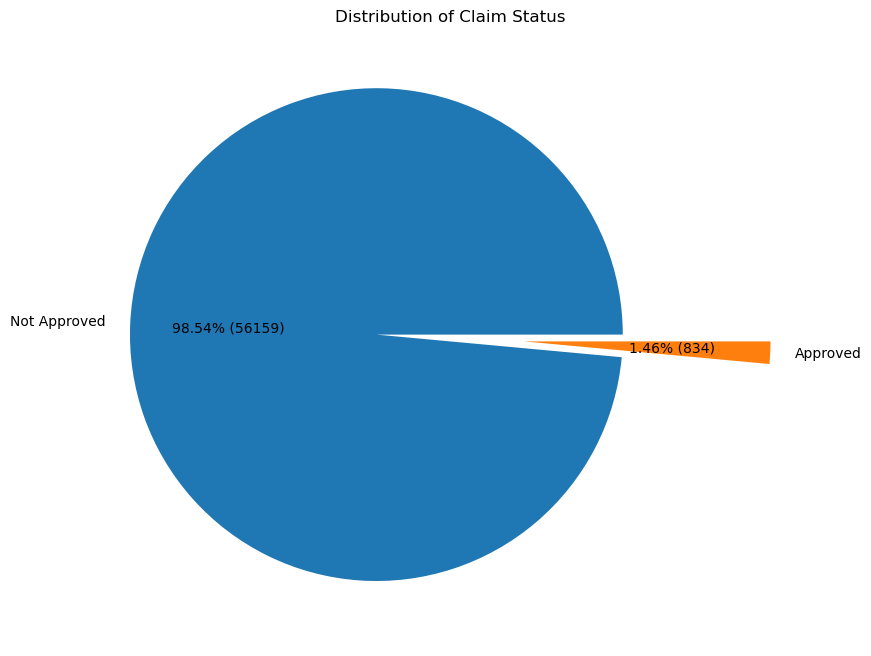

In [ ]:
# Univariate Analysis (Individual Features)
claims = insurance['claim_status'].value_counts()
claims_labels = ['Not Approved', 'Approved']

def autopcts(values):
    def autopct(percentage):
        count = int(round(percentage / 100 * sum(values)))
        return f'{percentage:.2f}% ({count})'
    return autopct

plt.figure(figsize = (12, 8))
plt.pie(claims, labels = claims_labels, colors = sns.color_palette('viridis').reverse(), explode = [0.3, 0.3], autopct = autopcts(claims.values))
plt.title('Distribution of Claim Status')
plt.show()

### Relations between Continuous Variables

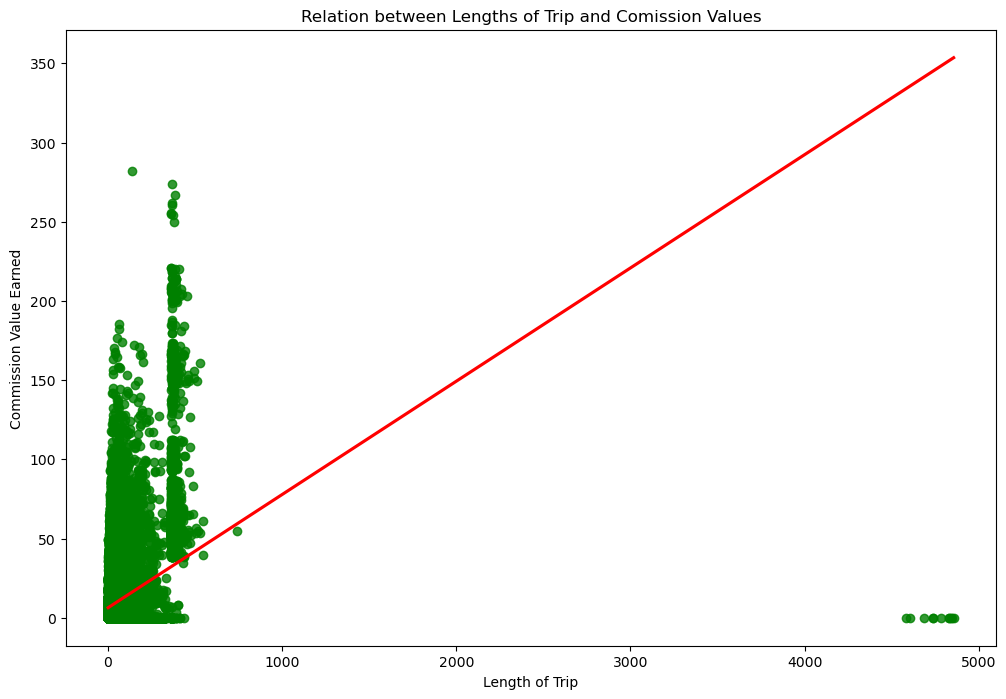

In [507]:
plt.figure(figsize = (12, 8))
sns.regplot(x = 'trip_length',
            y = 'reward',
            data = insurance,
            scatter_kws = {'color': 'green'}, 
            line_kws = {'color': 'red'},
            ci = None)
plt.title('Relation between Lengths of Trip and Comission Values')
plt.xlabel('Length of Trip')
plt.ylabel('Commission Value Earned')
plt.show()

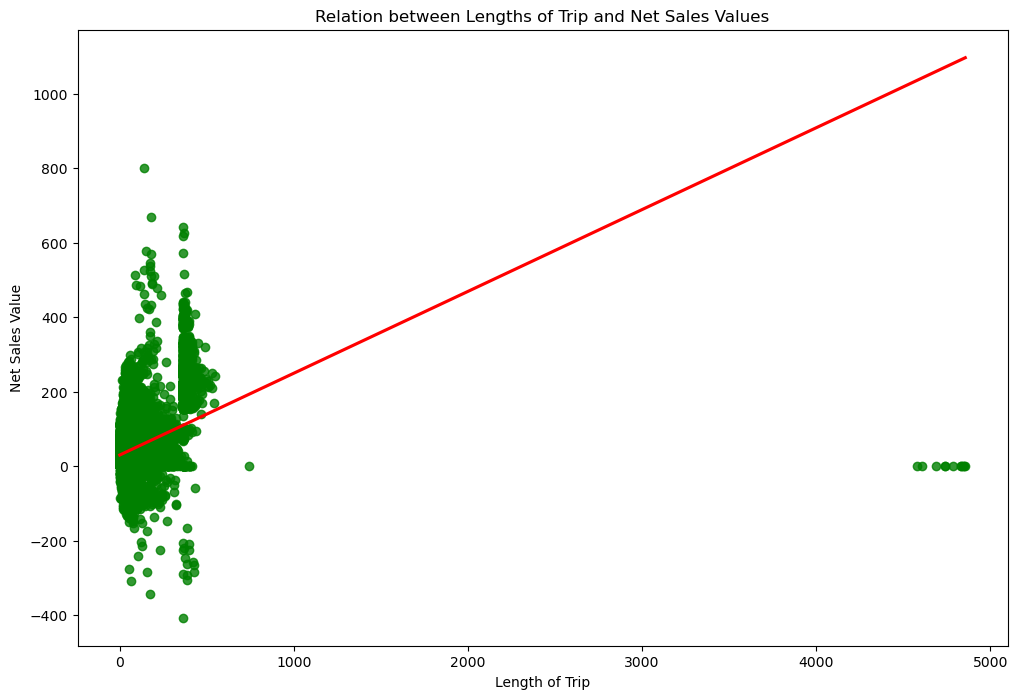

In [508]:
plt.figure(figsize = (12, 8))
sns.regplot(x = 'trip_length',
            y = 'revenue',
            data = insurance,
            scatter_kws = {'color': 'green'}, 
            line_kws = {'color': 'red'},
            ci = None)
plt.title('Relation between Lengths of Trip and Net Sales Values')
plt.xlabel('Length of Trip')
plt.ylabel('Net Sales Value')
plt.show()

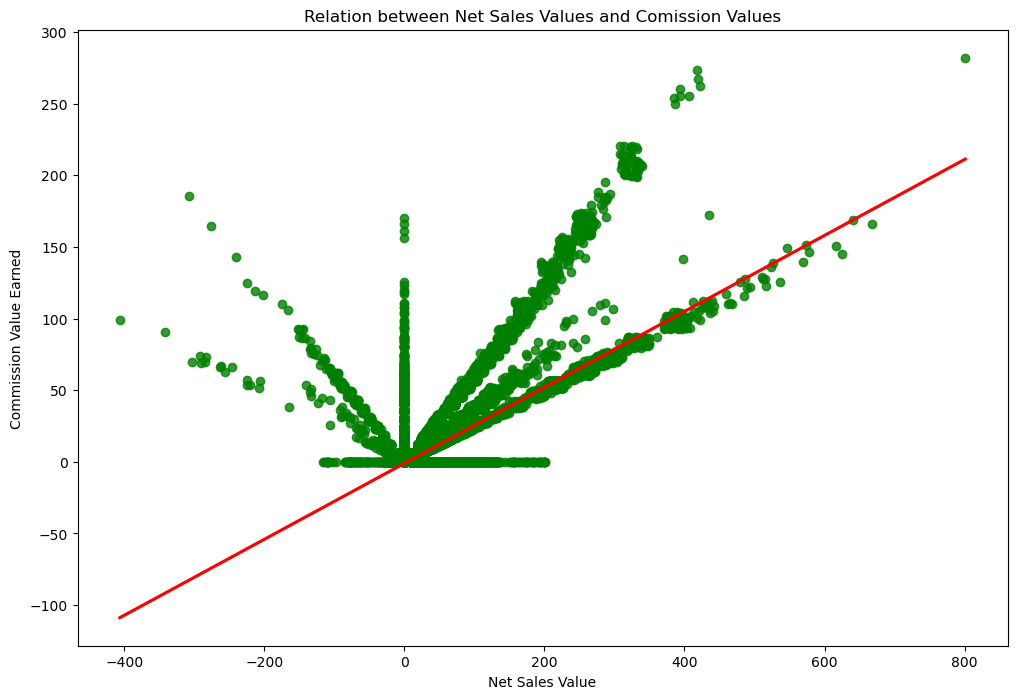

In [509]:
plt.figure(figsize = (12, 8))
sns.regplot(x = 'revenue',
            y = 'reward',
            data = insurance,
            scatter_kws = {'color': 'green'}, 
            line_kws = {'color': 'red'},
            ci = None)
plt.title('Relation between Net Sales Values and Comission Values')
plt.xlabel('Net Sales Value')
plt.ylabel('Commission Value Earned')
plt.show()

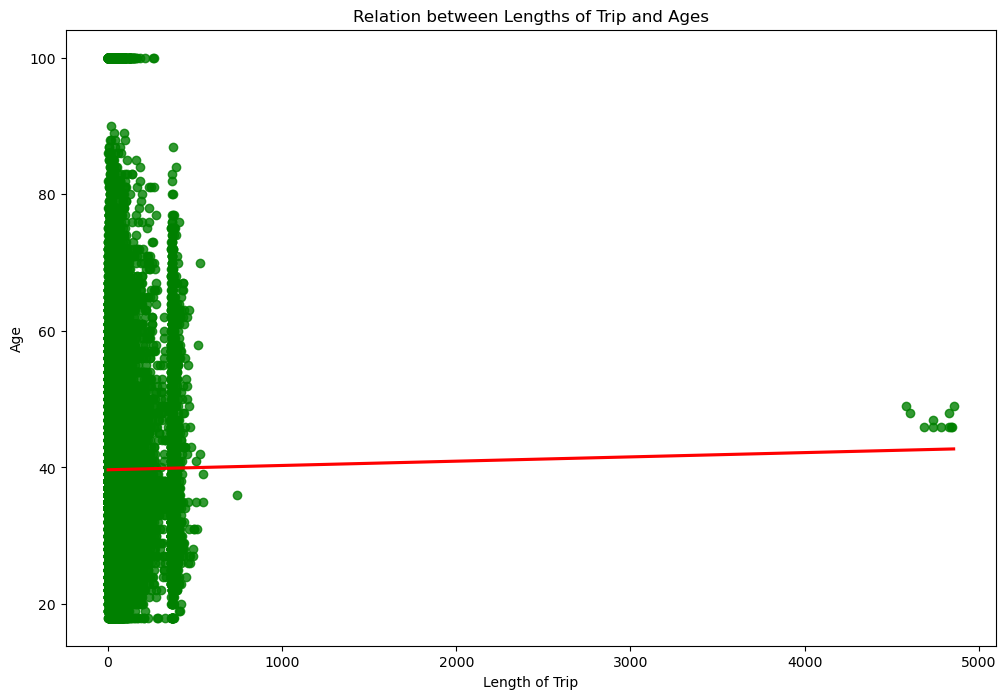

In [510]:
plt.figure(figsize = (12, 8))
sns.regplot(x = 'trip_length',
            y = 'person_age',
            data = insurance,
            scatter_kws = {'color': 'green'}, 
            line_kws = {'color': 'red'},
            ci = None)
plt.title('Relation between Lengths of Trip and Ages')
plt.xlabel('Length of Trip')
plt.ylabel('Age')
plt.show()

### Bivariate Analysis with Target (trip_length)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


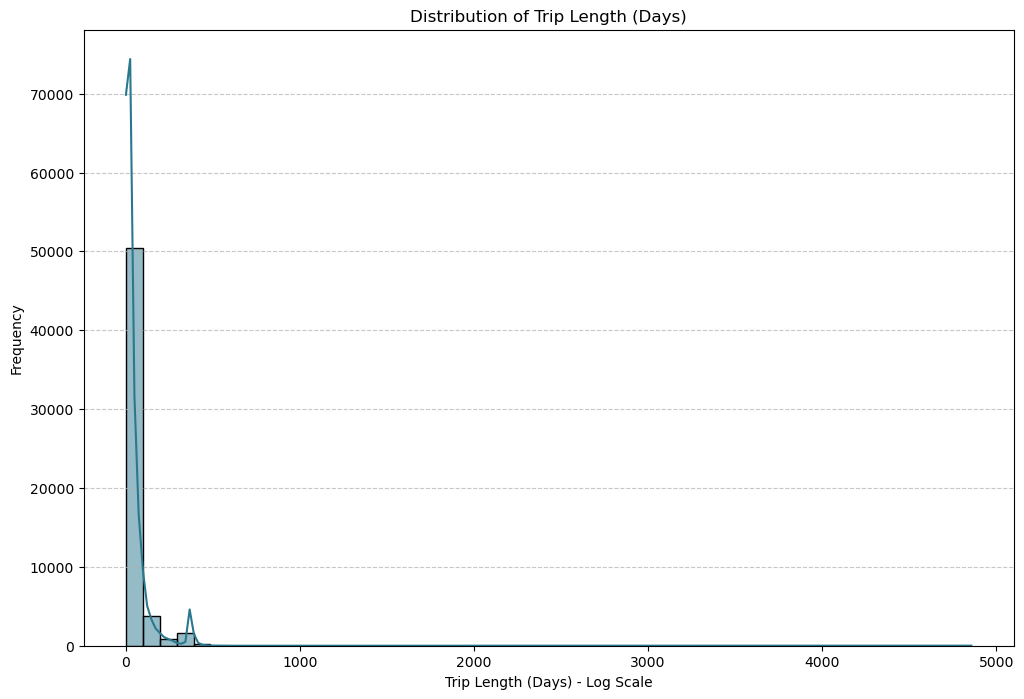

In [ ]:
plt.figure(figsize = (12, 8))
sns.histplot(
    data = insurance,
    x = 'trip_length',
    bins = 50, 
    kde = True, 
    color = '#2A788EFF',
    log_scale = False 
)
plt.title('Distribution of Trip Length (Days)')
plt.xlabel('Trip Length (Days) - Log Scale')
plt.ylabel('Frequency')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


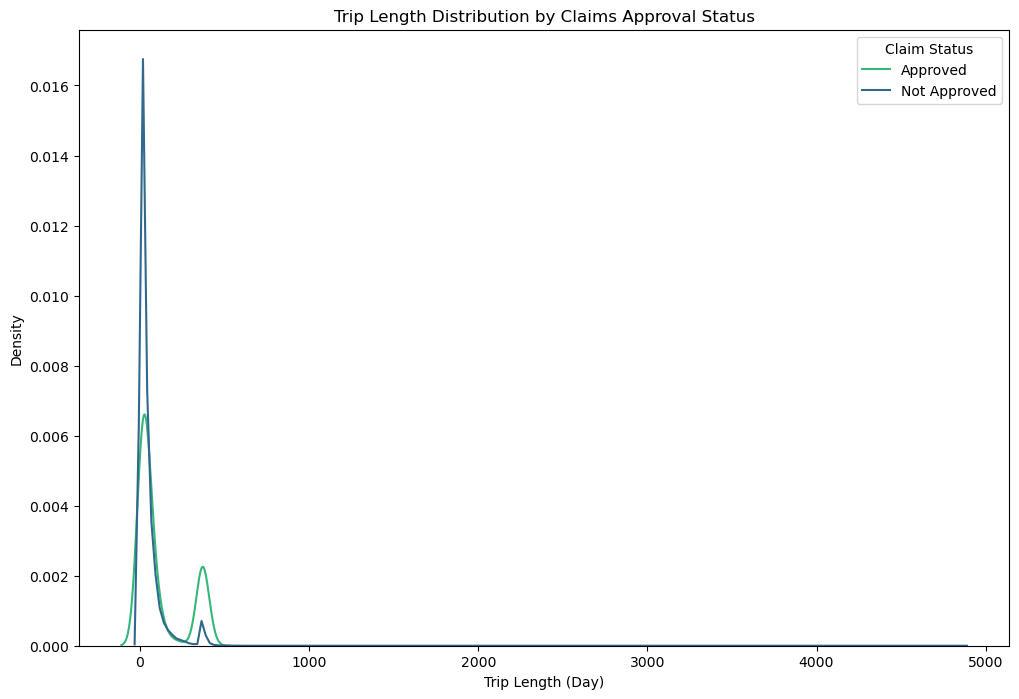

In [512]:
plt.figure(figsize = (12, 8))
sns.kdeplot(data = insurance, hue = 'claim_status', x = 'trip_length', common_norm = False, palette = 'viridis')
plt.title('Trip Length Distribution by Claims Approval Status')
plt.xlabel('Trip Length (Day)')
plt.ylabel('Density')
plt.legend(title = 'Claim Status', labels = ['Approved', 'Not Approved'])
plt.show()

### Bivariate Analysis with Target (agent_id)

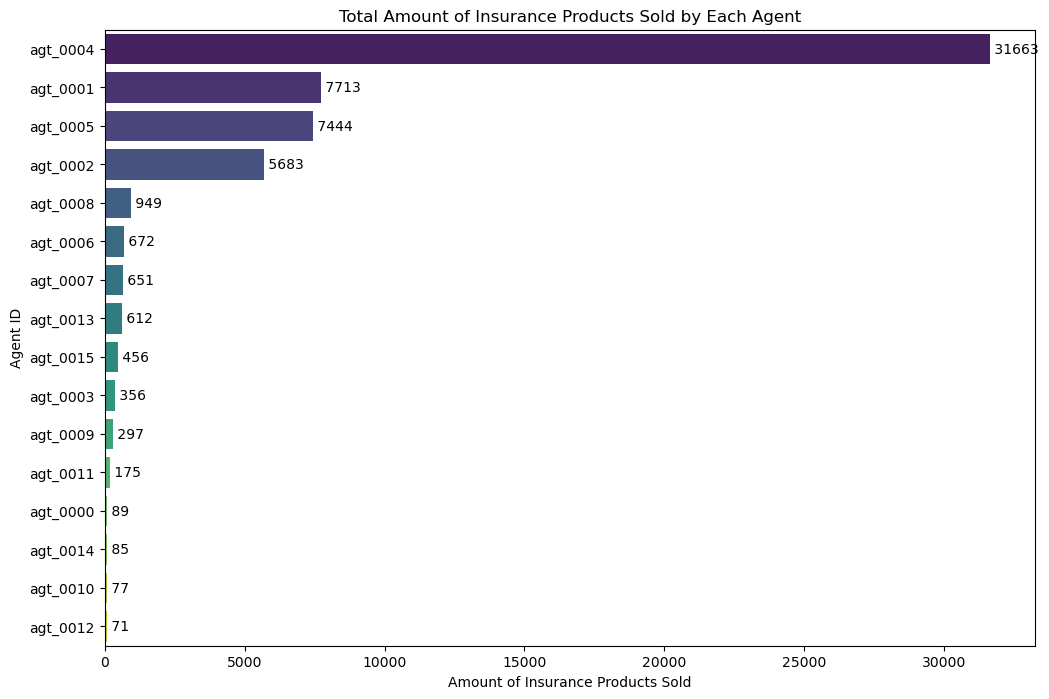

In [513]:
plt.figure(figsize = (12, 8))
sns.barplot(x = insurance['agent_id'].value_counts().values, y = insurance['agent_id'].value_counts().index, palette = 'viridis')
plt.ylabel('Agent ID')
plt.xlabel('Amount of Insurance Products Sold')
plt.title('Total Amount of Insurance Products Sold by Each Agent')

for index, value in enumerate(insurance['agent_id'].value_counts()):
    plt.text(value + 0.1, index, f'{value: .0f}', va = 'center')

plt.show()

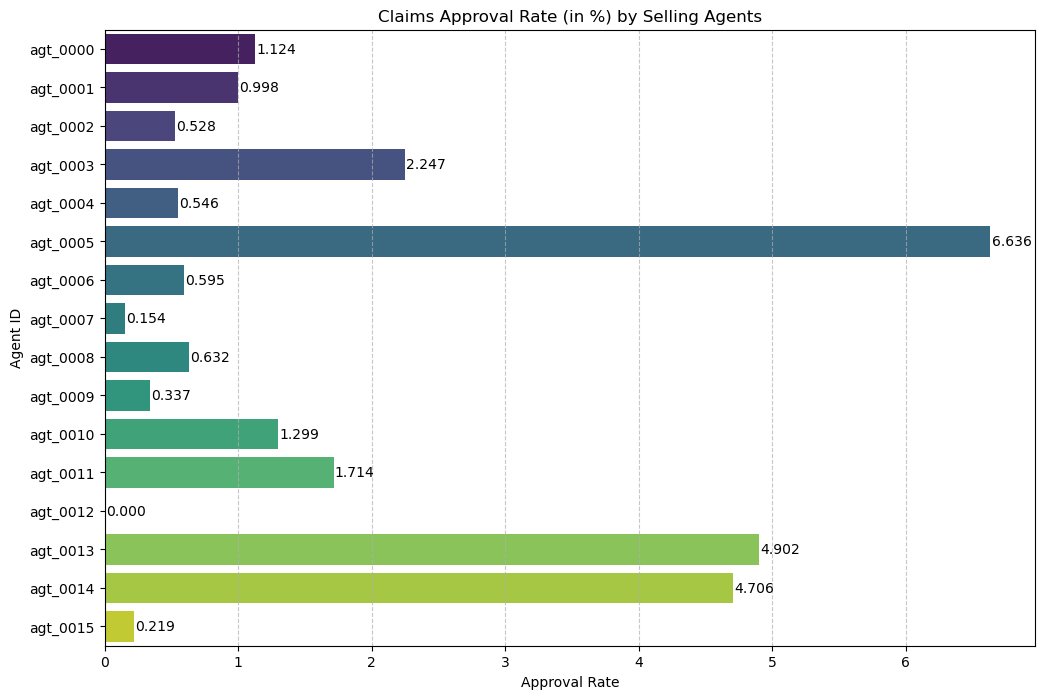

In [514]:
# Bivariate Analysis with Target (claim_status)
agent_approval = insurance.groupby('agent_id')['claim_status'].agg(
    total_claims = 'count',
    approved_claims = 'sum'
).reset_index()

agent_approval['approval_rate'] = agent_approval['approved_claims'] / agent_approval['total_claims'] * 100

plt.figure(figsize = (12, 8))
sns.barplot(data = agent_approval, x = 'approval_rate', y = 'agent_id', palette = 'viridis')
plt.title('Claims Approval Rate (in %) by Selling Agents')
plt.xlabel('Approval Rate')
plt.ylabel('Agent ID')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(agent_approval['approval_rate']):
    plt.text(value + 0.01, index, f'{value:.3f}', va = 'center')

plt.show()

### Bivariate Analysis with Target (entity_a)

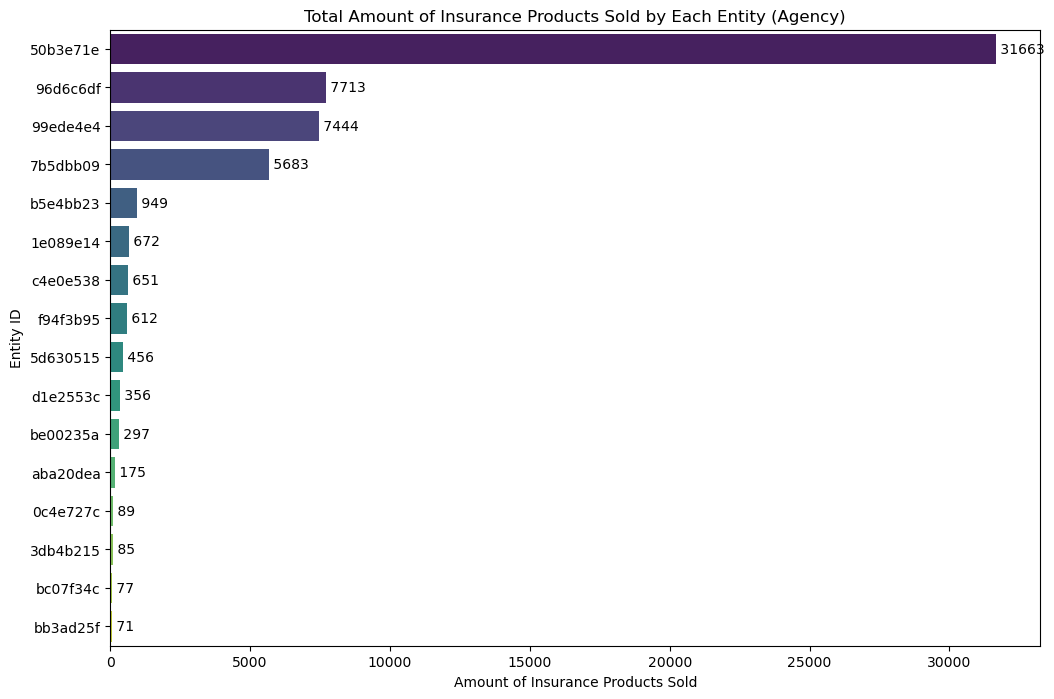

In [515]:
plt.figure(figsize = (12, 8))
sns.barplot(x = insurance['entity_a'].value_counts().values, y = insurance['entity_a'].value_counts().index, palette = 'viridis')
plt.ylabel('Entity ID')
plt.xlabel('Amount of Insurance Products Sold')
plt.title('Total Amount of Insurance Products Sold by Each Entity (Agency)')

for index, value in enumerate(insurance['entity_a'].value_counts()):
    plt.text(value + 0.1, index, f'{value: .0f}', va = 'center')

plt.show()

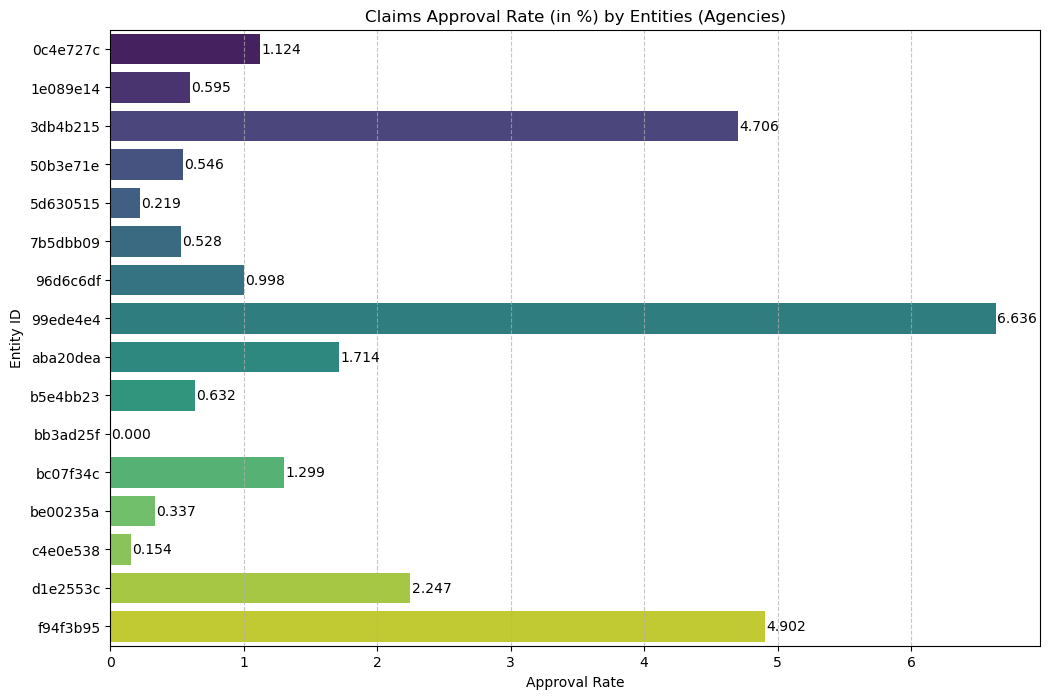

In [516]:
entity_approval = insurance.groupby('entity_a')['claim_status'].agg(
    total_claims = 'count',
    approved_claims = 'sum'
).reset_index()

entity_approval['approval_rate'] = entity_approval['approved_claims'] / entity_approval['total_claims'] * 100

plt.figure(figsize = (12, 8))
sns.barplot(data = entity_approval, x = 'approval_rate', y = 'entity_a', palette = 'viridis')
plt.title('Claims Approval Rate (in %) by Entities (Agencies)')
plt.xlabel('Approval Rate')
plt.ylabel('Entity ID')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(entity_approval['approval_rate']):
    plt.text(value + 0.01, index, f'{value:.3f}', va = 'center')

plt.show() # suspecting agent_id and eneity_a is the same

### Bivariate Analysis with Target (entity_type)

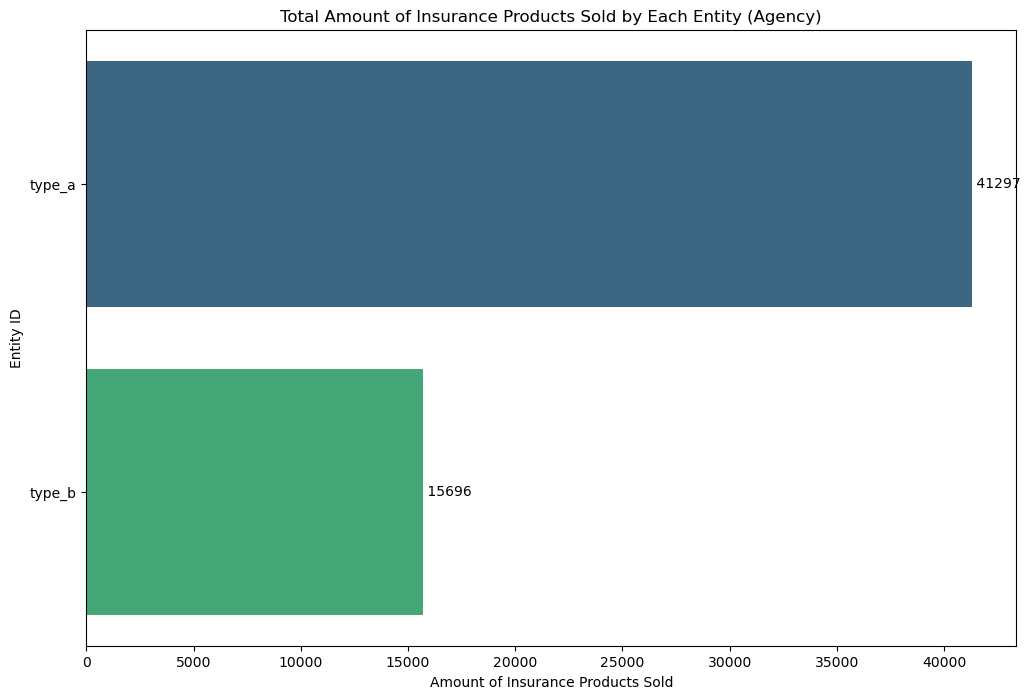

In [518]:
plt.figure(figsize = (12, 8))
sns.barplot(x = insurance['entity_type'].value_counts().values, y = insurance['entity_type'].value_counts().index, palette = 'viridis')
plt.ylabel('Entity ID')
plt.xlabel('Amount of Insurance Products Sold')
plt.title('Total Amount of Insurance Products Sold by Each Entity (Agency)')

for index, value in enumerate(insurance['entity_type'].value_counts()):
    plt.text(value + 0.1, index, f'{value: .0f}', va = 'center')

plt.show()

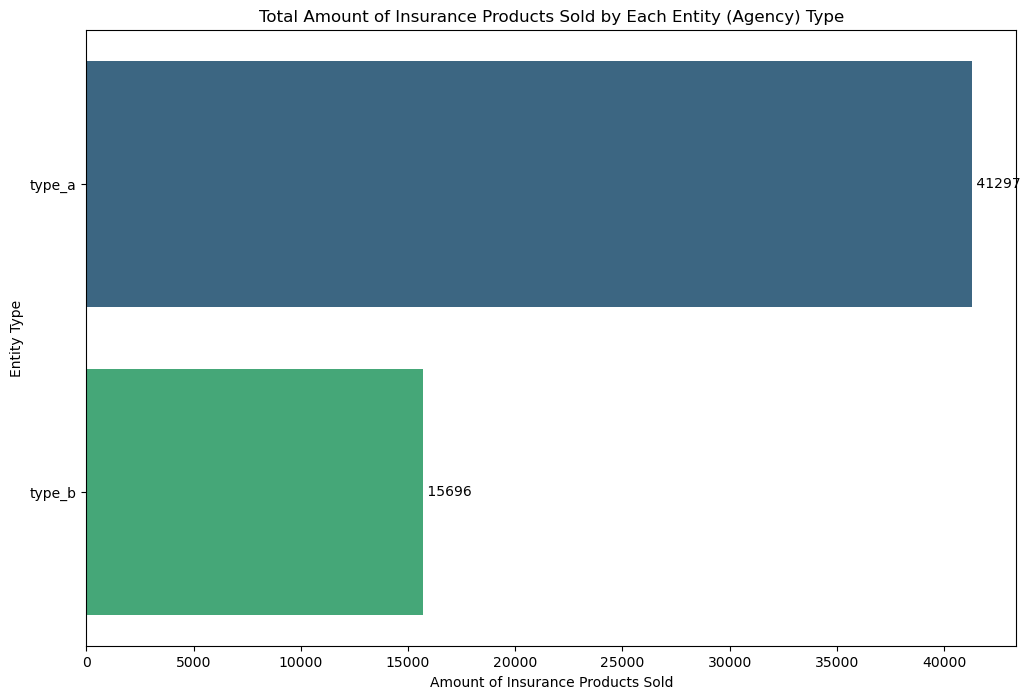

In [ ]:
plt.figure(figsize = (12, 8))
sns.barplot(x = insurance['entity_type'].value_counts().values, y = insurance['entity_type'].value_counts().index, palette = 'viridis')
plt.ylabel('Entity Type')
plt.xlabel('Amount of Insurance Products Sold')
plt.title('Total Amount of Insurance Products Sold by Each Entity (Agency) Type')

for index, value in enumerate(insurance['entity_type'].value_counts()):
    plt.text(value + 0.1, index, f'{value: .0f}', va = 'center')

plt.show()

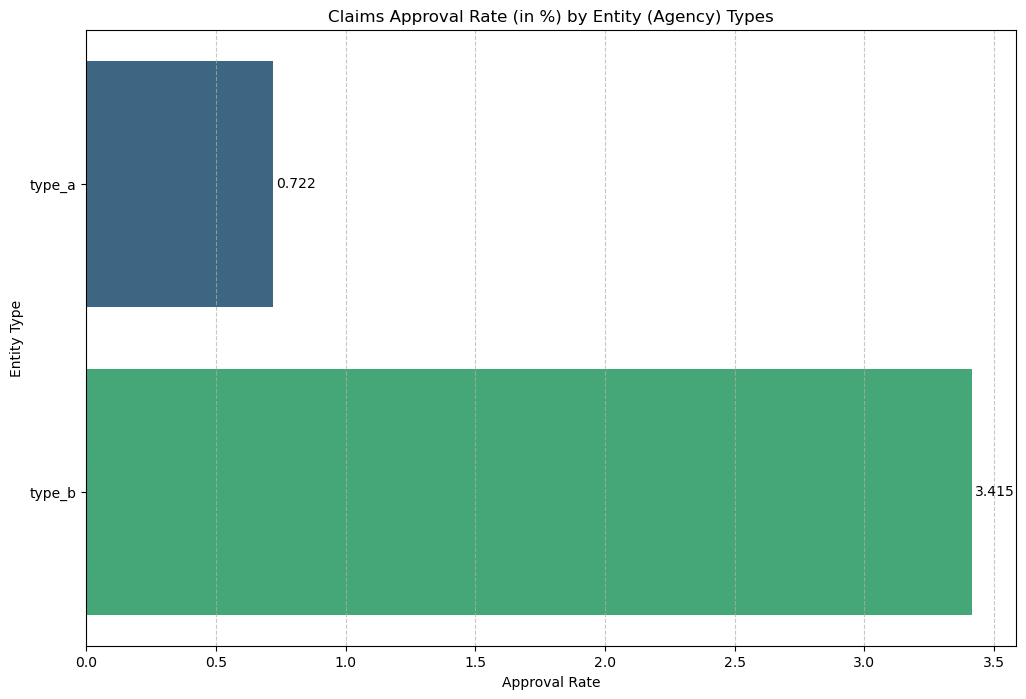

In [519]:
entity_approval = insurance.groupby('entity_type')['claim_status'].agg(
    total_claims = 'count',
    approved_claims = 'sum'
).reset_index()

entity_approval['approval_rate'] = entity_approval['approved_claims'] / entity_approval['total_claims'] * 100

plt.figure(figsize = (12, 8))
sns.barplot(data = entity_approval, x = 'approval_rate', y = 'entity_type', palette = 'viridis')
plt.title('Claims Approval Rate (in %) by Entity (Agency) Types')
plt.xlabel('Approval Rate')
plt.ylabel('Entity Type')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(entity_approval['approval_rate']):
    plt.text(value + 0.01, index, f'{value:.3f}', va = 'center')

plt.show()

### Bivariate Analysis with Target (channel)

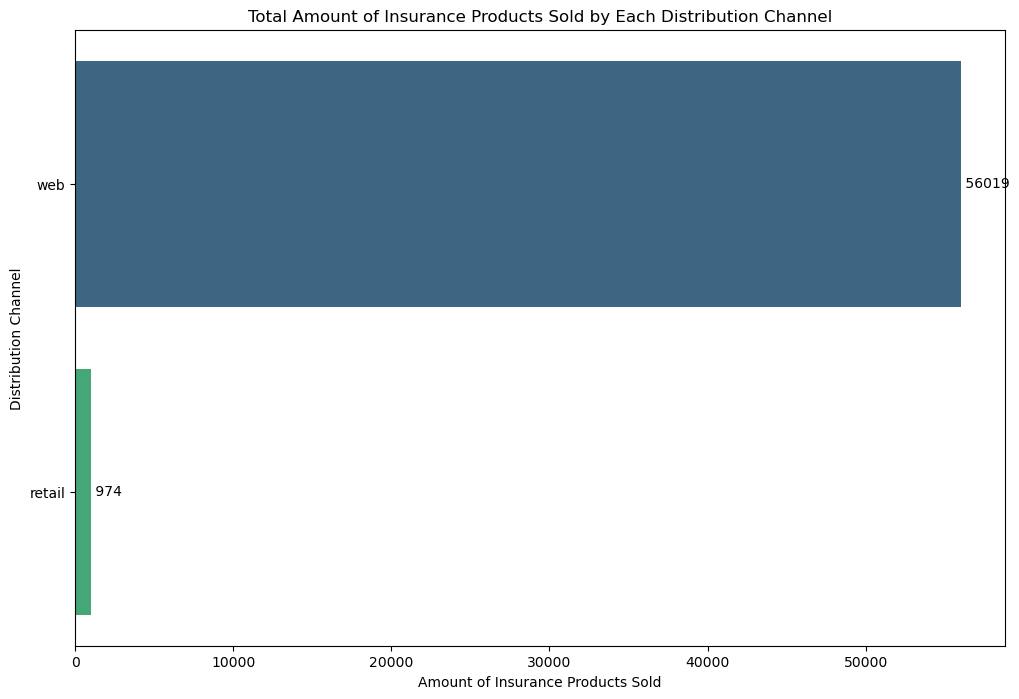

In [520]:
plt.figure(figsize = (12, 8))
sns.barplot(x = insurance['channel'].value_counts().values, y = insurance['channel'].value_counts().index, palette = 'viridis')
plt.ylabel('Distribution Channel')
plt.xlabel('Amount of Insurance Products Sold')
plt.title('Total Amount of Insurance Products Sold by Each Distribution Channel')

for index, value in enumerate(insurance['channel'].value_counts()):
    plt.text(value + 0.1, index, f'{value: .0f}', va = 'center')

plt.show()

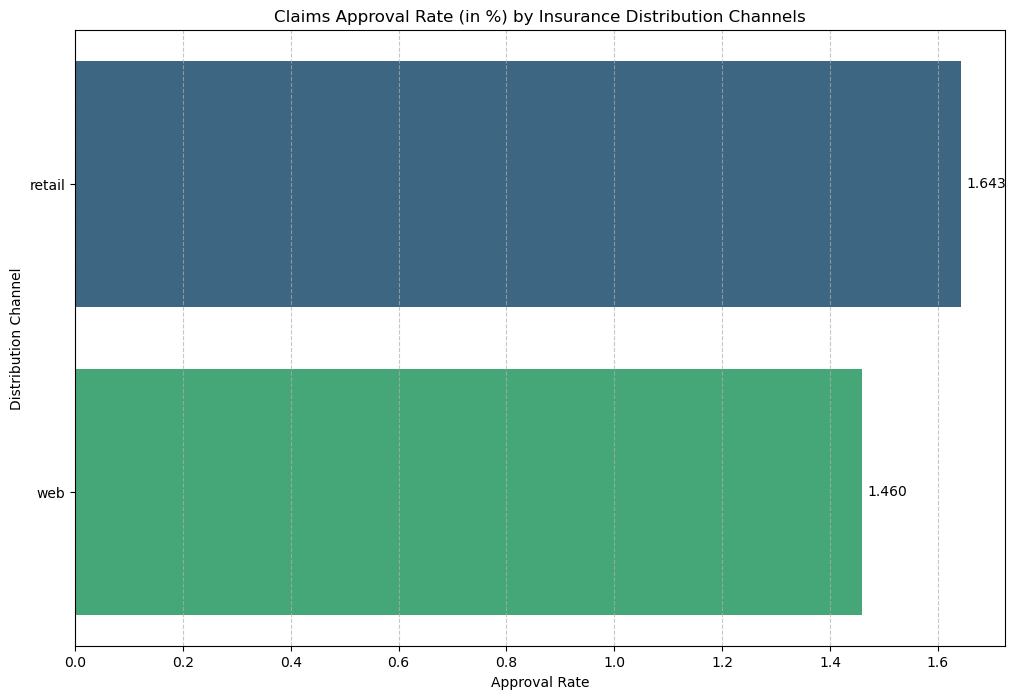

In [521]:
channel_approval = insurance.groupby('channel')['claim_status'].agg(
    total_claims = 'count',
    approved_claims = 'sum'
).reset_index()

channel_approval['approval_rate'] = channel_approval['approved_claims'] / channel_approval['total_claims'] * 100

plt.figure(figsize = (12, 8))
sns.barplot(data = channel_approval, x = 'approval_rate', y = 'channel', palette = 'viridis')
plt.title('Claims Approval Rate (in %) by Insurance Distribution Channels')
plt.xlabel('Approval Rate')
plt.ylabel('Distribution Channel')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(channel_approval['approval_rate']):
    plt.text(value + 0.01, index, f'{value:.3f}', va = 'center')

plt.show()

### Bivariate Analysis with Target (location)

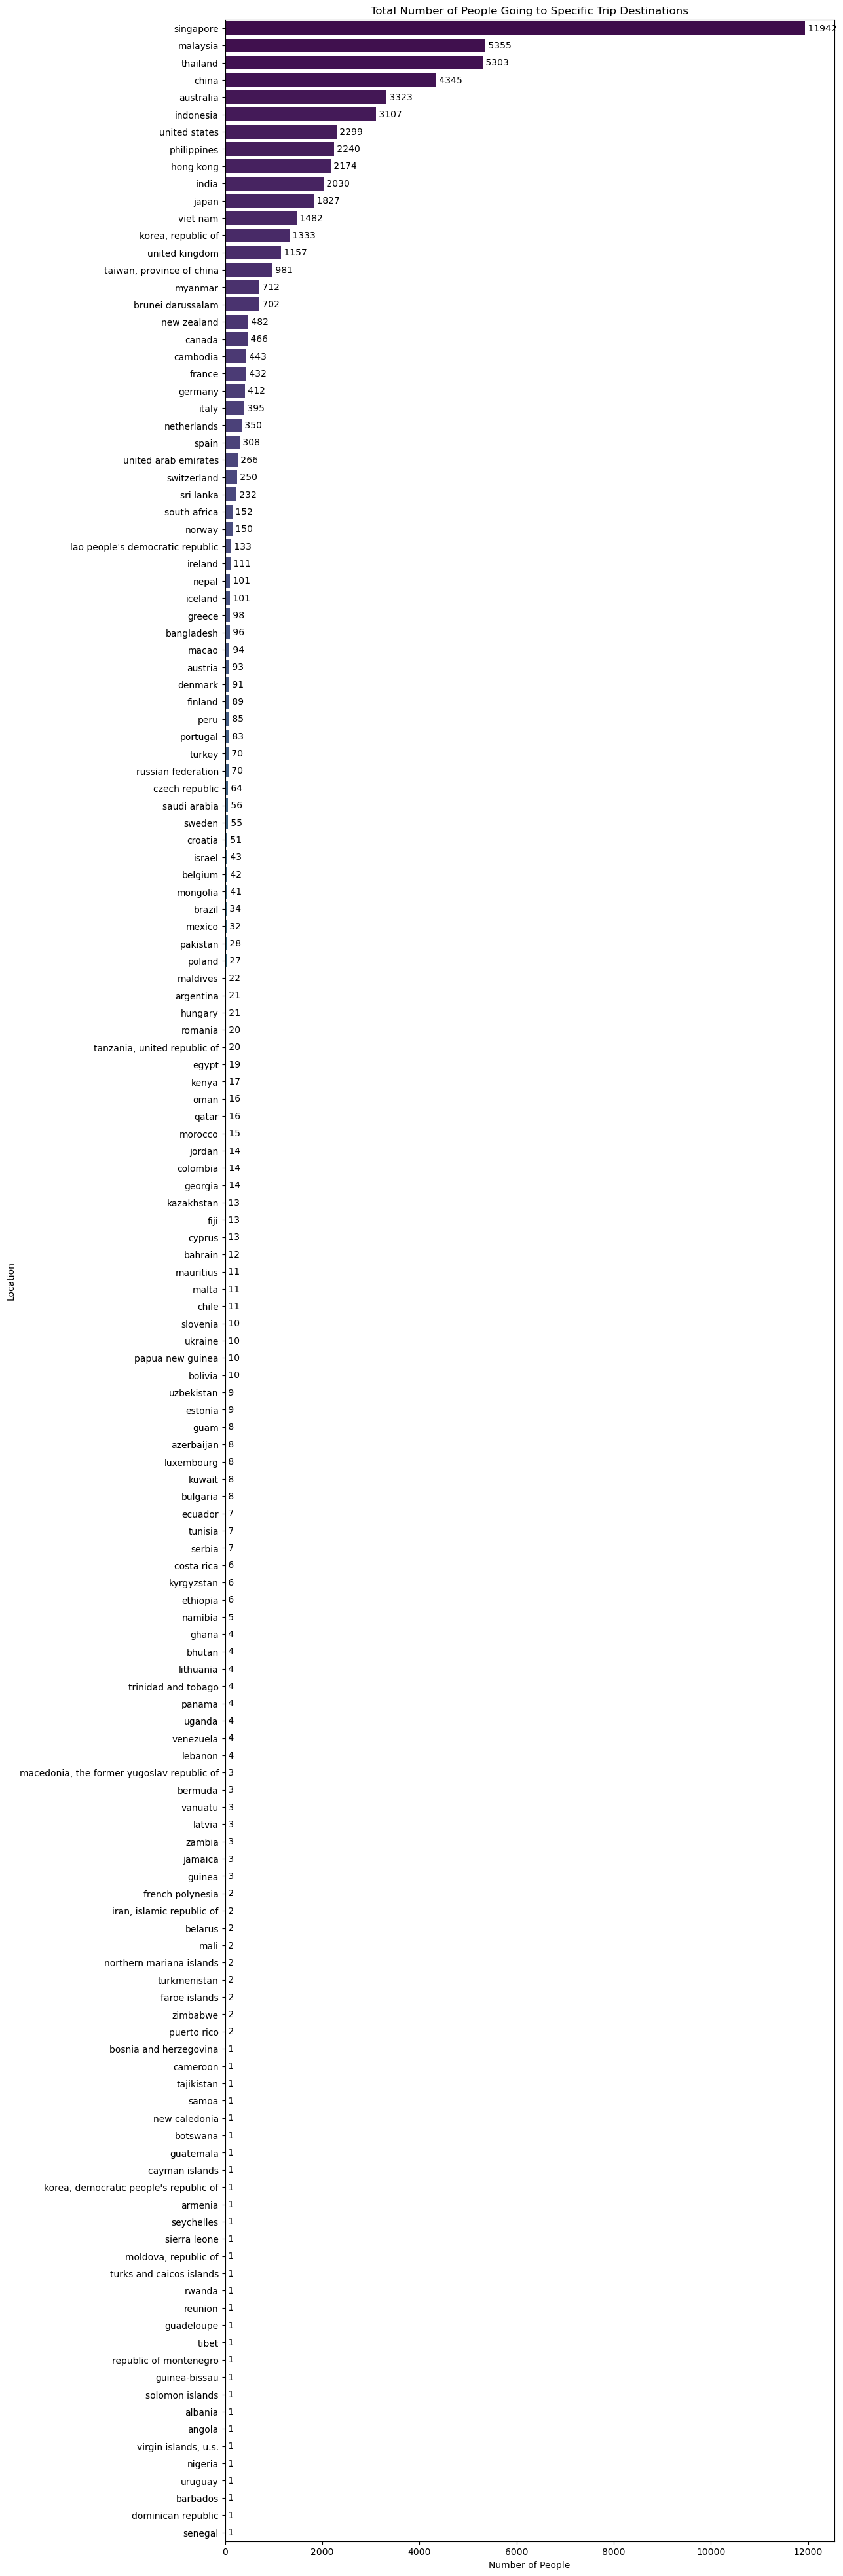

In [522]:
plt.figure(figsize = (12, 50))
sns.barplot(x = insurance['location'].value_counts().values, y = insurance['location'].value_counts().index, palette = 'viridis')
plt.ylabel('Location')
plt.xlabel('Number of People')
plt.title('Total Number of People Going to Specific Trip Destinations')

for index, value in enumerate(insurance['location'].value_counts()):
    plt.text(value + 0.1, index, f'{value: .0f}', va = 'center')

plt.show()

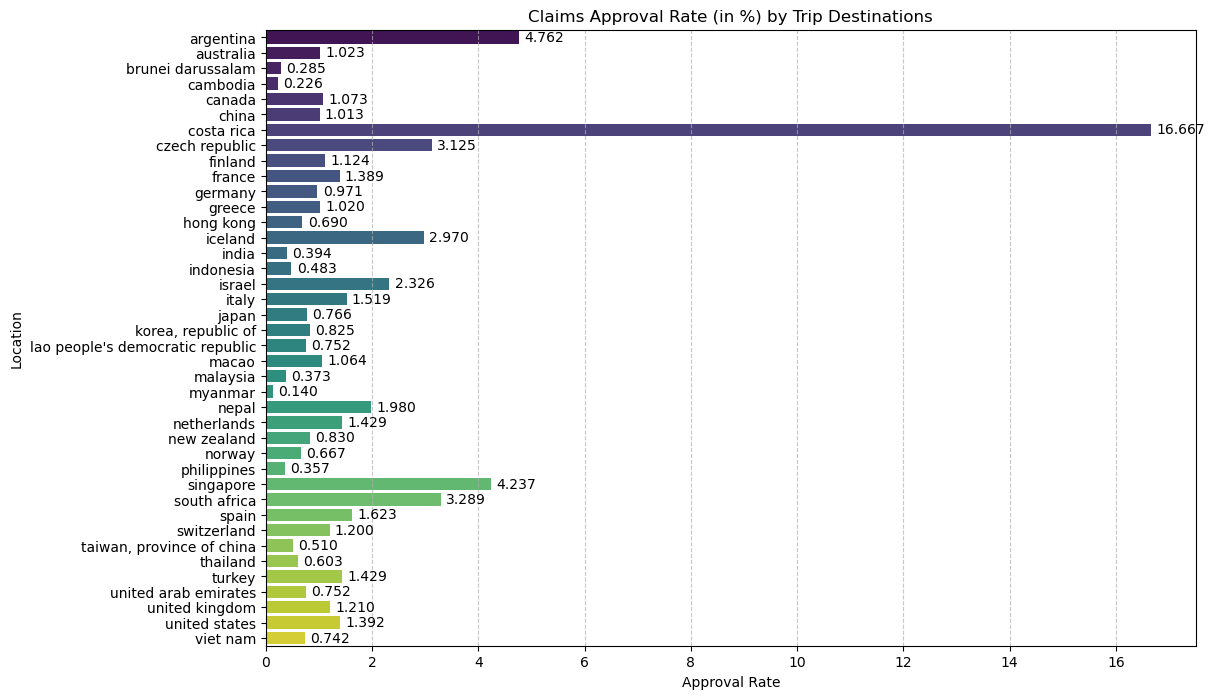

In [ ]:
location_approval = insurance.groupby('location')['claim_status'].agg(
    total_claims='count',
    approved_claims='sum'
).reset_index()

location_approval['approval_rate'] = location_approval['approved_claims'] / location_approval['total_claims'] * 100
location_approval = location_approval[location_approval['approved_claims'] > 0]

plt.figure(figsize =(12, 8))
sns.barplot(data = location_approval, x = 'approval_rate', y = 'location', palette = 'viridis')

plt.title('Claims Approval Rate (in %) by Trip Destinations')
plt.xlabel('Approval Rate')
plt.ylabel('Location')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(location_approval['approval_rate']):
    plt.text(value + 0.1, index, f'{value:.3f}', va = 'center')

plt.show()

# High claim rate on small sample = statistical noise
# Costa Rica has 6 observations → don’t treat it as a strong signal

### Bivariate Analysis with Target (product_id)

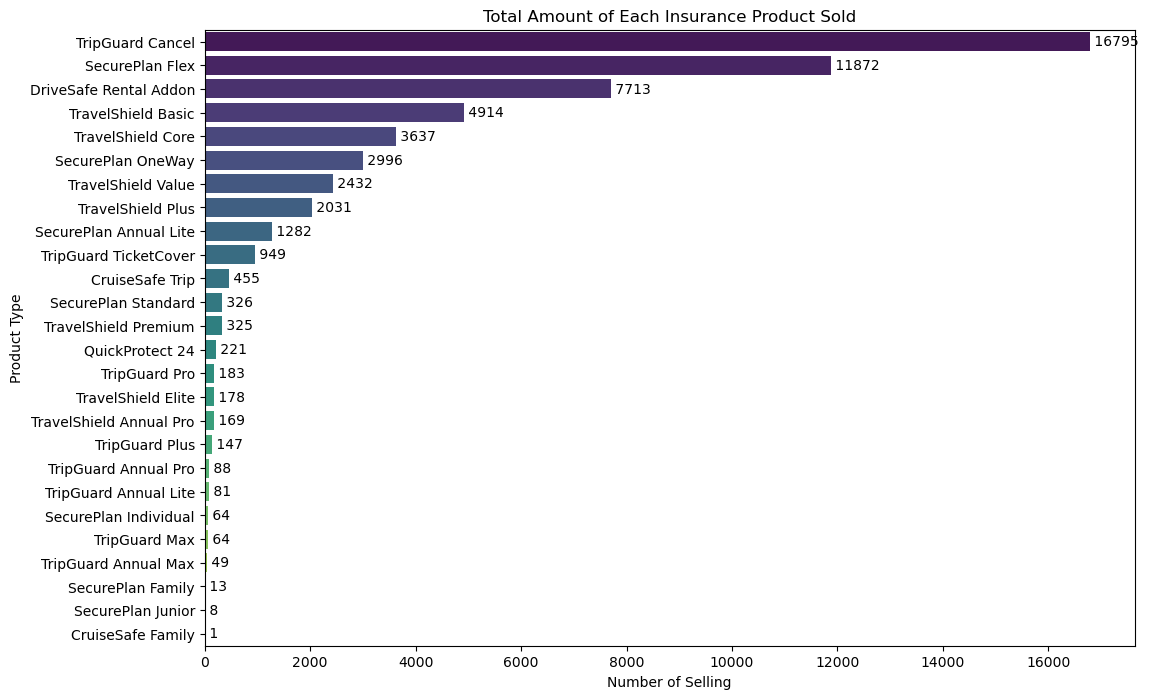

In [524]:
plt.figure(figsize = (12, 8))
sns.barplot(x = insurance['product_id'].value_counts().values, y = insurance['product_id'].value_counts().index, palette = 'viridis')
plt.ylabel('Product Type')
plt.xlabel('Number of Selling')
plt.title('Total Amount of Each Insurance Product Sold')

for index, value in enumerate(insurance['product_id'].value_counts()):
    plt.text(value + 0.1, index, f'{value: .0f}', va = 'center')

plt.show()

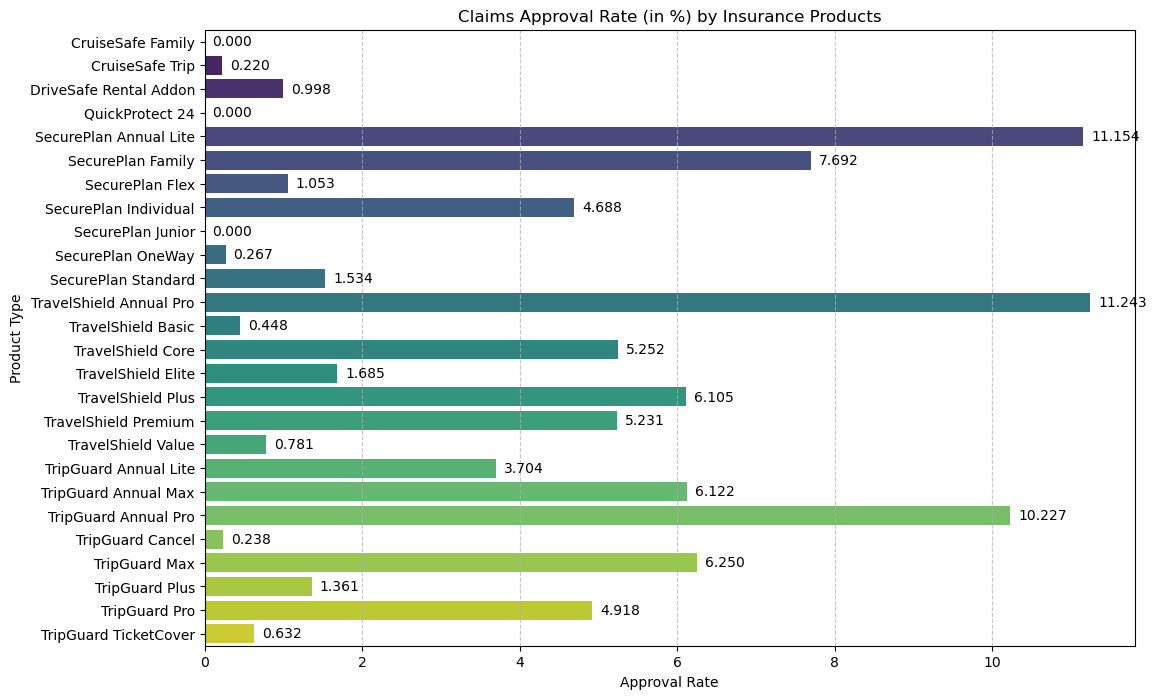

In [525]:
product_approval = insurance.groupby('product_id')['claim_status'].agg(
    total_claims = 'count',
    approved_claims = 'sum'
).reset_index()

product_approval['approval_rate'] = product_approval['approved_claims'] / product_approval['total_claims'] * 100

plt.figure(figsize = (12, 8))
sns.barplot(data = product_approval, x = 'approval_rate', y = 'product_id', palette = 'viridis')
plt.title('Claims Approval Rate (in %) by Insurance Products')
plt.xlabel('Approval Rate')
plt.ylabel('Product Type')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(product_approval['approval_rate']):
    plt.text(value + 0.1, index, f'{value:.3f}', va = 'center')

plt.show()

### Bivariate Analysis with Target (person_gender)

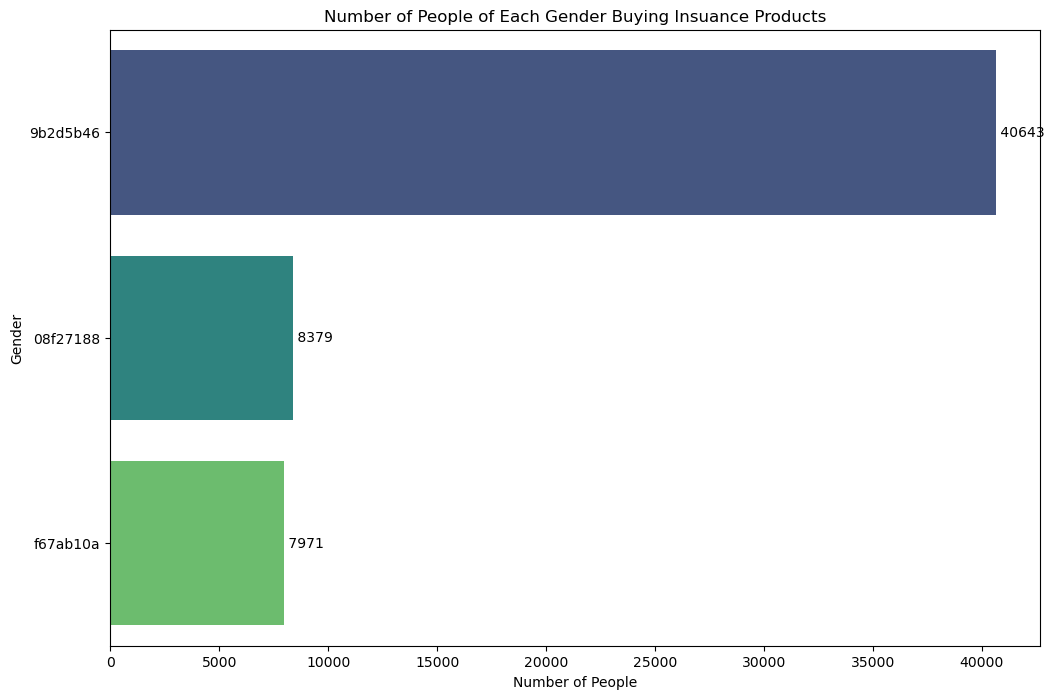

In [526]:
plt.figure(figsize = (12, 8))
sns.barplot(x = insurance['person_gender'].value_counts().values, y = insurance['person_gender'].value_counts().index, palette = 'viridis')
plt.ylabel('Gender')
plt.xlabel('Number of People')
plt.title('Number of People of Each Gender Buying Insuance Products')

for index, value in enumerate(insurance['person_gender'].value_counts()):
    plt.text(value + 0.1, index, f'{value: .0f}', va = 'center')

plt.show()

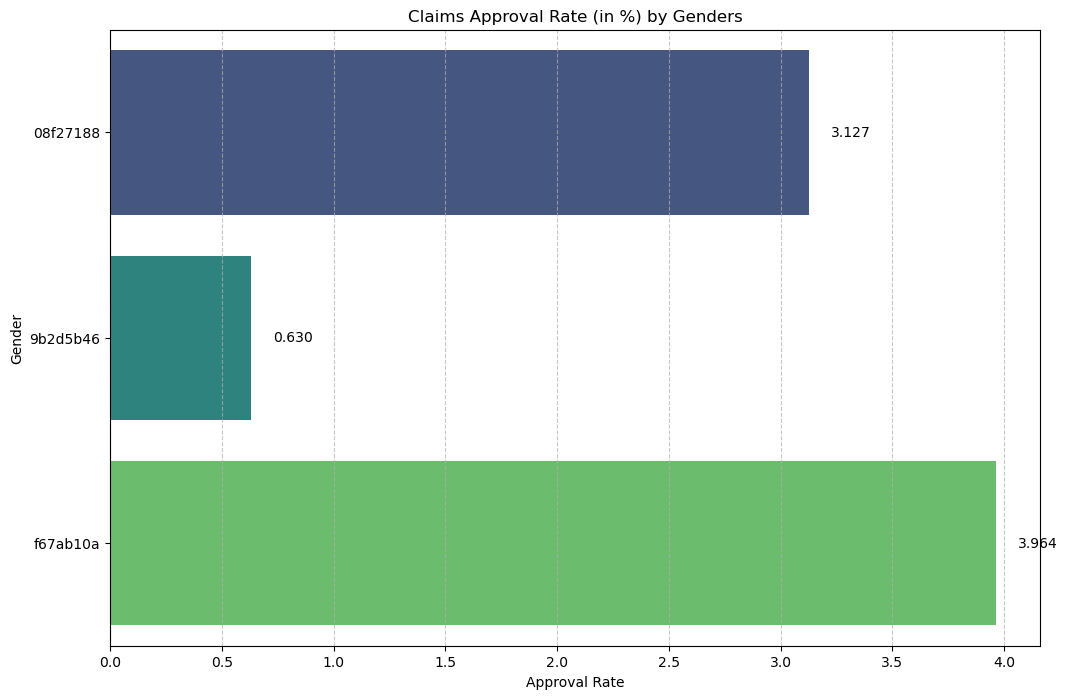

In [527]:
gender_approval = insurance.groupby('person_gender')['claim_status'].agg(
    total_claims = 'count',
    approved_claims = 'sum'
).reset_index()

gender_approval['approval_rate'] = gender_approval['approved_claims'] / gender_approval['total_claims'] * 100

plt.figure(figsize = (12, 8))
sns.barplot(data = gender_approval, x = 'approval_rate', y = 'person_gender', palette = 'viridis')
plt.title('Claims Approval Rate (in %) by Genders')
plt.xlabel('Approval Rate')
plt.ylabel('Gender')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(gender_approval['approval_rate']):
    plt.text(value + 0.1, index, f'{value:.3f}', va = 'center')

plt.show()

### Bivariate Analysis with Target (support_interactions)

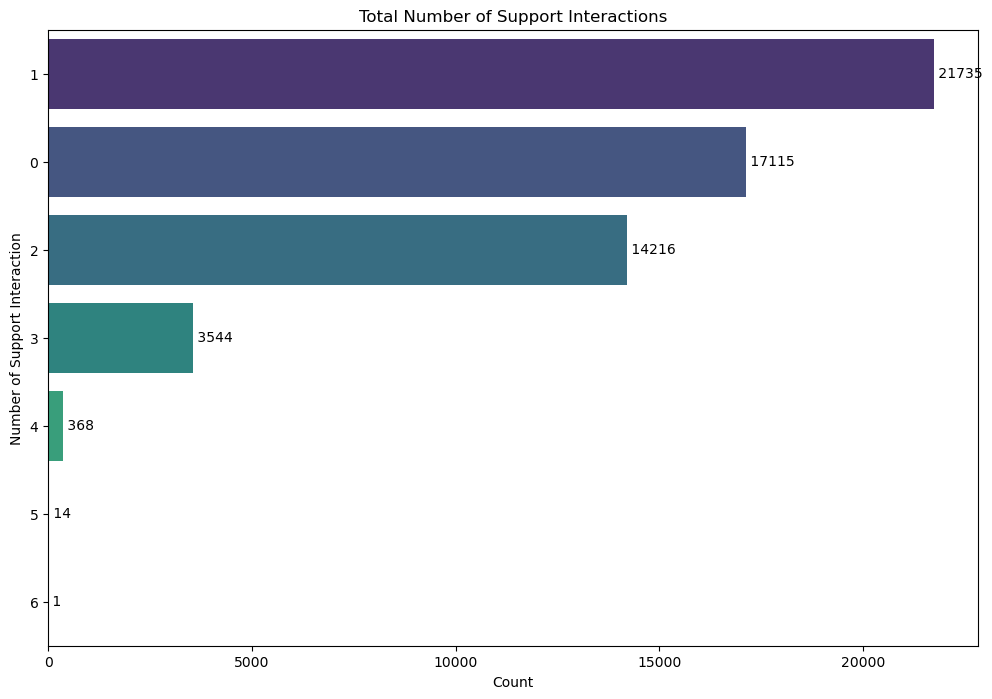

In [528]:
plt.figure(figsize = (12, 8))
sns.barplot(x = insurance['support_interactions'].astype(str).value_counts().values, y = insurance['support_interactions'].astype(str).value_counts().index, palette = 'viridis')
plt.ylabel('Number of Support Interaction')
plt.xlabel('Count')
plt.title('Total Number of Support Interactions')

for index, value in enumerate(insurance['support_interactions'].astype(str).value_counts()):
    plt.text(value + 0.1, index, f'{value: .0f}', va = 'center')

plt.show()

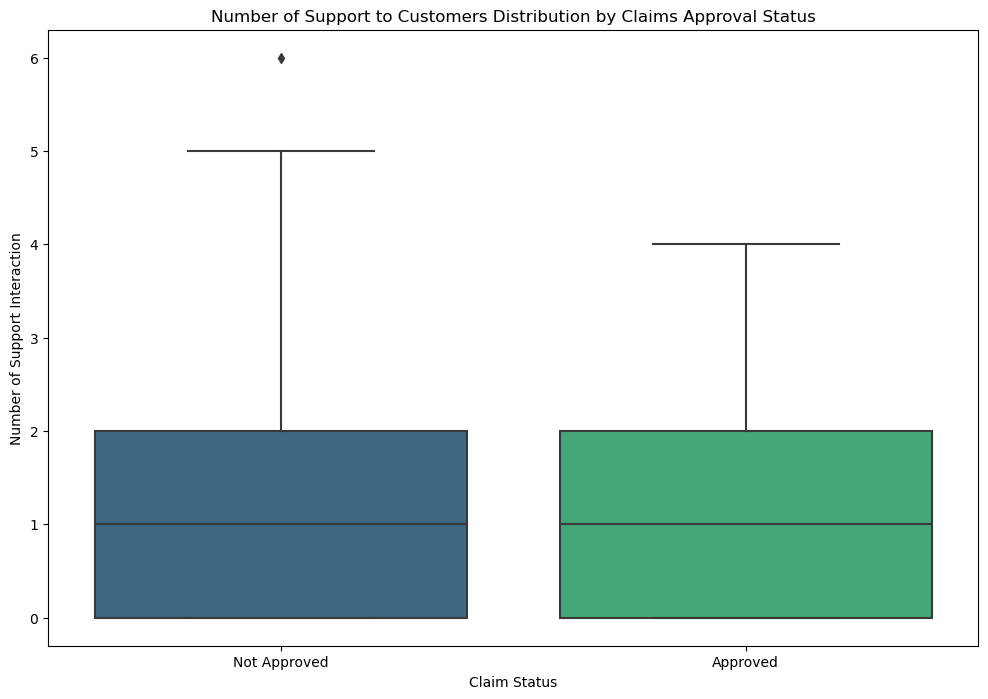

In [529]:
plt.figure(figsize = (12, 8))
sns.boxplot(data = insurance, x = 'claim_status', y = 'support_interactions', palette = 'viridis')
plt.title('Number of Support to Customers Distribution by Claims Approval Status')
plt.xlabel('Claim Status')
plt.ylabel('Number of Support Interaction')
plt.xticks(ticks=[0, 1], labels=['Not Approved', 'Approved'])
plt.show()

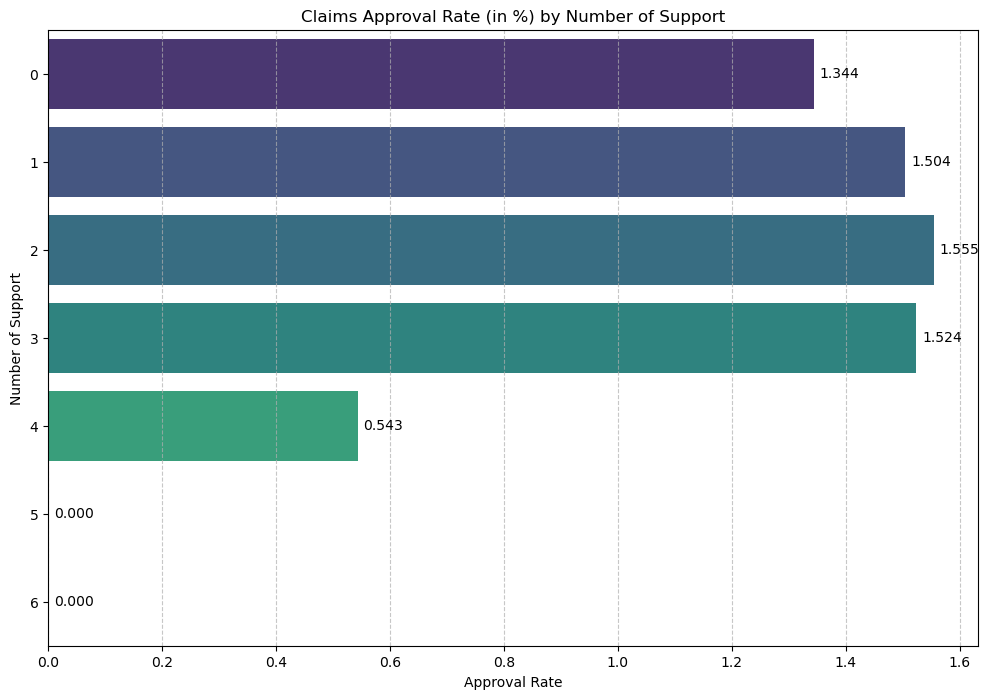

In [530]:
support_approval = insurance.groupby('support_interactions')['claim_status'].agg(
    total_claims = 'count',
    approved_claims = 'sum'
).reset_index()

support_approval['support_interactions'] = support_approval['support_interactions'].astype(str)
support_approval['approval_rate'] = support_approval['approved_claims'] / support_approval['total_claims'] * 100

plt.figure(figsize = (12, 8))
sns.barplot(data = support_approval, x = 'approval_rate', y = 'support_interactions', palette = 'viridis')
plt.title('Claims Approval Rate (in %) by Number of Support')
plt.xlabel('Approval Rate')
plt.ylabel('Number of Support')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)

for index, value in enumerate(support_approval['approval_rate']):
    plt.text(value + 0.01, index, f'{value:.3f}', va = 'center')

plt.show()

### Bivariate Analysis with Target (person_age)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


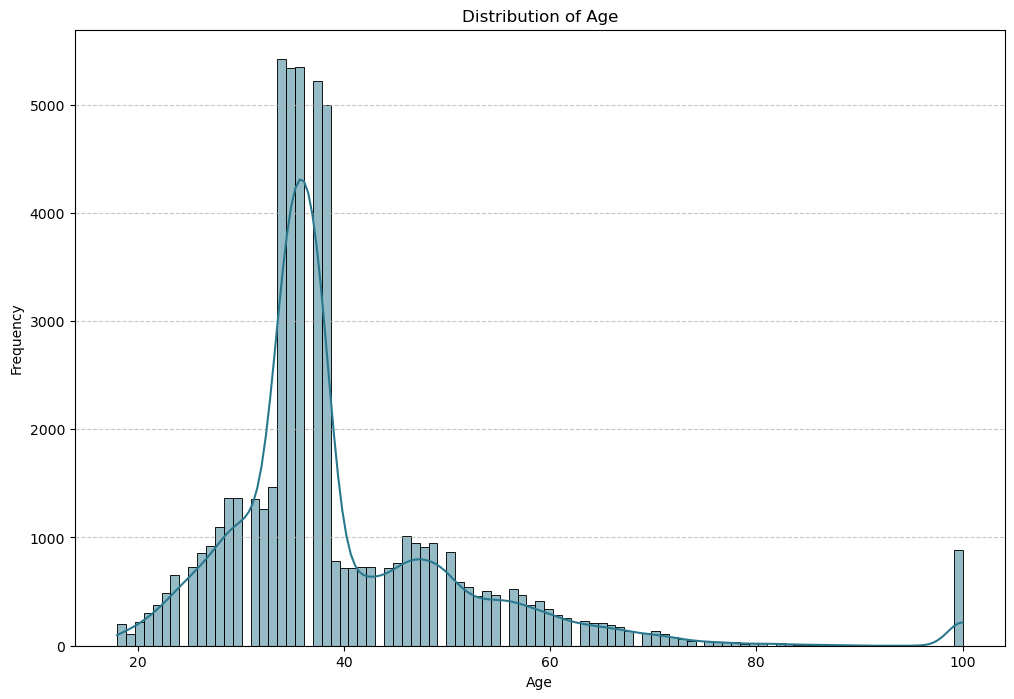

In [531]:
plt.figure(figsize = (12, 8))
sns.histplot(
    data = insurance,
    x = 'person_age',
    bins = 95, 
    kde = True, 
    color = '#2A788EFF',
    log_scale = False
)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

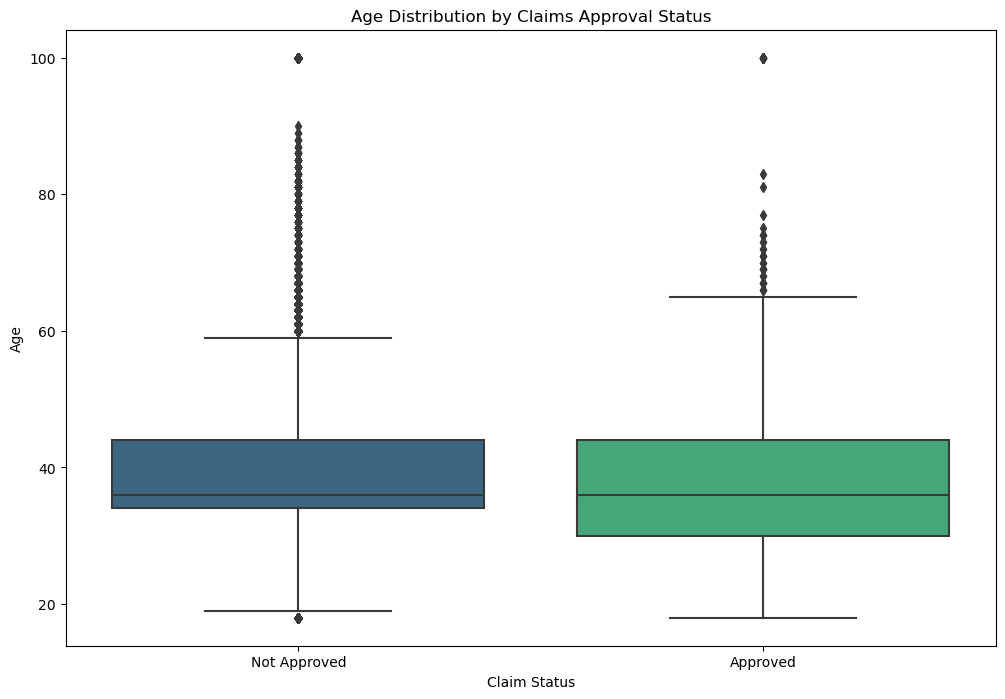

In [532]:
plt.figure(figsize = (12, 8))
sns.boxplot(data = insurance, x = 'claim_status', y = 'person_age', palette = 'viridis')
plt.title('Age Distribution by Claims Approval Status')
plt.xlabel('Claim Status')
plt.ylabel('Age')
plt.xticks(ticks=[0, 1], labels=['Not Approved', 'Approved'])
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


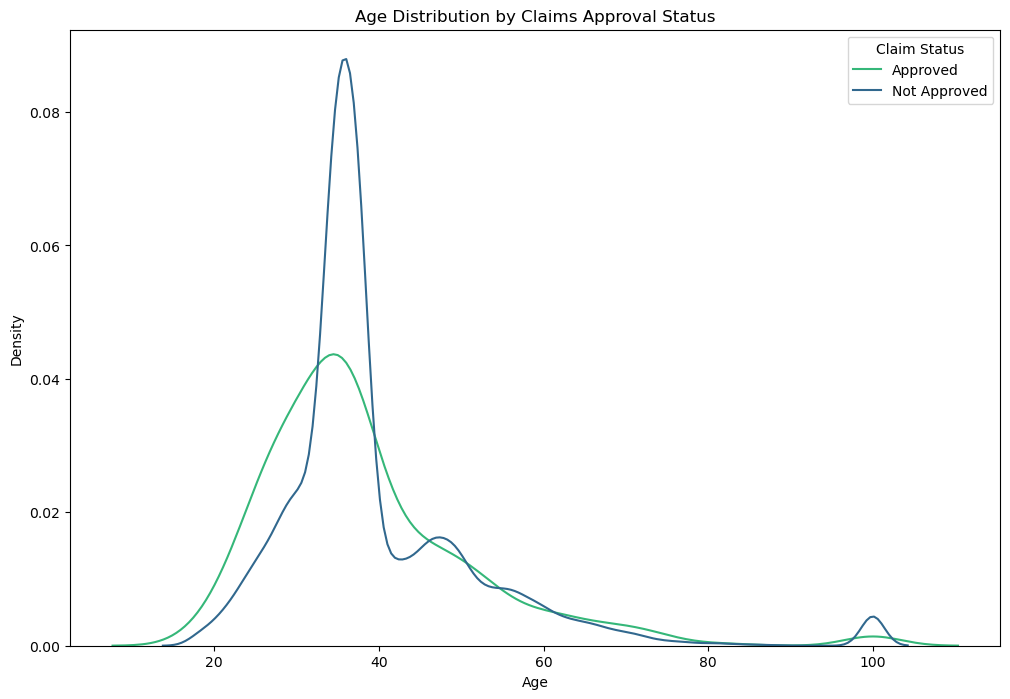

In [533]:
plt.figure(figsize = (12, 8))
sns.kdeplot(data = insurance, hue = 'claim_status', x = 'person_age', common_norm = False, palette = 'viridis')
plt.title('Age Distribution by Claims Approval Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(title = 'Claim Status', labels = ['Approved', 'Not Approved'])
plt.show()

# common_norm = False ensures each KDE curve is normalized independently
# If True, the density would be scaled such that the total area under all curves sums to 1. With False, each curve has an area of 1, making it easier to compare distributions when classes are imbalanced.

### Bivariate Analysis with Target (reward)

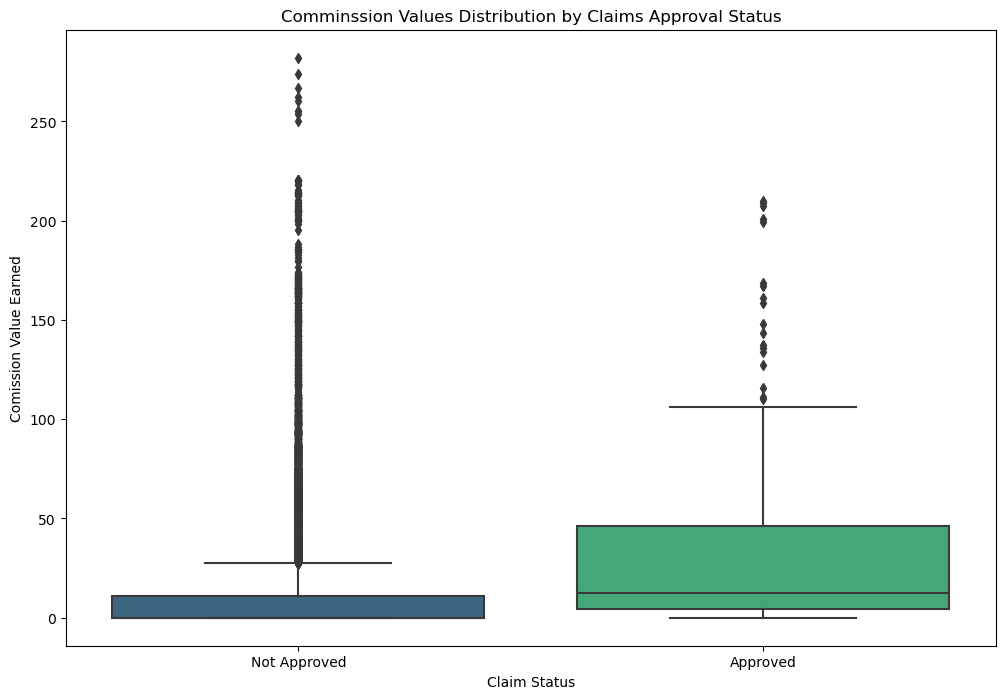

In [534]:
plt.figure(figsize = (12, 8))
sns.boxplot(data = insurance, x = 'claim_status', y = 'reward', palette = 'viridis')
plt.title('Comminssion Values Distribution by Claims Approval Status')
plt.xlabel('Claim Status')
plt.ylabel('Comission Value Earned')
plt.xticks(ticks=[0, 1], labels=['Not Approved', 'Approved'])
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


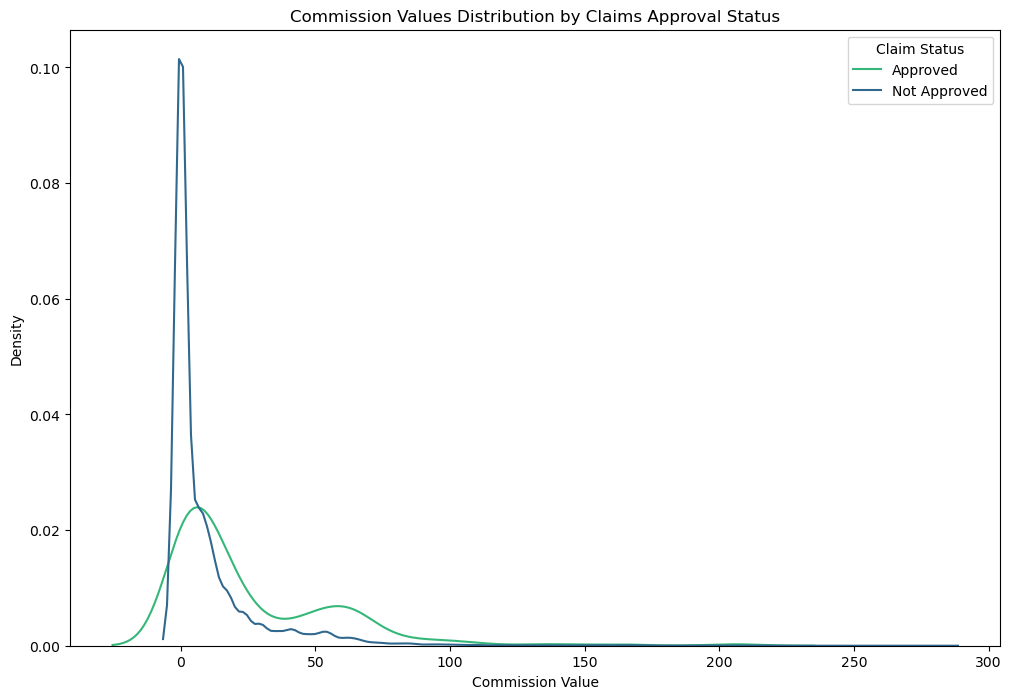

In [535]:
plt.figure(figsize = (12, 8))
sns.kdeplot(data = insurance, hue = 'claim_status', x = 'reward', common_norm = False, palette = 'viridis')
plt.title('Commission Values Distribution by Claims Approval Status')
plt.xlabel('Commission Value')
plt.ylabel('Density')
plt.legend(title = 'Claim Status', labels = ['Approved', 'Not Approved'])
plt.show()

### Bivariate Analysis with Target (revenue)

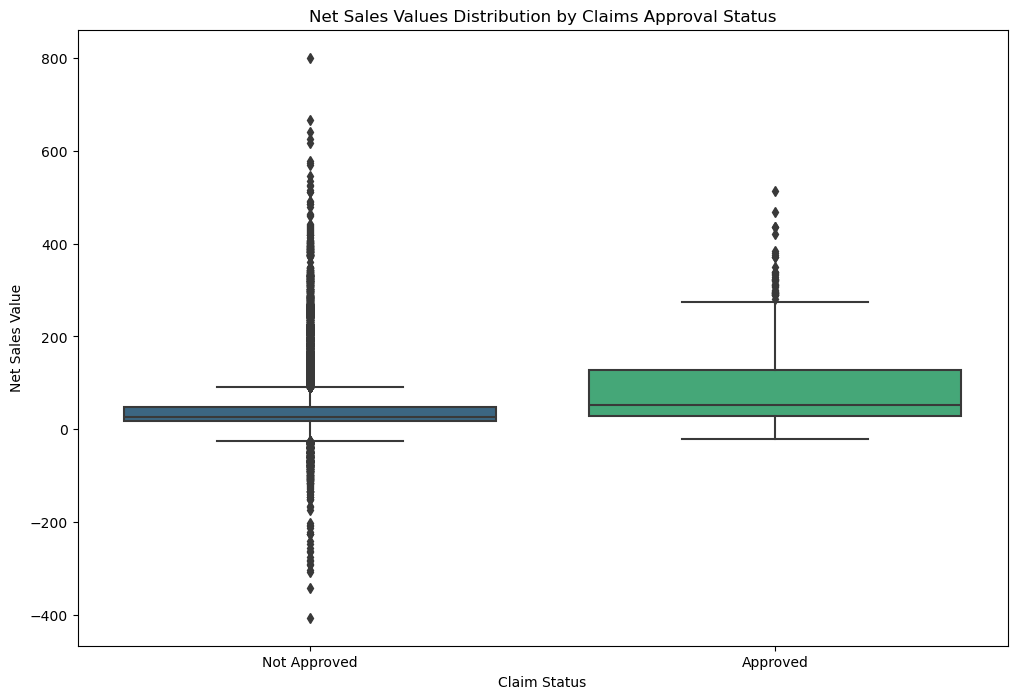

In [536]:
plt.figure(figsize = (12, 8))
sns.boxplot(data = insurance, x = 'claim_status', y = 'revenue', palette = 'viridis')
plt.title('Net Sales Values Distribution by Claims Approval Status')
plt.xlabel('Claim Status')
plt.ylabel('Net Sales Value')
plt.xticks(ticks=[0, 1], labels=['Not Approved', 'Approved'])
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


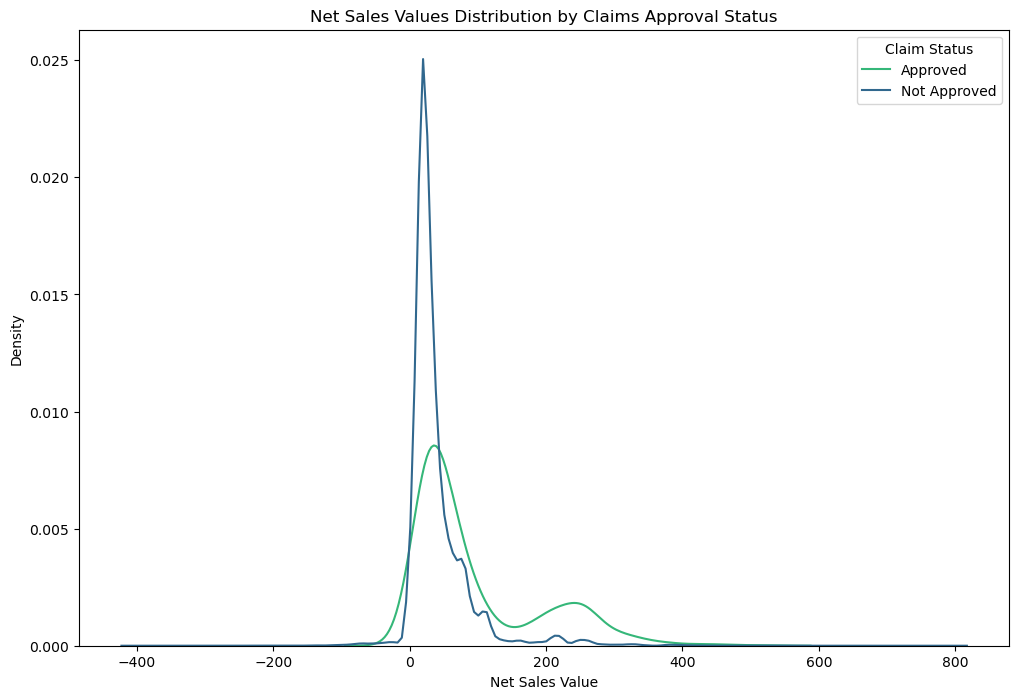

In [537]:
plt.figure(figsize = (12, 8))
sns.kdeplot(data = insurance, hue = 'claim_status', x = 'revenue', common_norm = False, palette = 'viridis')
plt.title('Net Sales Values Distribution by Claims Approval Status')
plt.xlabel('Net Sales Value')
plt.ylabel('Density')
plt.legend(title = 'Claim Status', labels = ['Approved', 'Not Approved'])
plt.show()

### Bivariate Analysis with Target (customer_score)

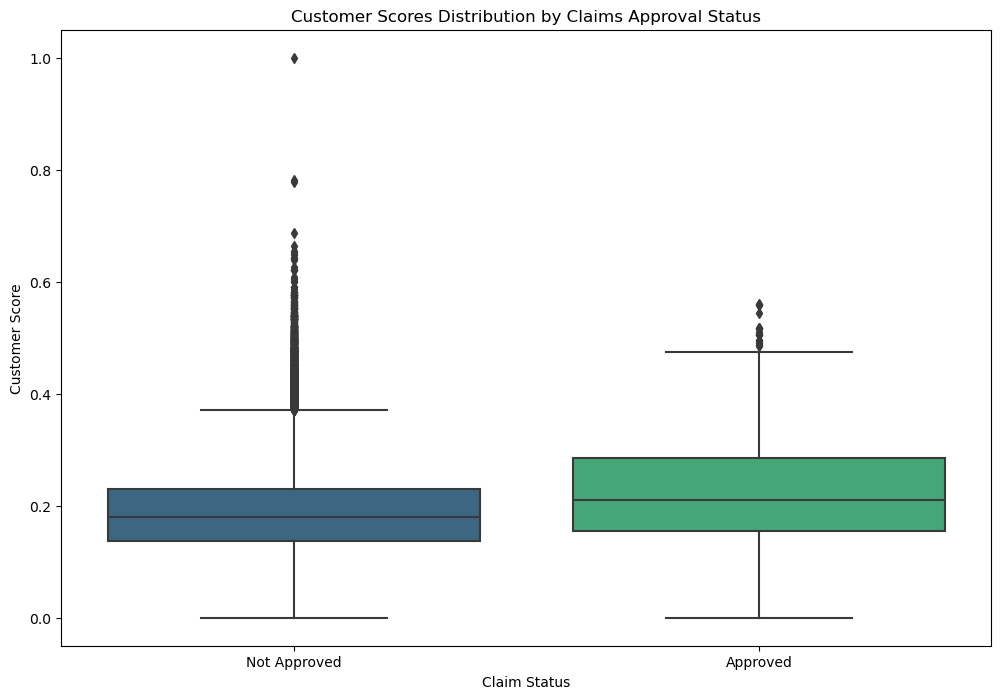

In [538]:
plt.figure(figsize = (12, 8))
sns.boxplot(data = insurance, x = 'claim_status', y = 'customer_score', palette = 'viridis')
plt.title('Customer Scores Distribution by Claims Approval Status')
plt.xlabel('Claim Status')
plt.ylabel('Customer Score')
plt.xticks(ticks=[0, 1], labels=['Not Approved', 'Approved'])
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


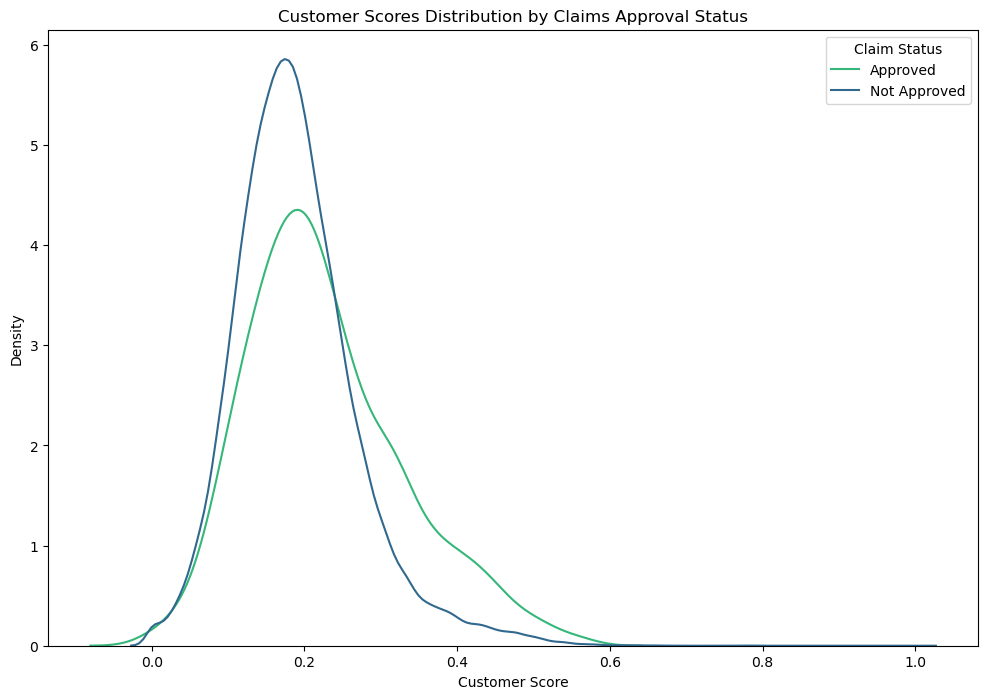

In [539]:
plt.figure(figsize = (12, 8))
sns.kdeplot(data = insurance, hue = 'claim_status', x = 'customer_score', common_norm = False, palette = 'viridis')
plt.title('Customer Scores Distribution by Claims Approval Status')
plt.xlabel('Customer Score')
plt.ylabel('Density')
plt.legend(title = 'Claim Status', labels = ['Approved', 'Not Approved'])
plt.show()

## Data Cleaning and Spliting

In [789]:
# to avoid data leakage, must do the spliting first

# Train (70%) and temp (30%)
insurance_train, temporary = train_test_split(insurance, test_size = 0.4, random_state = 123, stratify = insurance['claim_status'])

# Validation (15%) and Test (15%) from temporary (30%)
insurance_validation, insurance_test = train_test_split(temporary, test_size = 0.5, random_state = 123, stratify = temporary['claim_status'])
# target variable claim_status is imbalanced, stratify=... ensures all splits maintain the same proportion of 0s and 1s. This gives better generalization.

# for reproducibility
print("Train shape:", insurance_train.shape)
print("Validation shape:", insurance_validation.shape)
print("Test shape:", insurance_test.shape)

# Keeps more for validation & testing, giving better estimate of generalization on minority class

Train shape: (34195, 14)
Validation shape: (11399, 14)
Test shape: (11399, 14)


In [790]:
with open("data/insurance_split.pkl", "wb") as f:
    pickle.dump(insurance_train, f)
    pickle.dump(insurance_test, f)
    pickle.dump(insurance_validation, f)

# **Feature Selection**

In [1159]:
with open('data/insurance_split.pkl', 'rb') as f:
    insurance_train = pickle.load(f)
    insurance_validation = pickle.load(f)
    insurance_test = pickle.load(f)

In [1160]:
categorical_variables = insurance_train.select_dtypes(include=['object']).columns.tolist()
continuous_variables = insurance_train.select_dtypes(exclude=['object']).columns.tolist()
continuous_variables = [var for var in continuous_variables if var != 'support_interactions']
continuous_variables_no_target = [var for var in continuous_variables if var != 'claim_status']
categorical_variables_with_target = categorical_variables + ['claim_status']
categorical_variables_with_target = categorical_variables_with_target + ['support_interactions']

In [847]:
insurance_train[continuous_variables].var().sort_values()

customer_score        0.006512
claim_status          0.014409
person_age          158.112018
reward              385.660904
revenue            2392.496017
trip_length       11337.495017
dtype: float64

In [848]:
insurance_train[continuous_variables].corr()

reward  claim_status  customer_score  person_age   revenue  \
reward          1.000000      0.096173        0.373740    0.126935  0.650323   
claim_status    0.096173      1.000000        0.053494   -0.019146  0.135713   
customer_score  0.373740      0.053494        1.000000    0.642492  0.476146   
person_age      0.126935     -0.019146        0.642492    1.000000  0.046134   
revenue         0.650323      0.135713        0.476146    0.046134  1.000000   
trip_length     0.330985      0.073252        0.192857    0.010905  0.410709   

                trip_length  
reward             0.330985  
claim_status       0.073252  
customer_score     0.192857  
person_age         0.010905  
revenue            0.410709  
trip_length        1.000000

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


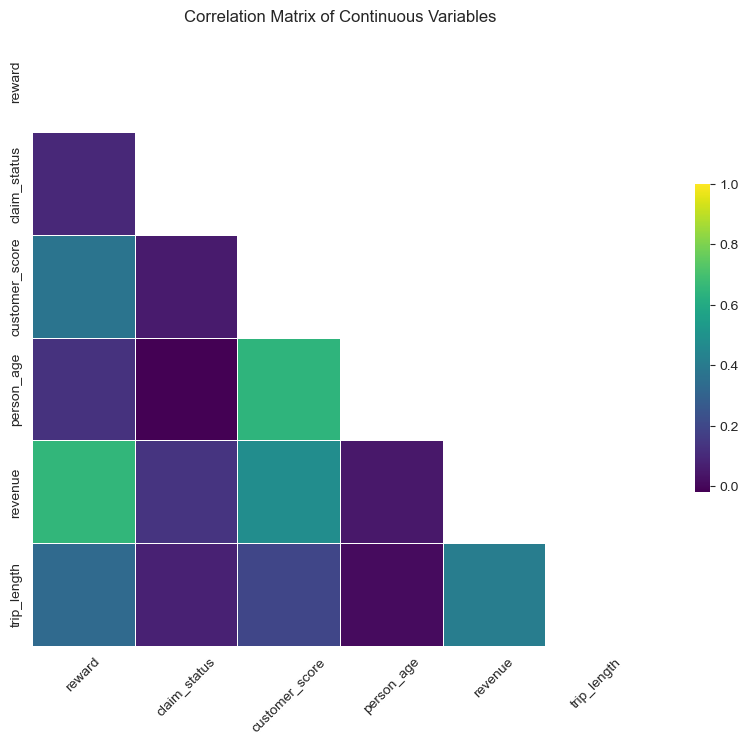

In [ ]:
# simple correlation pearson
plt.figure(figsize = (12, 8))
mask = np.triu(np.ones_like(insurance_train[continuous_variables].corr(), dtype=bool))
sns.heatmap(insurance_train[continuous_variables].corr(), 
            mask=mask,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5},
            annot=True,
            annot_kws={'size': 10, 'weight': 'bold'}, 
            cmap='viridis', 
            fmt=".2f")
plt.title('Correlation Matrix of Continuous Variables')
plt.xticks(rotation = 45)
plt.show()

In [1161]:
# categorical target and continuous predictors
def anova(dataset, dep_var, con_vars):
    results = []

    for var in con_vars:
        model = smf.ols(f'{dep_var} ~ {var}', data = dataset).fit()

        anova_table = anova_lm(model)
        f_statistic = anova_table['F'].iloc[0]
        p_value = anova_table['PR(>F)'].iloc[0]

        results.append([var, f_statistic, p_value])

    anova_results_df = pd.DataFrame(results, columns = ['Variable', 'F-statistic', 'p-value'])

    anova_results_df = anova_results_df.sort_values(by = 'F-statistic', ascending = False)

    return anova_results_df

In [1162]:
insurance_anova = anova(insurance_train, 'claim_status', continuous_variables_no_target)
print(insurance_anova) # support_interactions is not significant

         Variable  F-statistic        p-value
3         revenue   641.580491  2.986475e-140
0          reward   319.212212   4.529682e-71
4     trip_length   184.466658   6.592646e-42
1  customer_score    98.128367   4.212666e-23
2      person_age    12.539219   3.990284e-04


In [852]:
insurance.groupby('agent_id')['entity_a'].nunique()
# If every agent_id maps to exactly one entity_a, all values returned will be 1.

agent_id
agt_0000    1
agt_0001    1
agt_0002    1
agt_0003    1
agt_0004    1
agt_0005    1
agt_0006    1
agt_0007    1
agt_0008    1
agt_0009    1
agt_0010    1
agt_0011    1
agt_0012    1
agt_0013    1
agt_0014    1
agt_0015    1
Name: entity_a, dtype: int64

In [853]:
# and vice versa
insurance.groupby('entity_a')['agent_id'].nunique()

entity_a
0c4e727c    1
1e089e14    1
3db4b215    1
50b3e71e    1
5d630515    1
7b5dbb09    1
96d6c6df    1
99ede4e4    1
aba20dea    1
b5e4bb23    1
bb3ad25f    1
bc07f34c    1
be00235a    1
c4e0e538    1
d1e2553c    1
f94f3b95    1
Name: agent_id, dtype: int64

In [854]:
pd.crosstab(insurance['agent_id'], insurance['entity_a'])
# show if each agent maps to only one entity and vice versa.
# If the relationship is perfectly one-to-one and consistent, then keeping both columns might be redundant — safely drop one after choosing the more meaningful name.

entity_a  0c4e727c  1e089e14  3db4b215  50b3e71e  5d630515  7b5dbb09  \
agent_id                                                               
agt_0000        89         0         0         0         0         0   
agt_0001         0         0         0         0         0         0   
agt_0002         0         0         0         0         0      5683   
agt_0003         0         0         0         0         0         0   
agt_0004         0         0         0     31663         0         0   
agt_0005         0         0         0         0         0         0   
agt_0006         0       672         0         0         0         0   
agt_0007         0         0         0         0         0         0   
agt_0008         0         0         0         0         0         0   
agt_0009         0         0         0         0         0         0   
agt_0010         0         0         0         0         0         0   
agt_0011         0         0         0         0         0         0   
agt_0012         0         0         0         0         0         0   
agt_0013         0         0         0         0         0         0   
agt_0014         0         0        85         0         0         0   
agt_0015         0         0         0         0       456         0   

entity_a  96d6c6df  99ede4e4  aba20dea  b5e4bb23  bb3ad25f  bc07f34c  \
agent_id                                                               
agt_0000         0         0         0         0         0         0   
agt_0001      7713         0         0         0         0         0   
agt_0002         0         0         0         0         0         0   
agt_0003         0         0         0         0         0         0   
agt_0004         0         0         0         0         0         0   
agt_0005         0      7444         0         0         0         0   
agt_0006         0         0         0         0         0         0   
agt_0007         0         0         0         0         0         0   
agt_0008         0         0         0       949         0         0   
agt_0009         0         0         0         0         0         0   
agt_0010         0         0         0         0         0        77   
agt_0011         0         0       175         0         0         0   
agt_0012         0         0         0         0        71         0   
agt_0013         0         0         0         0         0         0   
agt_0014         0         0         0         0         0         0   
agt_0015         0         0         0         0         0         0   

entity_a  be00235a  c4e0e538  d1e2553c  f94f3b95  
agent_id                                          
agt_0000         0         0         0         0  
agt_0001         0         0         0         0  
agt_0002         0         0         0         0  
agt_0003         0         0       356         0  
agt_0004         0         0         0         0  
agt_0005         0         0         0         0  
agt_0006         0         0         0         0  
agt_0007         0       651         0         0  
agt_0008         0         0         0         0  
agt_0009       297         0         0         0  
agt_0010         0         0         0         0  
agt_0011         0         0         0         0  
agt_0012         0         0         0         0  
agt_0013         0         0         0       612  
agt_0014         0         0         0         0  
agt_0015         0         0         0         0

In [1163]:
# categorical target and categorical inputs
def cramers_v(contingency_table):
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

def calculate_cramers_v_matrix(dataset, cat_vars):
    cramers_v_matrix = pd.DataFrame(np.zeros((len(cat_vars), len(cat_vars))),
                                    columns = cat_vars,
                                    index = cat_vars)

    for i in range(len(cat_vars)):
        for j in range(i, len(cat_vars)): 
            var_1 = cat_vars[i]
            var_2 = cat_vars[j]

            contingency_table = pd.crosstab(dataset[var_1], dataset[var_2])

            cramers_v_value = cramers_v(contingency_table)

            cramers_v_matrix.loc[var_1, var_2] = cramers_v_value
            cramers_v_matrix.loc[var_2, var_1] = cramers_v_value  

    return cramers_v_matrix

In [1164]:
insurance_cramersv = calculate_cramers_v_matrix(insurance_train, categorical_variables_with_target)
print(insurance_cramersv) # should drop entity_a

                      person_gender  entity_type   channel  agent_id  \
person_gender              1.000000     0.863657  0.197165  0.711183   
entity_type                0.863657     0.999927  0.077330  1.000000   
channel                    0.197165     0.077330  0.999148  0.953881   
agent_id                   0.711183     1.000000  0.953881  1.000000   
entity_a                   0.711183     1.000000  0.953881  1.000000   
location                   0.323575     0.561786  0.221763  0.404808   
product_id                 0.710138     0.988843  0.944101  0.797835   
claim_status               0.110104     0.100425  0.000000  0.177095   
support_interactions       0.011507     0.013062  0.015192  0.021269   

                      entity_a  location  product_id  claim_status  \
person_gender         0.711183  0.323575    0.710138      0.110104   
entity_type           1.000000  0.561786    0.988843      0.100425   
channel               0.953881  0.221763    0.944101      0.000000   

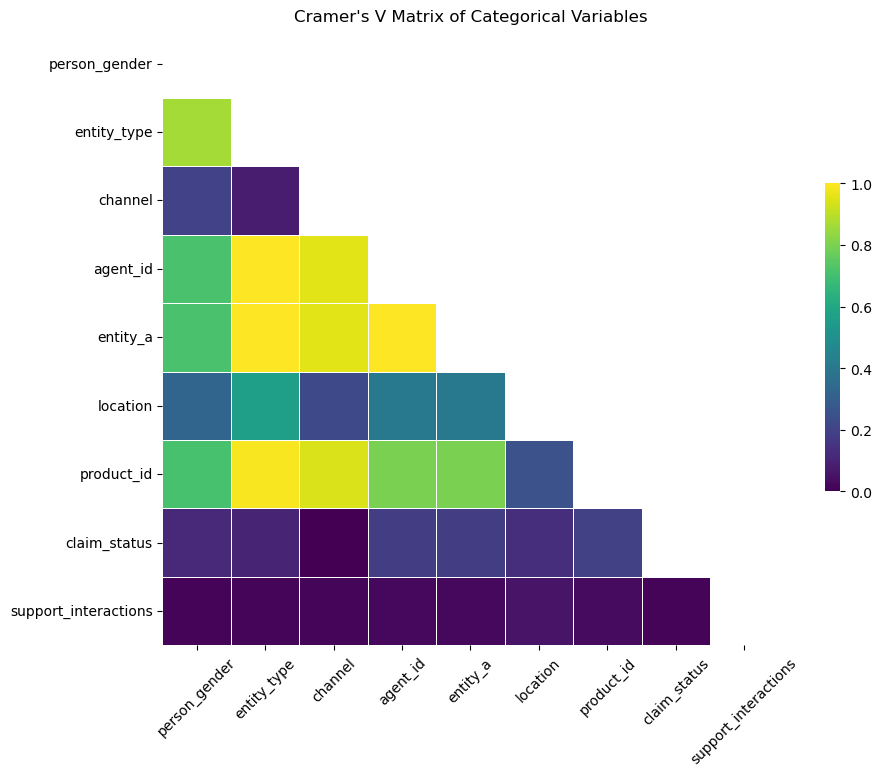

In [ ]:
# cramers v matrix
plt.figure(figsize = (12, 8))
sns.heatmap(insurance_cramersv, 
            mask = np.triu(np.ones_like(insurance_cramersv, dtype = bool)), 
            vmax = 1,
            square = True,
            linewidths = 0.5,
            cbar_kws = {'shrink': 0.5},
            # annot = True,
            cmap = 'viridis', 
            fmt = ".2f")
plt.title("Cramer's V Matrix of Categorical Variables")
plt.xticks(rotation = 45)
plt.show() 

In [858]:
insurance_train = insurance_train.drop(['entity_a'], axis = 1)
insurance_validation = insurance_validation.drop(['entity_a'], axis = 1)
insurance_test = insurance_test.drop(['entity_a'], axis = 1)

insurance_train = insurance_train.drop(['entity_type'], axis = 1)
insurance_validation = insurance_validation.drop(['entity_type'], axis = 1)
insurance_test = insurance_test.drop(['entity_type'], axis = 1)

insurance_train = insurance_train.drop(['channel'], axis = 1)
insurance_validation = insurance_validation.drop(['channel'], axis = 1)
insurance_test = insurance_test.drop(['channel'], axis = 1)

insurance_train = insurance_train.drop(['support_interactions'], axis = 1)
insurance_validation = insurance_validation.drop(['support_interactions'], axis = 1)
insurance_test = insurance_test.drop(['support_interactions'], axis = 1)

# **Feature Engineering**

In [859]:
categorical_variables = insurance_train.select_dtypes(include=['object']).columns.tolist()
continuous_variables = insurance_train.select_dtypes(exclude=['object']).columns.tolist()
continuous_variables_no_target = [var for var in continuous_variables if var != 'claim_status']
categorical_variables_with_target = categorical_variables + ['claim_status']

In [860]:
for col in continuous_variables:
    sk = skew(insurance_train[col])
    print(f"Skewness of {col}: {sk:.2f}")

# Skewness > 1 or < -1 = highly skewed → consider log transform.
# Highly skewed features may benefit from normalization or transformations.
# Since revenue might be negative:
# Use: np.log1p(df['revenue'] - df['revenue'].min() + 1) (shifts values to make them all ≥ 0)

Skewness of reward: 3.97
Skewness of claim_status: 8.09
Skewness of customer_score: 0.97
Skewness of person_age: 2.18
Skewness of revenue: 3.21
Skewness of trip_length: 23.84


In [861]:
insurance_train[continuous_variables].var().sort_values() # variance
# low variance potentially noise or redundant, no predictive power

customer_score        0.006512
claim_status          0.014409
person_age          158.112018
reward              385.660904
revenue            2392.496017
trip_length       11337.495017
dtype: float64

### For trip_length

In [862]:
trip_length_boxcox, fitted_lambda_boxcox = boxcox(insurance_train['trip_length'])
insurance_train['trip_length_boxcox'] = trip_length_boxcox
boxcox_skew = skew(insurance_train['trip_length_boxcox'])
print(f"Box-Cox Skewness (λ={fitted_lambda_boxcox:.2f}): {boxcox_skew:.2f}")

trip_length_yeojohnson, fitted_lambda_yeojohnson = yeojohnson(insurance_train['trip_length'])
insurance_train['trip_length_yeojohnson'] = trip_length_yeojohnson
yeojohnson_skew = skew(insurance_train['trip_length_yeojohnson'])
print(f"Yeo-Johnson Skewness (λ={fitted_lambda_yeojohnson:.2f}): {yeojohnson_skew:.2f}")

insurance_train['trip_length_log'] = np.log(insurance_train['trip_length'])
log_skew = skew(insurance_train['trip_length_log'])
print(f"Log Skewness: {log_skew:.2f}")


# Log	-0.01	λ=0	Simplest method, no parameter tuning.
# Box-Cox	-0.00	λ=0.00	Matches log transform (λ=0 is log).
# Yeo-Johnson	0.01	λ=-0.07	Slightly positive skewness.

# Log vs. Box-Cox:
# Identical performance here, since Box-Cox’s λ=0 is equivalent to a log transform.
# Prefer log for simplicity and interpretability (no need to track λ).
# Yeo-Johnson:
# Marginally worse skewness (0.01 vs. -0.01), but functionally equivalent.
# Use if your data contains zeros/negatives (unlikely for trip lengths).
# Use Log ---->
# Simplest to implement and explain.
# No need to store λ values for validation/test sets (Box-Cox/Yeo-Johnson require reapplying the same λ).
# Nearly identical results to Box-Cox in your case.


Box-Cox Skewness (λ=0.00): -0.00
Yeo-Johnson Skewness (λ=-0.07): 0.01
Log Skewness: -0.01


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

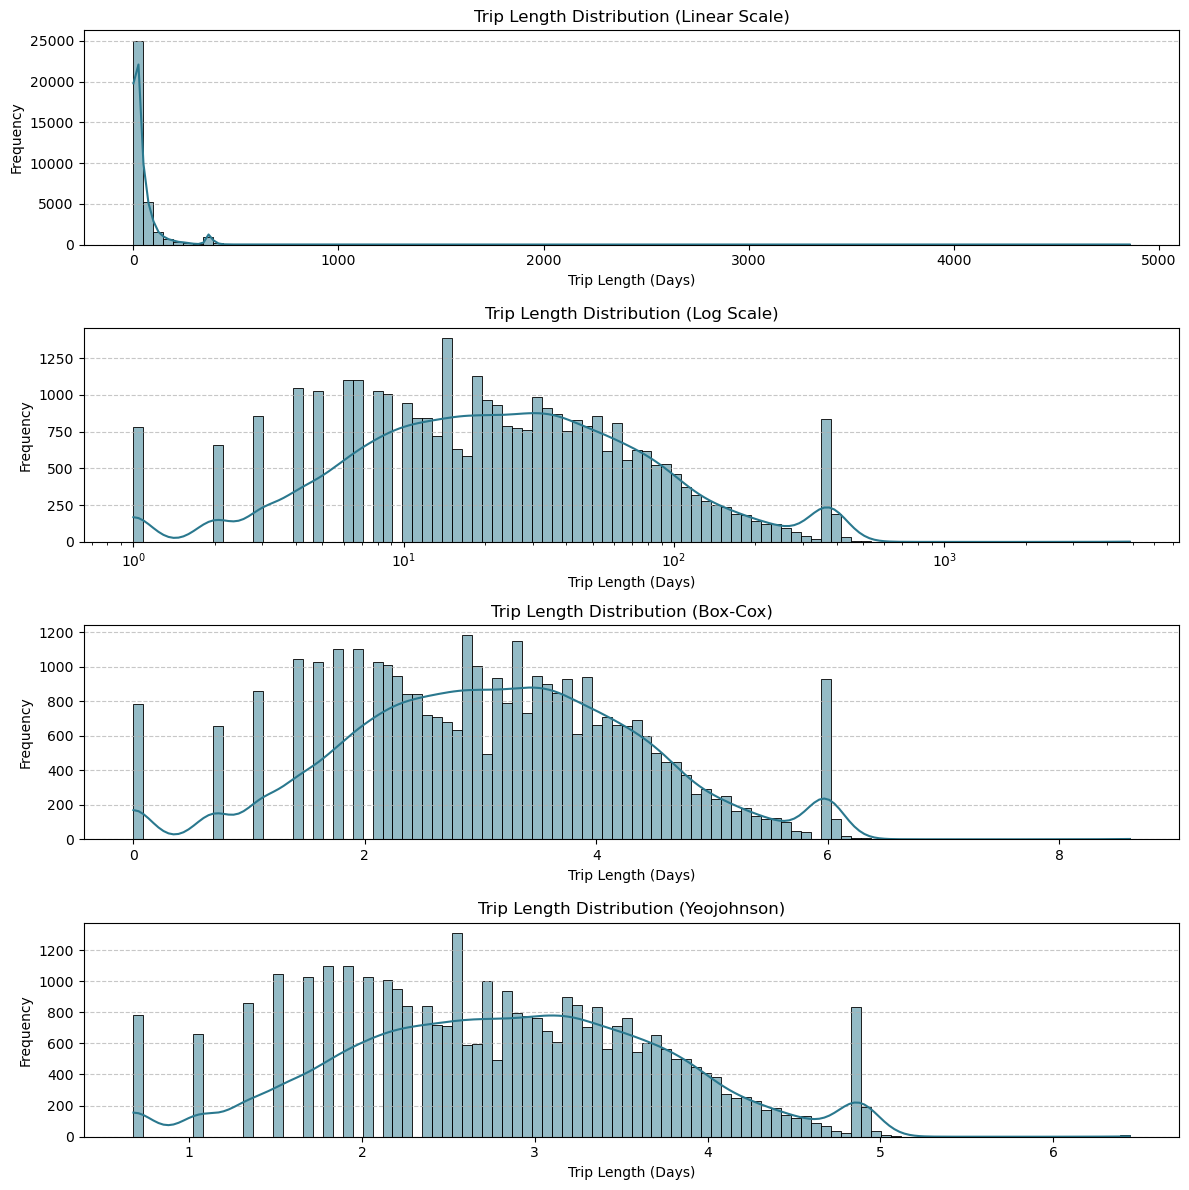

In [863]:
fig, axes = plt.subplots(4, 1, figsize = (12, 12))

sns.histplot(
    data = insurance_train,
    x = 'trip_length',
    bins = 100, 
    kde = True, 
    color = '#2A788EFF',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("Trip Length Distribution (Linear Scale)")
axes[0].set_xlabel('Trip Length (Days)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

# Second subplot (Log Scale)
sns.histplot(
    data = insurance_train,
    x = 'trip_length',
    bins = 100, 
    kde = True, 
    color = '#2A788EFF',
    log_scale = True,
    ax = axes[1]
)
axes[1].set_title("Trip Length Distribution (Log Scale)")
axes[1].set_xlabel('Trip Length (Days)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = insurance_train,
    x = 'trip_length_boxcox',
    bins = 100, 
    kde = True, 
    color = '#2A788EFF',
    ax = axes[2]
)
axes[2].set_title("Trip Length Distribution (Box-Cox)")
axes[2].set_xlabel('Trip Length (Days)')
axes[2].set_ylabel('Frequency')
axes[2].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = insurance_train,
    x = 'trip_length_yeojohnson',
    bins = 100, 
    kde = True, 
    color = '#2A788EFF',
    ax = axes[3]
)
axes[3].set_title("Trip Length Distribution (Yeojohnson)")
axes[3].set_xlabel('Trip Length (Days)')
axes[3].set_ylabel('Frequency')
axes[3].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [864]:
insurance_validation['trip_length_log'] = np.log(insurance_validation['trip_length'])
insurance_test['trip_length_log'] = np.log(insurance_test['trip_length'])

### For reward

In [865]:
reward_yeojohnson, reward_fitted_lambda_yeojohnson = yeojohnson(insurance_train['reward'])
insurance_train['reward_yeojohnson'] = reward_yeojohnson
yeojohnson_skew = skew(insurance_train['reward_yeojohnson'])
print(f"Yeo-Johnson Skewness (λ={reward_fitted_lambda_yeojohnson:.2f}): {yeojohnson_skew:.2f}")

insurance_train['reward_log'] = np.log(insurance_train['reward'] + 1)
log_skew = skew(insurance_train['reward_log'])
print(f"Log Skewness: {log_skew:.2f}")

Yeo-Johnson Skewness (λ=-0.42): 0.39
Log Skewness: 0.67


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


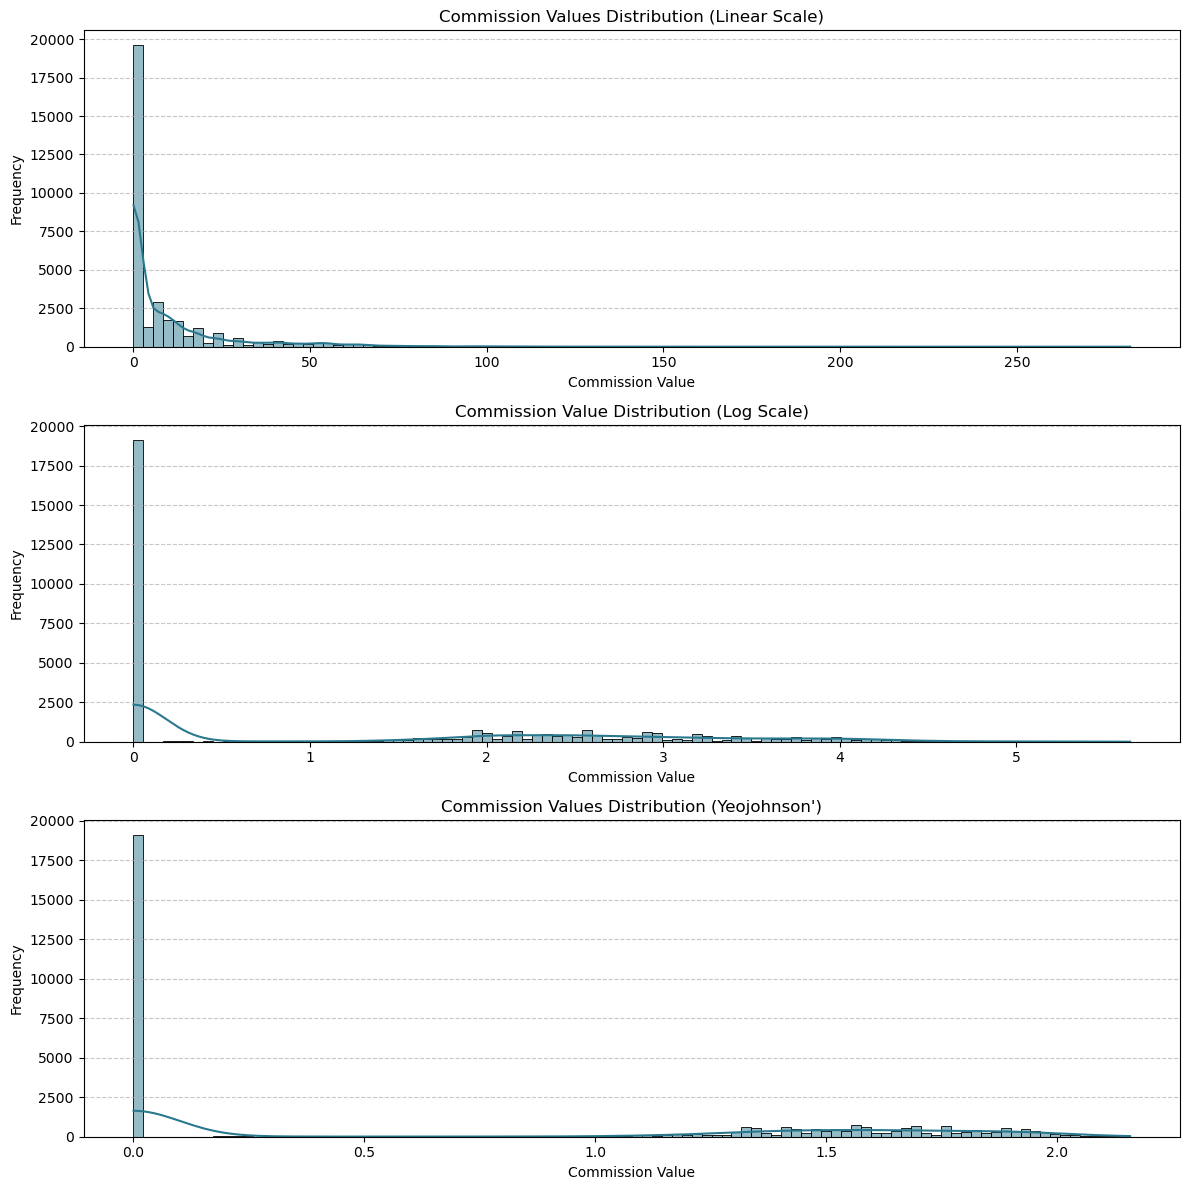

In [866]:
fig, axes = plt.subplots(3, 1, figsize = (12, 12))

sns.histplot(
    data = insurance_train,
    x = 'reward',
    bins = 100, 
    kde = True, 
    color = '#2A788EFF',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("Commission Values Distribution (Linear Scale)")
axes[0].set_xlabel('Commission Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

# Second subplot (Log Scale)
sns.histplot(
    np.log(insurance_train["reward"] + 1),
    bins = 100, 
    kde = True, 
    color = '#2A788EFF',
    log_scale = False,
    ax = axes[1]
)
axes[1].set_title("Commission Value Distribution (Log Scale)")
axes[1].set_xlabel('Commission Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = insurance_train,
    x = 'reward_yeojohnson',
    bins = 100, 
    kde = True, 
    color = '#2A788EFF',
    ax = axes[2]
)
axes[2].set_title("Commission Values Distribution (Yeojohnson')")
axes[2].set_xlabel('Commission Value')
axes[2].set_ylabel('Frequency')
axes[2].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [867]:
from scipy.stats import yeojohnson

# Apply using the same fitted lambda from the training set
insurance_validation['reward_yeojohnson'] = yeojohnson(insurance_validation['reward'], lmbda=reward_fitted_lambda_yeojohnson)
insurance_test['reward_yeojohnson'] = yeojohnson(insurance_test['reward'], lmbda=reward_fitted_lambda_yeojohnson)

### For revenue

In [869]:
revenue_yeojohnson, revenue_fitted_lambda_yeojohnson = yeojohnson(insurance_train['revenue'])
insurance_train['revenue_yeojohnson'] = revenue_yeojohnson
yeojohnson_skew = skew(insurance_train['revenue_yeojohnson'])
print(f"Yeo-Johnson Skewness (λ={revenue_fitted_lambda_yeojohnson:.2f}): {yeojohnson_skew:.2f}")

Yeo-Johnson Skewness (λ=0.91): 1.33


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


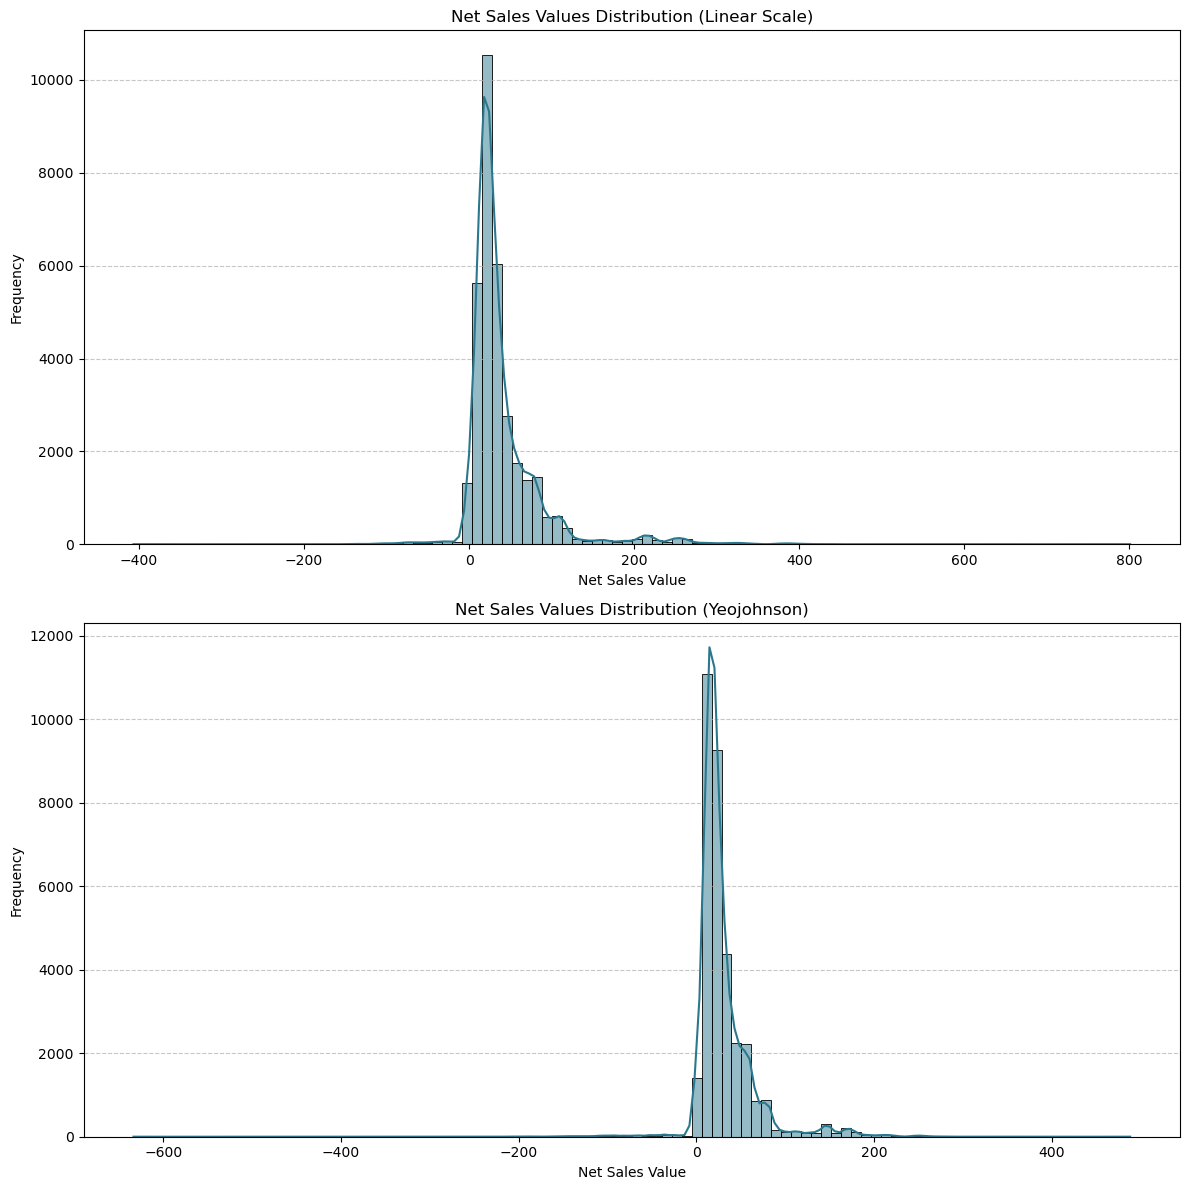

In [870]:
fig, axes = plt.subplots(2, 1, figsize = (12, 12))

sns.histplot(
    data = insurance_train,
    x = 'revenue',
    bins = 100, 
    kde = True, 
    color = '#2A788EFF',
    log_scale = False,
    ax = axes[0]
)
axes[0].set_title("Net Sales Values Distribution (Linear Scale)")
axes[0].set_xlabel('Net Sales Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.histplot(
    data = insurance_train,
    x = 'revenue_yeojohnson',
    bins = 100, 
    kde = True, 
    color = '#2A788EFF',
    ax = axes[1]
)
axes[1].set_title("Net Sales Values Distribution (Yeojohnson)")
axes[1].set_xlabel('Net Sales Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [871]:
insurance_validation['revenue_yeojohnson'] = yeojohnson(insurance_validation['revenue'], lmbda=revenue_fitted_lambda_yeojohnson)
insurance_test['revenue_yeojohnson'] = yeojohnson(insurance_test['revenue'], lmbda=revenue_fitted_lambda_yeojohnson)

In [873]:
print("NaN counts in test set:")
print(insurance_test.isna().sum())

NaN counts in test set:
reward                0
claim_status          0
person_gender         0
agent_id              0
customer_score        0
person_age            0
location              0
revenue               0
product_id            0
trip_length           0
trip_length_log       0
reward_yeojohnson     0
revenue_yeojohnson    0
dtype: int64


### For person_age

In [874]:
# jenk's natural breaks
age_binning = jenkspy.jenks_breaks(insurance_train['person_age'], 8) # number of classes
age_binning = age_binning[:-2] + [age_binning[-1]]
insurance_train['age_binning'] = pd.cut(
    insurance_train['person_age'],
    bins = age_binning,
    include_lowest = True
)

insurance_train['age_binning'].value_counts(sort = False)
# the last group is quite small - maybe should merge it with the previous one

age_binning
(17.999, 26.0]     2301
(26.0, 32.0]       4457
(32.0, 36.0]      10600
(36.0, 42.0]       7845
(42.0, 51.0]       4494
(51.0, 62.0]       2783
(62.0, 100.0]      1715
Name: count, dtype: int64

In [ ]:
insurance_validation['age_binning'] = pd.cut(
    insurance_validation['person_age'],
    bins = age_binning,
    include_lowest = True
)

insurance_test['age_binning'] = pd.cut(
    insurance_test['person_age'],
    bins = age_binning,
    include_lowest = True
)

### For location

In [ ]:
# frequency binning
location_counts = insurance_train['location'].value_counts()

def frequency(count):
    if count >= 1000:
        return 'Most popular'
    elif count >= 100:
        return 'Moderate popular'
    elif count >= 10:
        return 'Less popular'
    else:
        return 'Least popular'

location_binning = location_counts.map(frequency).to_dict()

for df in [insurance_train, insurance_validation, insurance_test]:
    df['location_binning'] = df['location'].map(location_binning).fillna('Least popular')

In [877]:
insurance_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34195 entries, 10848 to 2398
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   reward                  34195 non-null  float64 
 1   claim_status            34195 non-null  int64   
 2   person_gender           34195 non-null  object  
 3   agent_id                34195 non-null  object  
 4   customer_score          34195 non-null  float64 
 5   person_age              34195 non-null  int64   
 6   location                34195 non-null  object  
 7   revenue                 34195 non-null  float64 
 8   product_id              34195 non-null  object  
 9   trip_length             34195 non-null  int64   
 10  trip_length_boxcox      34195 non-null  float64 
 11  trip_length_yeojohnson  34195 non-null  float64 
 12  trip_length_log         34195 non-null  float64 
 13  reward_yeojohnson       34195 non-null  float64 
 14  reward_log              

# **Encoding**

In [882]:
insurance_train_encoded = insurance_train.copy()
insurance_validation_encoded = insurance_validation.copy()
insurance_test_encoded = insurance_test.copy()

In [887]:
insurance_train_encoded.head(30)

reward  claim_status person_gender  agent_id  customer_score  \
10848  37.354288             0      9b2d5b46  agt_0001        0.303918   
51861   9.673833             0      08f27188  agt_0005        0.165862   
22275   0.000000             0      9b2d5b46  agt_0004        0.213073   
52066   9.988767             0      f67ab10a  agt_0011        0.179138   
51743   3.871760             0      08f27188  agt_0005        0.165120   
33274   0.000000             0      9b2d5b46  agt_0004        0.130327   
47643  24.552136             0      9b2d5b46  agt_0001        0.183680   
49776  13.888097             0      08f27188  agt_0002        0.245327   
39260  18.144080             0      9b2d5b46  agt_0001        0.170657   
23013   0.000000             0      9b2d5b46  agt_0004        0.130262   
43999  13.916695             0      f67ab10a  agt_0005        0.203548   
48647   0.000000             0      9b2d5b46  agt_0004        0.115369   
21306   0.000000             0      9b2d5b46  agt_0004        0.189810   
14794   0.000000             0      9b2d5b46  agt_0004        0.192527   
10477   0.000000             0      9b2d5b46  agt_0004        0.255014   
428     0.000000             0      9b2d5b46  agt_0004        0.131028   
4975    0.000000             0      9b2d5b46  agt_0004        0.249877   
48950   0.000000             0      9b2d5b46  agt_0004        0.182262   
52597  16.117506             0      f67ab10a  agt_0002        0.288901   
56678  22.928036             0      f67ab10a  agt_0002        0.098439   
26228   0.000000             0      9b2d5b46  agt_0004        0.187133   
30645  30.027909             0      9b2d5b46  agt_0001        0.183985   
34652   0.000000             0      9b2d5b46  agt_0004        0.113771   
24932  12.017651             0      f67ab10a  agt_0002        0.195733   
12595  47.532883             0      9b2d5b46  agt_0001        0.276859   
186     0.000000             0      9b2d5b46  agt_0004        0.091974   
9866    0.000000             0      9b2d5b46  agt_0004        0.129973   
55755   7.346766             0      f67ab10a  agt_0002        0.210082   
54470   0.000000             0      9b2d5b46  agt_0004        0.190267   
29389  20.719774             0      f67ab10a  agt_0002        0.172462   

       person_age                   location    revenue  \
10848          51                  australia  58.644354   
51861          54                  singapore  41.621968   
22275          36                    austria  57.208017   
52066          18                   thailand  28.750758   
51743          27                  singapore  16.463294   
33274          43                      china  20.970761   
47643          48                     france  38.649957   
49776          50                      china  41.907626   
39260          30                   thailand  30.787696   
23013          37                      nepal  35.553326   
43999          33                  singapore  59.289820   
48647          35                      china  28.867726   
21306          37                      italy  74.718062   
14794          38         korea, republic of  17.297205   
10477          37           papua new guinea  58.759540   
428            34  taiwan, province of china  63.089207   
4975           37                      india  25.148242   
48950          58                  singapore  20.961327   
52597          52                      japan  46.451031   
56678          20                      china   0.000000   
26228          34                  hong kong  96.174588   
30645          30                  australia  48.332318   
34652          26                    georgia  20.144314   
24932          39                      india  33.808367   
12595          61                     canada  79.567163   
186            35                     turkey  16.087552   
9866           25                  singapore  19.159057   
55755          43                  australia  22.314890   
5447

In [884]:
age_bins_order = [
    '(17.999, 26.0]',
    '(26.0, 32.0]',
    '(32.0, 36.0]',
    '(36.0, 42.0]',
    '(42.0, 51.0]',
    '(51.0, 62.0]',
    '(62.0, 100.0]'
]

insurance_train_encoded['age_binning'] = insurance_train_encoded['age_binning'].astype(str)
insurance_validation_encoded['age_binning'] = insurance_validation_encoded['age_binning'].astype(str)
insurance_test_encoded['age_binning'] = insurance_test_encoded['age_binning'].astype(str)

ordinal_encoder = OrdinalEncoder(categories = [age_bins_order], handle_unknown = 'use_encoded_value', unknown_value = -1)

insurance_train_encoded['age_binning'] = ordinal_encoder.fit_transform(
    insurance_train_encoded['age_binning'].values.reshape(-1, 1)
)

insurance_test_encoded['age_binning'] = ordinal_encoder.transform(
    insurance_test_encoded['age_binning'].values.reshape(-1, 1)
)

insurance_validation_encoded['age_binning'] = ordinal_encoder.transform(
    insurance_validation_encoded['age_binning'].values.reshape(-1, 1)
)

In [885]:
insurance_train_encoded['age_binning'] = insurance_train_encoded['age_binning'].astype(int) + 1
insurance_validation_encoded['age_binning'] = insurance_validation_encoded['age_binning'].astype(int) + 1
insurance_test_encoded['age_binning'] = insurance_test_encoded['age_binning'].astype(int) + 1

In [886]:
location_order = {
    'Least popular': 1,
    'Less popular': 2,
    'Moderate popular': 3,
    'Most popular': 4
}

for df in [insurance_train_encoded, insurance_validation_encoded, insurance_test_encoded]:
    df['location_binning'] = df['location_binning'].map(location_order)

In [888]:
insurance_train_encoded['location_binning'] = insurance_train_encoded['location_binning'].astype(int)
insurance_validation_encoded['location_binning'] = insurance_validation_encoded['location_binning'].astype(int)
insurance_test_encoded['location_binning'] = insurance_test_encoded['location_binning'].astype(int)

In [889]:
insurance_train_encoded.rename(columns={'person_gender': 'gender'}, inplace = True)
insurance_validation_encoded.rename(columns={'person_gender': 'gender'}, inplace = True)
insurance_test_encoded.rename(columns={'person_gender': 'gender'}, inplace = True)

In [890]:
insurance_train_encoded["agent_id"] = insurance_train_encoded["agent_id"].str.replace("agt_", "", regex = False)
insurance_validation_encoded["agent_id"] = insurance_validation_encoded["agent_id"].str.replace("agt_", "", regex = False)
insurance_test_encoded["agent_id"] = insurance_test_encoded["agent_id"].str.replace("agt_", "", regex = False)

In [891]:
insurance_train_encoded["product_id"] = insurance_train_encoded["product_id"].str.replace("SecurePlan Family", "Other", regex = False)
insurance_train_encoded["product_id"] = insurance_train_encoded["product_id"].str.replace("CruiseSafe Family", "Other", regex = False)
insurance_validation_encoded["product_id"] = insurance_validation_encoded["product_id"].str.replace("SecurePlan Family", "Other", regex = False)
insurance_test_encoded["product_id"] = insurance_test_encoded["product_id"].str.replace("SecurePlan Family", "Other", regex = False)

In [892]:
insurance_train_encoded = pd.get_dummies(insurance_train_encoded,
                                        columns = ['gender', 'agent_id', 'product_id'],
                                        drop_first = True,
                                        dtype = int)

insurance_validation_encoded = pd.get_dummies(insurance_validation_encoded,
                                        columns = ['gender', 'agent_id', 'product_id'],
                                        drop_first = True,
                                        dtype = int)

insurance_test_encoded = pd.get_dummies(insurance_test_encoded,
                                        columns = ['gender', 'agent_id', 'product_id'],
                                        drop_first = True,
                                        dtype = int)

In [893]:
insurance_train_encoded.columns = insurance_train_encoded.columns.str.replace(" ", "_")
insurance_validation_encoded.columns = insurance_validation_encoded.columns.str.replace(" ", "_")
insurance_test_encoded.columns = insurance_test_encoded.columns.str.replace(" ", "_")

In [894]:
insurance_train_encoded = insurance_train_encoded.drop(['trip_length', 'trip_length_boxcox', 'trip_length_yeojohnson', 'reward_log', 'person_age', 'location', 'reward', 'revenue'], axis = 1)
insurance_validation_encoded = insurance_validation_encoded.drop(['trip_length', 'person_age', 'location', 'reward', 'revenue'], axis = 1)
insurance_test_encoded = insurance_test_encoded.drop(['trip_length', 'person_age', 'location', 'reward', 'revenue'], axis = 1)

In [895]:
set(insurance_train_encoded.columns) - set(insurance_validation_encoded.columns)

set()

In [896]:
with open("data/insurance_encoded.pkl", "wb") as f:
    pickle.dump(insurance_train_encoded, f)
    pickle.dump(insurance_test_encoded, f)
    pickle.dump(insurance_validation_encoded, f)

# **Model Training**

In [1025]:
with open('data/insurance_encoded.pkl', 'rb') as f:
    insurance_train_encoded = pickle.load(f)
    insurance_validation_encoded = pickle.load(f)
    insurance_test_encoded = pickle.load(f)

In [1026]:
insurance_train_X = insurance_train_encoded.drop('claim_status', axis = 1)
insurance_train_y = insurance_train_encoded['claim_status']

insurance_validation_X = insurance_validation_encoded.drop('claim_status', axis = 1)
insurance_validation_y = insurance_validation_encoded['claim_status']

insurance_test_X = insurance_test_encoded.drop('claim_status', axis = 1)
insurance_test_y = insurance_test_encoded['claim_status']

In [1027]:
for name, df in {
    "Train X": insurance_train_X,
    "Train y": insurance_train_y,
    "Validation X": insurance_validation_X,
    "Validation y": insurance_validation_y,
    "Test X": insurance_test_X,
    "Test y": insurance_test_y
}.items():
    print(f"{name} - Missing values:\n{df.isnull().sum().sum()}")


Train X - Missing values:
0
Train y - Missing values:
0
Validation X - Missing values:
0
Validation y - Missing values:
0
Test X - Missing values:
0
Test y - Missing values:
0


In [7]:
print("Train:", insurance_train_X.shape, insurance_train_y.shape)
print("Validation:", insurance_validation_X.shape, insurance_validation_y.shape)
print("Test:", insurance_test_X.shape, insurance_test_y.shape)

Train: (34195, 47) (34195,)
Validation: (11399, 47) (11399,)
Test: (11399, 47) (11399,)


In [8]:
assert list(insurance_train_X.columns) == list(insurance_validation_X.columns) == list(insurance_test_X.columns), "Mismatch in columns"

In [1028]:
print("Train dtypes:\n", insurance_train_X.dtypes)
print("Validation dtypes match:", insurance_train_X.dtypes.equals(insurance_validation_X.dtypes))
print("Test dtypes match:", insurance_train_X.dtypes.equals(insurance_test_X.dtypes))

Train dtypes:
 customer_score                        float64
trip_length_log                       float64
reward_yeojohnson                     float64
revenue_yeojohnson                    float64
age_binning                             int64
location_binning                        int64
gender_9b2d5b46                         int64
gender_f67ab10a                         int64
agent_id_0001                           int64
agent_id_0002                           int64
agent_id_0003                           int64
agent_id_0004                           int64
agent_id_0005                           int64
agent_id_0006                           int64
agent_id_0007                           int64
agent_id_0008                           int64
agent_id_0009                           int64
agent_id_0010                           int64
agent_id_0011                           int64
agent_id_0012                           int64
agent_id_0013                           int64
agent_id_0014      

In [10]:
print("Train class distribution:\n", insurance_train_y.value_counts(normalize=True))
print("Validation class distribution:\n", insurance_validation_y.value_counts(normalize=True))
print("Test class distribution:\n", insurance_test_y.value_counts(normalize=True))

Train class distribution:
 claim_status
0    0.985378
1    0.014622
Name: proportion, dtype: float64
Validation class distribution:
 claim_status
0    0.98535
1    0.01465
Name: proportion, dtype: float64
Test class distribution:
 claim_status
0    0.98535
1    0.01465
Name: proportion, dtype: float64


In [1029]:
print(insurance_train_X[['location_binning', 'age_binning']].nunique())
print(insurance_train_X[['location_binning', 'age_binning']].dtypes)

location_binning    4
age_binning         7
dtype: int64
location_binning    int64
age_binning         int64
dtype: object


In [1030]:
from sklearn.compose import ColumnTransformer

scale_columns = ['customer_score', 'trip_length_log', 'reward_yeojohnson', 'revenue_yeojohnson']

preprocessor_s = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), scale_columns)
    ],
    remainder='passthrough'  # Keep all other columns unchanged
)

preprocessor_m = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), scale_columns)
    ],
    remainder='passthrough'  # Keep all other columns unchanged
)

In [1032]:
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold

## SVM

In [ ]:
# SMOTE: Adds synthetic minority samples.
# Tomek Links: Identifies and removes borderline or ambiguous examples from the majority class that are close to the minority class — reducing overlap and noise.
# Goal: Achieve cleaner class boundaries by oversampling the minority and undersampling the majority.
# Good when: Your dataset is very imbalanced and you suspect there is class overlap or noise near the decision boundary.
# have 1.5% minority class (extremely imbalanced),
# The dataset is fairly large (~57k rows),
# There may be class overlap in some features (e.g., many locations have 0 or few claims),
# starting with SMOTETomek — it's more robust as it addresses both balance and clean decision boundaries.

In [1033]:
svm_rbf_pipeline_smote = Pipeline([
    ('sampler', SMOTE(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', SVC(
        kernel='rbf', 
        max_iter=50000,
        tol = 0.01
    ))
])

svm_rbf_grid_smote = {'model__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 100],
                'model__gamma': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 10, 100]} 

svm_rbf_tuned_smote = RandomizedSearchCV(
    svm_rbf_pipeline_smote, 
    svm_rbf_grid_smote, 
    n_iter = 20,
    scoring='balanced_accuracy', 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    n_jobs=-1,
    verbose=2
)

svm_rbf_tuned_smote.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_rbf_tuned_smote.best_params_)
print("Best BA:", svm_rbf_tuned_smote.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV] END ....................model__C=0.05, model__gamma=0.2; total time= 2.4min
[CV] END ....................model__C=0.05, model__gamma=0.2; total time= 2.4min
[CV] END ....................model__C=0.05, model__gamma=0.2; total time= 2.5min
[CV] END ....................model__C=0.05, model__gamma=0.2; total time= 2.9min
[CV] END ....................model__C=0.05, model__gamma=0.2; total time= 2.9min
[CV] END .......................model__C=0.5, model__gamma=1; total time= 4.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (m

[CV] END .....................model__C=100, model__gamma=100; total time= 7.8min
[CV] END .....................model__C=100, model__gamma=100; total time= 8.0min
[CV] END .....................model__C=100, model__gamma=100; total time= 8.0min
[CV] END .....................model__C=100, model__gamma=100; total time= 8.1min
[CV] END .....................model__C=100, model__gamma=100; total time= 8.4min
[CV] END .......................model__C=0.5, model__gamma=1; total time= 4.4min
[CV] END .......................model__C=0.5, model__gamma=1; total time= 4.4min
[CV] END .......................model__C=0.5, model__gamma=1; total time= 3.8min
[CV] END ...................model__C=100, model__gamma=0.001; total time= 3.1min
[CV] END ...................model__C=100, model__gamma=0.001; total time= 3.3min
[CV] END ...................model__C=100, model__gamma=0.001; total time= 3.3min
[CV] END ...................model__C=100, model__gamma=0.001; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .......................model__C=0.5, model__gamma=1; total time= 4.6min
[CV] END ......................model__C=50, model__gamma=0.5; total time= 2.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................model__C=100, model__gamma=0.001; total time= 2.9min
[CV] END ......................model__C=50, model__gamma=0.5; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.5; total time= 2.5min
[CV] END ......................model__C=50, model__gamma=0.5; total time= 2.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.5; total time= 2.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................model__C=50, model__gamma=1; total time= 2.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................model__C=50, model__gamma=1; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................model__C=50, model__gamma=1; total time= 2.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................model__C=50, model__gamma=1; total time= 2.7min
[CV] END ........................model__C=50, model__gamma=1; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=25, model__gamma=0.1; total time= 2.7min
[CV] END ......................model__C=25, model__gamma=0.1; total time= 2.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=25, model__gamma=0.1; total time= 2.8min
[CV] END ......................model__C=25, model__gamma=0.1; total time= 2.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=25, model__gamma=0.1; total time= 2.7min
[CV] END ....................model__C=25, model__gamma=0.001; total time= 2.8min
[CV] END ....................model__C=25, model__gamma=0.001; total time= 3.0min
[CV] END ....................model__C=25, model__gamma=0.001; total time= 3.0min
[CV] END ....................model__C=25, model__gamma=0.001; total time= 3.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................model__C=25, model__gamma=0.001; total time= 3.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.2; total time= 3.1min
[CV] END ......................model__C=50, model__gamma=0.2; total time= 3.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.2; total time= 3.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.2; total time= 3.1min
[CV] END ......................model__C=50, model__gamma=0.2; total time= 3.1min
[CV] END .....................model__C=50, model__gamma=0.01; total time= 2.9min
[CV] END .....................model__C=50, model__gamma=0.01; total time= 2.9min
[CV] END .....................model__C=50, model__gamma=0.01; total time= 2.9min
[CV] END .....................model__C=50, model__gamma=0.01; total time= 2.8min
[CV] END .....................model__C=50, model__gamma=0.01; total time= 2.7min
[CV] END ....................model__C=50, model__gamma=0.001; total time= 2.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .......................model__C=10, model__gamma=10; total time= 9.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .......................model__C=10, model__gamma=10; total time= 9.4min
[CV] END .......................model__C=10, model__gamma=10; total time= 9.1min
[CV] END .......................model__C=10, model__gamma=10; total time= 8.8min
[CV] END .......................model__C=10, model__gamma=10; total time= 9.5min
[CV] END ....................model__C=50, model__gamma=0.001; total time= 2.8min
[CV] END ....................model__C=50, model__gamma=0.001; total time= 3.0min
[CV] END ....................model__C=50, model__gamma=0.001; total time= 3.2min
[CV] END ....................model__C=50, model__gamma=0.001; total time= 3.0min
[CV] END .....................model__C=5, model__gamma=0.001; total time= 3.5min
[CV] END .....................model__C=5, model__gamma=0.001; total time= 3.5min
[CV] END .....................model__C=5, model__gamma=0.001; total time= 3.5min
[CV] END .....................model__C=5, model__gamma=0.001; total time= 3.5min
[CV] END ...................

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ...................model__C=0.01, model__gamma=0.01; total time= 5.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.5; total time= 2.9min
[CV] END .....................model__C=100, model__gamma=0.5; total time= 2.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.5; total time= 3.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.5; total time= 2.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.5; total time= 2.8min
[CV] END ...................model__C=0.01, model__gamma=0.01; total time= 5.5min
[CV] END ...................model__C=0.01, model__gamma=0.01; total time= 5.5min
[CV] END ........................model__C=10, model__gamma=1; total time= 3.3min
[CV] END ........................model__C=10, model__gamma=1; total time= 3.1min
[CV] END ........................model__C=10, model__gamma=1; total time= 2.7min
[CV] END ........................model__C=10, model__gamma=1; total time= 3.1min
[CV] END ........................model__C=10, model__gamma=1; total time= 1.8min
Best parameters: {'model__gamma': 0.05, 'model__C': 0.01}
Best BA: 0.7482353464905772


In [ ]:
best_svm_rbf_model_smote = svm_rbf_tuned_smote.best_estimator_

best_svm_rbf_model_smote_train_scores = best_svm_rbf_model_smote.decision_function(insurance_train_X)

best_svm_rbf_model_smote_train_auc = roc_auc_score(insurance_train_y, best_svm_rbf_model_smote_train_scores)

print("Train AUC:", best_svm_rbf_model_smote_train_auc)

Train AUC: 0.8262528565069002


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, balanced_accuracy_score

best_svm_rbf_model_smote = svm_rbf_tuned_smote.best_estimator_

y_val_pred_rbf_smote = best_svm_rbf_model_smote.predict(insurance_validation_X)

y_val_scores_rbf_smote = best_svm_rbf_model_smote.decision_function(insurance_validation_X)

val_auc_rbf_smote = roc_auc_score(insurance_validation_y, y_val_scores_rbf_smote)
print("Validation AUC:", val_auc_rbf_smote)

val_ba_rbf_smote = balanced_accuracy_score(insurance_validation_y, y_val_pred_rbf_smote)
print("Validation Balanced Accuracy (BA):", val_ba_rbf_smote)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_rbf_smote, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_rbf_smote))

Validation AUC: 0.7687493602538513
Validation Balanced Accuracy (BA): 0.728644207311872
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     11232
           1       0.06      0.61      0.10       167

    accuracy                           0.84     11399
   macro avg       0.52      0.73      0.51     11399
weighted avg       0.98      0.84      0.90     11399

Confusion Matrix:
[[9508 1724]
 [  65  102]]


In [1035]:
svm_rbf_pipeline_smotetomek = Pipeline([
    ('sampler', SMOTETomek(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', SVC(
        kernel='rbf', 
        max_iter=50000,
        tol = 0.01
    ))
])

svm_rbf_grid_smotetomek = {'model__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 100],
                           'model__gamma': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 10, 100]} 

svm_rbf_tuned_smotetomek = RandomizedSearchCV(
    svm_rbf_pipeline_smotetomek, 
    svm_rbf_grid_smotetomek, 
    n_iter = 20,
    scoring='balanced_accuracy', 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    n_jobs=-1,
    verbose=2
)

svm_rbf_tuned_smotetomek.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_rbf_tuned_smotetomek.best_params_)
print("Best BA:", svm_rbf_tuned_smotetomek.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.5; total time= 3.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.5; total time= 3.6min
[CV] END .....................model__C=100, model__gamma=0.5; total time= 3.7min
[CV] END .....................model__C=100, model__gamma=0.5; total time= 3.7min
[CV] END .....................model__C=100, model__gamma=0.5; total time= 3.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .......................model__C=25, model__gamma=10; total time= 9.5min
[CV] END .......................model__C=25, model__gamma=10; total time= 9.5min
[CV] END .......................model__C=25, model__gamma=10; total time= 9.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .......................model__C=25, model__gamma=10; total time= 9.4min
[CV] END .......................model__C=25, model__gamma=10; total time= 9.7min
[CV] END ...................model__C=0.05, model__gamma=0.05; total time= 4.5min
[CV] END ...................model__C=0.05, model__gamma=0.05; total time= 4.0min
[CV] END ...................model__C=0.05, model__gamma=0.05; total time= 4.2min
[CV] END ...................model__C=0.05, model__gamma=0.05; total time= 4.2min
[CV] END ......................model__C=0.5, model__gamma=10; total time=15.2min
[CV] END ......................model__C=0.5, model__gamma=10; total time=15.3min
[CV] END ......................model__C=0.5, model__gamma=10; total time=15.4min
[CV] END ...................model__C=0.05, model__gamma=0.05; total time= 4.0min
[CV] END ......................model__C=10, model__gamma=0.5; total time= 3.7min
[CV] END ......................model__C=10, model__gamma=0.5; total time= 3.6min
[CV] END ...................

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.1; total time= 3.8min
[CV] END ......................model__C=0.5, model__gamma=10; total time=15.3min
[CV] END ......................model__C=0.5, model__gamma=10; total time=15.2min
[CV] END .....................model__C=100, model__gamma=0.1; total time= 3.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.1; total time= 3.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.1; total time= 3.9min
[CV] END .....................model__C=100, model__gamma=0.1; total time= 4.0min
[CV] END ....................model__C=100, model__gamma=0.01; total time= 3.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................model__C=100, model__gamma=0.01; total time= 3.8min
[CV] END ....................model__C=100, model__gamma=0.01; total time= 3.8min
[CV] END ....................model__C=100, model__gamma=0.01; total time= 4.0min
[CV] END ....................model__C=100, model__gamma=0.01; total time= 4.0min
[CV] END ....................model__C=0.05, model__gamma=0.5; total time= 4.0min
[CV] END ....................model__C=0.05, model__gamma=0.5; total time= 3.9min
[CV] END ....................model__C=0.05, model__gamma=0.5; total time= 3.8min
[CV] END ....................model__C=0.05, model__gamma=0.5; total time= 3.9min
[CV] END ....................model__C=0.5, model__gamma=0.05; total time= 3.5min
[CV] END ....................model__C=0.5, model__gamma=0.05; total time= 3.5min
[CV] END ....................model__C=0.05, model__gamma=0.5; total time= 3.9min
[CV] END ....................model__C=0.5, model__gamma=0.05; total time= 3.7min
[CV] END ...................

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .......................model__C=10, model__gamma=10; total time=10.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .......................model__C=10, model__gamma=10; total time=10.5min
[CV] END .......................model__C=10, model__gamma=10; total time=10.6min
[CV] END ......................model__C=5, model__gamma=0.01; total time= 3.5min
[CV] END ......................model__C=5, model__gamma=0.01; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .......................model__C=10, model__gamma=10; total time=10.4min
[CV] END .......................model__C=10, model__gamma=10; total time=10.6min
[CV] END ...................model__C=0.1, model__gamma=0.001; total time= 6.3min
[CV] END ...................model__C=0.1, model__gamma=0.001; total time= 6.4min
[CV] END ...................model__C=0.1, model__gamma=0.001; total time= 6.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=100, model__gamma=10; total time= 5.7min
[CV] END ...................model__C=0.1, model__gamma=0.001; total time= 6.3min
[CV] END ...................model__C=0.1, model__gamma=0.001; total time= 6.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=100, model__gamma=10; total time= 5.7min
[CV] END ......................model__C=100, model__gamma=10; total time= 5.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=100, model__gamma=10; total time= 5.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................model__C=0.1, model__gamma=0.01; total time= 4.9min
[CV] END ......................model__C=100, model__gamma=10; total time= 5.6min
[CV] END ....................model__C=0.1, model__gamma=0.01; total time= 4.7min
[CV] END ....................model__C=0.1, model__gamma=0.01; total time= 5.0min
[CV] END ....................model__C=0.1, model__gamma=0.01; total time= 4.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................model__C=25, model__gamma=1; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................model__C=25, model__gamma=1; total time= 3.5min
[CV] END ....................model__C=0.1, model__gamma=0.01; total time= 4.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................model__C=25, model__gamma=1; total time= 3.3min
[CV] END ........................model__C=25, model__gamma=1; total time= 3.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................model__C=25, model__gamma=1; total time= 3.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.5; total time= 3.1min
[CV] END ......................model__C=50, model__gamma=0.5; total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.5; total time= 3.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.5; total time= 2.9min
[CV] END ......................model__C=50, model__gamma=0.5; total time= 3.1min
[CV] END .....................model__C=10, model__gamma=0.01; total time= 3.3min
[CV] END .....................model__C=10, model__gamma=0.01; total time= 3.5min
[CV] END .....................model__C=10, model__gamma=0.01; total time= 3.5min
[CV] END .....................model__C=10, model__gamma=0.01; total time= 3.5min
[CV] END .....................model__C=10, model__gamma=0.01; total time= 3.4min
[CV] END ...................model__C=0.5, model__gamma=0.001; total time= 5.1min
[CV] END ...................model__C=0.5, model__gamma=0.001; total time= 5.0min
[CV] END ...................model__C=0.5, model__gamma=0.001; total time= 5.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=50, model__gamma=0.05; total time= 3.5min
[CV] END .....................model__C=50, model__gamma=0.05; total time= 3.4min
[CV] END .....................model__C=50, model__gamma=0.05; total time= 3.4min
[CV] END ...................model__C=0.5, model__gamma=0.001; total time= 4.4min
[CV] END ...................model__C=0.5, model__gamma=0.001; total time= 4.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=50, model__gamma=0.05; total time= 2.3min
[CV] END .....................model__C=50, model__gamma=0.05; total time= 2.0min
Best parameters: {'model__gamma': 0.001, 'model__C': 0.1}
Best BA: 0.7486533610327941


In [ ]:
best_svm_rbf_model_smotetomek = svm_rbf_tuned_smotetomek.best_estimator_

y_val_pred_rbf_smotetomek = best_svm_rbf_model_smotetomek.predict(insurance_validation_X)

y_val_scores_rbf_smotetomek = best_svm_rbf_model_smotetomek.decision_function(insurance_validation_X)

val_auc_rbf_smotetomek = roc_auc_score(insurance_validation_y, y_val_scores_rbf_smotetomek)
print("Validation AUC:", val_auc_rbf_smotetomek)

val_ba_rbf_smotetomek = balanced_accuracy_score(insurance_validation_y, y_val_pred_rbf_smotetomek)
print("Validation Balanced Accuracy (BA):", val_ba_rbf_smotetomek)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_rbf_smotetomek, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_rbf_smotetomek))

Validation AUC: 0.7754784234948906
Validation Balanced Accuracy (BA): 0.7309819463636829
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     11232
           1       0.05      0.62      0.10       167

    accuracy                           0.84     11399
   macro avg       0.52      0.73      0.50     11399
weighted avg       0.98      0.84      0.90     11399

Confusion Matrix:
[[9426 1806]
 [  63  104]]


In [1037]:
svm_rbf_pipeline_downsampling = Pipeline([
    ('sampler', RandomUnderSampler(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', SVC(
        kernel='rbf', 
        max_iter=50000,
        tol = 0.01
    ))
])

svm_rbf_grid_downsampling = {'model__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 100],
                           'model__gamma': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 10, 100]} 

svm_rbf_tuned_downsampling = RandomizedSearchCV(
    svm_rbf_pipeline_downsampling, 
    svm_rbf_grid_downsampling, 
    n_iter = 20,
    scoring='balanced_accuracy', 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    n_jobs=-1,
    verbose=2
)

svm_rbf_tuned_downsampling.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_rbf_tuned_downsampling.best_params_)
print("Best BA:", svm_rbf_tuned_downsampling.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ....................model__C=0.05, model__gamma=0.1; total time=   0.7s
[CV] END ....................model__C=0.05, model__gamma=0.1; total time=   0.7s
[CV] END ....................model__C=0.05, model__gamma=0.1; total time=   0.7s
[CV] END ....................model__C=0.05, model__gamma=0.1; total time=   0.7s
[CV] END ....................model__C=0.05, model__gamma=0.1; total time=   0.7s
[CV] END ......................model__C=0.05, model__gamma=1; total time=   0.9s
[CV] END ......................model__C=0.05, model__gamma=1; total time=   0.9s
[CV] END ......................model__C=0.05, model__gamma=1; total time=   0.8s
[CV] END .......................model__C=10, model__gamma=10; total time=   0.9s
[CV] END ......................model__C=0.05, model__gamma=1; total time=   0.9s
[CV] END ......................model__C=0.05, model__gamma=1; total time=   1.0s
[CV] END .......................model__C=10, mo

In [ ]:
best_svm_rbf_model_downsampling = svm_rbf_tuned_downsampling.best_estimator_

y_val_pred_rbf_downsampling = best_svm_rbf_model_downsampling.predict(insurance_validation_X)

y_val_scores_rbf_downsampling = best_svm_rbf_model_downsampling.decision_function(insurance_validation_X)

val_auc_rbf_downsampling = roc_auc_score(insurance_validation_y, y_val_scores_rbf_downsampling)
print("Validation AUC:", val_auc_rbf_downsampling)

val_ba_rbf_downsampling = balanced_accuracy_score(insurance_validation_y, y_val_pred_rbf_downsampling)
print("Validation Balanced Accuracy (BA):", val_ba_rbf_downsampling)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_rbf_downsampling, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_rbf_downsampling))

Validation AUC: 0.7639128793694663
Validation Balanced Accuracy (BA): 0.708436758960711
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     11232
           1       0.04      0.66      0.07       167

    accuracy                           0.76     11399
   macro avg       0.52      0.71      0.47     11399
weighted avg       0.98      0.76      0.85     11399

Confusion Matrix:
[[8516 2716]
 [  57  110]]


In [1039]:
svm_rbf_pipeline_upsampling = Pipeline([
    ('sampler', RandomOverSampler(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', SVC(
        kernel='rbf', 
        max_iter=50000,
        tol = 0.01
    ))
])

svm_rbf_grid_upsampling = {'model__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 100],
                           'model__gamma': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 10, 100]} 

svm_rbf_tuned_upsampling = RandomizedSearchCV(
    svm_rbf_pipeline_upsampling, 
    svm_rbf_grid_upsampling, 
    n_iter = 20,
    scoring='balanced_accuracy', 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    n_jobs=-1,
    verbose=2
)

svm_rbf_tuned_upsampling.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_rbf_tuned_upsampling.best_params_)
print("Best BA:", svm_rbf_tuned_upsampling.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (m

[CV] END .....................model__C=25, model__gamma=0.05; total time= 4.7min
[CV] END .....................model__C=25, model__gamma=0.05; total time= 4.7min
[CV] END .....................model__C=25, model__gamma=0.05; total time= 4.7min
[CV] END .....................model__C=25, model__gamma=0.05; total time= 4.8min
[CV] END .....................model__C=25, model__gamma=0.05; total time= 4.8min
[CV] END ......................model__C=25, model__gamma=0.5; total time= 4.9min
[CV] END ......................model__C=25, model__gamma=0.5; total time= 5.1min
[CV] END ......................model__C=25, model__gamma=0.5; total time= 6.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (m

[CV] END ....................model__C=100, model__gamma=0.01; total time= 4.4min
[CV] END ....................model__C=100, model__gamma=0.01; total time= 4.5min
[CV] END ....................model__C=100, model__gamma=0.01; total time= 4.5min
[CV] END ....................model__C=100, model__gamma=0.01; total time= 4.4min
[CV] END ....................model__C=100, model__gamma=0.01; total time= 4.4min
[CV] END ......................model__C=25, model__gamma=0.5; total time= 5.4min
[CV] END ......................model__C=25, model__gamma=0.5; total time= 5.6min
[CV] END .......................model__C=5, model__gamma=0.1; total time= 5.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.1; total time= 4.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.1; total time= 4.2min
[CV] END .......................model__C=5, model__gamma=0.1; total time= 5.1min
[CV] END .......................model__C=5, model__gamma=0.1; total time= 5.2min
[CV] END ......................model__C=50, model__gamma=0.1; total time= 4.3min
[CV] END .......................model__C=5, model__gamma=0.1; total time= 5.2min
[CV] END .......................model__C=5, model__gamma=0.1; total time= 5.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.1; total time= 4.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=50, model__gamma=0.1; total time= 4.3min
[CV] END ......................model__C=0.1, model__gamma=10; total time= 5.6min
[CV] END ......................model__C=0.1, model__gamma=10; total time= 5.1min
[CV] END ......................model__C=0.01, model__gamma=1; total time= 6.9min
[CV] END ......................model__C=0.01, model__gamma=1; total time= 6.9min
[CV] END ......................model__C=0.01, model__gamma=1; total time= 7.3min
[CV] END ......................model__C=0.01, model__gamma=1; total time= 7.1min
[CV] END ......................model__C=0.01, model__gamma=1; total time= 7.2min
[CV] END ......................model__C=0.1, model__gamma=10; total time= 4.8min
[CV] END .......................model__C=5, model__gamma=0.5; total time= 3.6min
[CV] END .......................model__C=5, model__gamma=0.5; total time= 3.6min
[CV] END .......................model__C=5, model__gamma=0.5; total time= 3.6min
[CV] END ...................

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................model__C=50, model__gamma=0.001; total time= 5.1min
[CV] END ....................model__C=0.05, model__gamma=100; total time= 6.5min
[CV] END ....................model__C=0.05, model__gamma=100; total time= 6.4min
[CV] END ....................model__C=50, model__gamma=0.001; total time= 5.1min
[CV] END ....................model__C=50, model__gamma=0.001; total time= 5.3min
[CV] END ......................model__C=0.05, model__gamma=1; total time= 3.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ....................model__C=50, model__gamma=0.001; total time= 5.0min
[CV] END ....................model__C=50, model__gamma=0.001; total time= 5.1min
[CV] END ......................model__C=0.05, model__gamma=1; total time= 3.9min
[CV] END ......................model__C=0.05, model__gamma=1; total time= 4.0min
[CV] END ......................model__C=0.05, model__gamma=1; total time= 3.9min
[CV] END ......................model__C=0.05, model__gamma=1; total time= 3.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=25, model__gamma=0.2; total time= 4.1min
[CV] END ......................model__C=25, model__gamma=0.2; total time= 4.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=25, model__gamma=0.2; total time= 4.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......................model__C=25, model__gamma=0.2; total time= 4.0min
[CV] END ......................model__C=25, model__gamma=0.2; total time= 4.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.1; total time= 4.0min
[CV] END .....................model__C=100, model__gamma=0.1; total time= 4.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.1; total time= 4.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .....................model__C=100, model__gamma=0.1; total time= 4.1min
[CV] END .....................model__C=100, model__gamma=0.1; total time= 4.1min
[CV] END ....................model__C=0.01, model__gamma=0.5; total time= 5.9min
[CV] END ....................model__C=0.01, model__gamma=0.5; total time= 5.6min
[CV] END ....................model__C=0.01, model__gamma=0.5; total time= 5.6min
[CV] END ....................model__C=0.01, model__gamma=0.5; total time= 5.9min
[CV] END ....................model__C=0.01, model__gamma=0.5; total time= 5.9min
[CV] END ...................model__C=0.01, model__gamma=0.05; total time= 5.5min
[CV] END ...................model__C=0.01, model__gamma=0.05; total time= 5.5min
[CV] END ...................model__C=0.01, model__gamma=0.05; total time= 5.4min
[CV] END ....................model__C=0.5, model__gamma=0.05; total time= 4.6min
[CV] END ...................model__C=0.01, model__gamma=0.05; total time= 5.4min
[CV] END ...................

In [ ]:
best_svm_rbf_model_upsampling = svm_rbf_tuned_upsampling.best_estimator_

y_val_pred_rbf_upsampling = best_svm_rbf_model_upsampling.predict(insurance_validation_X)

y_val_scores_rbf_upsampling = best_svm_rbf_model_upsampling.decision_function(insurance_validation_X)

val_auc_rbf_upsampling = roc_auc_score(insurance_validation_y, y_val_scores_rbf_upsampling)
print("Validation AUC:", val_auc_rbf_upsampling)

val_ba_rbf_upsampling = balanced_accuracy_score(insurance_validation_y, y_val_pred_rbf_upsampling)
print("Validation Balanced Accuracy (BA):", val_ba_rbf_upsampling)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_rbf_upsampling, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_rbf_upsampling))

Validation AUC: 0.770699519763891
Validation Balanced Accuracy (BA): 0.715914058634867
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88     11232
           1       0.04      0.63      0.08       167

    accuracy                           0.79     11399
   macro avg       0.52      0.72      0.48     11399
weighted avg       0.98      0.79      0.87     11399

Confusion Matrix:
[[8953 2279]
 [  61  106]]


In [ ]:
svm_poly_smote = SVC(kernel = 'poly',
                     max_iter = 50000,
                     tol = 0.01) 

svm_poly_pipeline_smote = Pipeline([
    ('sampler', SMOTE(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', svm_poly_smote)        # model
])

svm_poly_grid_smote = {
    'model__C': [0.001, 0.01, 0.1, 1, 5, 10, 50],
    'model__degree': [2, 3, 4],
    'model__gamma': [0.01, 0.1, 1, 10],
    'model__coef0': [0.0, 0.5, 1.0, 2.0]
}

cv5 = StratifiedKFold(n_splits = 5,
            shuffle = True,
            random_state = 123)

svm_poly_tuned_smote = RandomizedSearchCV(
    svm_poly_pipeline_smote, # defined above
    svm_poly_grid_smote,
    n_iter = 20,
    scoring = 'balanced_accuracy',
    cv = cv5,
    n_jobs = -1,
    verbose=2) 

svm_poly_tuned_smote.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_poly_tuned_smote.best_params_)
print("Best BA:", svm_poly_tuned_smote.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=10; total time= 1.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=10; total time= 1.6min
[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=10; total time= 1.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=10; total time= 1.8min
[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=10; total time= 1.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=10; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=10; total time= 2.6min
[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=10; total time= 2.6min
[CV] END model__C=0.001, model__coef0=2.0, model__degree=4, model__gamma=0.01; total time= 4.5min
[CV] END model__C=0.001, model__coef0=2.0, model__degree=4, model__gamma=0.01; total time= 4.6min
[CV] END model__C=0.001, model__coef0=2.0, model__degree=4, model__gamma=0.01; total time= 4.6min
[CV] END model__C=0.001, model__coef0=2.0, model__degree=4, model__gamma=0.01; total time= 4.3min
[CV] END model__C=0.001, model__coef0=2.0, model__degree=4, model__gamma=0.01; total time= 4.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=10; total time= 2.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=10; total time= 2.9min
[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 2.6min
[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 2.4min
[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 2.4min
[CV] END model__C=0.001, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 6.3min
[CV] END model__C=0.001, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 6.5min
[CV] END model__C=0.001, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 6.3min
[CV] END model__C=0.001, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 6.5min
[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 2.5min
[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 2.6min
[CV] END model__C=0.001, model__coef0=0.5, mod

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.01, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.01, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 3.3min
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time= 5.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.01, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 3.0min
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time= 5.6min
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time= 5.7min
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time= 5.7min
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time= 5.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.01, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 3.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.01, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 3.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=0.0, model__degree=4, model__gamma=1; total time= 2.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=0.0, model__degree=4, model__gamma=1; total time= 2.4min
[CV] END model__C=0.1, model__coef0=0.0, model__degree=3, model__gamma=0.01; total time= 4.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=0.0, model__degree=4, model__gamma=1; total time= 2.1min
[CV] END model__C=0.1, model__coef0=0.0, model__degree=3, model__gamma=0.01; total time= 5.0min
[CV] END model__C=0.1, model__coef0=0.0, model__degree=3, model__gamma=0.01; total time= 4.8min
[CV] END model__C=0.1, model__coef0=0.0, model__degree=3, model__gamma=0.01; total time= 4.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=0.0, model__degree=3, model__gamma=0.01; total time= 5.1min
[CV] END model__C=0.1, model__coef0=0.0, model__degree=4, model__gamma=1; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=0.0, model__degree=4, model__gamma=1; total time= 2.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 2.9min
[CV] END model__C=50, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 2.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 3.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=2.0, model__degree=3, model__gamma=1; total time= 2.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=2.0, model__degree=3, model__gamma=1; total time= 2.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=2.0, model__degree=3, model__gamma=1; total time= 1.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 3.0min
[CV] END model__C=50, model__coef0=0.5, model__degree=4, model__gamma=0.01; total time= 3.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=2.0, model__degree=3, model__gamma=1; total time= 1.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 1.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=2.0, model__degree=3, model__gamma=1; total time= 2.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 2.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 1.7min
[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 2.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 3.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.001, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 4.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.001, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 5.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.001, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 4.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.001, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 5.1min
[CV] END model__C=5, model__coef0=0.0, model__degree=3, model__gamma=0.1; total time= 4.4min
[CV] END model__C=5, model__coef0=0.0, model__degree=3, model__gamma=0.1; total time= 4.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.001, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 5.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=3, model__gamma=0.1; total time= 4.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=3, model__gamma=0.1; total time= 3.9min
[CV] END model__C=5, model__coef0=0.0, model__degree=3, model__gamma=0.1; total time= 3.8min
[CV] END model__C=1, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 3.8min
[CV] END model__C=0.1, model__coef0=1.0, model__degree=2, model__gamma=0.1; total time= 2.9min
[CV] END model__C=1, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.0min
[CV] END model__C=1, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.0min
[CV] END model__C=1, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 3.8min
[CV] END model__C=1, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.2min
[CV] END model__C=0.1, model__coef0=1.0, model__degree=2, model__gamma=0.1; total time= 2.9min
[CV] END model__C=0.1, model__coef0=1.0, model__degree=2, model__gamma=0.1; total time= 3.0min
[CV] END model__C=0.1, model__coef0=1.0, model__degree=2, m

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 3.2min
[CV] END model__C=0.1, model__coef0=0.5, model__degree=2, model__gamma=0.01; total time= 4.3min
[CV] END model__C=0.1, model__coef0=0.5, model__degree=2, model__gamma=0.01; total time= 4.2min
[CV] END model__C=0.1, model__coef0=0.5, model__degree=2, model__gamma=0.01; total time= 4.0min
[CV] END model__C=0.1, model__coef0=0.5, model__degree=2, model__gamma=0.01; total time= 4.1min
[CV] END model__C=0.1, model__coef0=0.5, model__degree=2, model__gamma=0.01; total time= 4.3min
[CV] END model__C=50, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 2.4min
[CV] END model__C=50, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 1.4min
[CV] END model__C=50, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 1.6min
Best parameters: {'model__gamma': 0.01, 'model__degree': 2, 'model__coef0': 0.5, 'model__C': 0.1}
Best BA: 0.7467333432259979


In [ ]:
best_svm_poly_model_smote = svm_poly_tuned_smote.best_estimator_

y_val_pred_poly_smote = best_svm_poly_model_smote.predict(insurance_validation_X)

y_val_scores_poly_smote = best_svm_poly_model_smote.decision_function(insurance_validation_X)

val_auc_poly_smote = roc_auc_score(insurance_validation_y, y_val_scores_poly_smote)
print("Validation AUC:", val_auc_poly_smote)

val_ba_poly_smote = balanced_accuracy_score(insurance_validation_y, y_val_pred_poly_smote)
print("Validation Balanced Accuracy (BA):", val_ba_poly_smote)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_poly_smote, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_poly_smote))

Validation AUC: 0.7629948436460412
Validation Balanced Accuracy (BA): 0.7340649896787621
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     11232
           1       0.06      0.63      0.10       167

    accuracy                           0.84     11399
   macro avg       0.52      0.73      0.51     11399
weighted avg       0.98      0.84      0.90     11399

Confusion Matrix:
[[9428 1804]
 [  62  105]]


In [ ]:
svm_poly_smotetomek = SVC(kernel = 'poly',
                     max_iter = 50000,
                     tol = 0.01) 

svm_poly_pipeline_smotetomek = Pipeline([
    ('sampler', SMOTETomek(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', svm_poly_smotetomek)        # model
])

svm_poly_grid_smotetomek = {
    'model__C': [0.001, 0.01, 0.1, 1, 5, 10, 50],
    'model__degree': [2, 3, 4],
    'model__gamma': [0.01, 0.1, 1, 10],
    'model__coef0': [0.0, 0.5, 1.0, 2.0]
}

cv5 = StratifiedKFold(n_splits = 5,
            shuffle = True,
            random_state = 123)

svm_poly_tuned_smotetomek = RandomizedSearchCV(
    svm_poly_pipeline_smotetomek, # defined above
    svm_poly_grid_smotetomek,
    n_iter = 20,
    scoring = 'balanced_accuracy',
    cv = cv5,
    n_jobs = -1,
    verbose=2) 

svm_poly_tuned_smotetomek.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_poly_tuned_smotetomek.best_params_)
print("Best BA:", svm_poly_tuned_smotetomek.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__C=5, model__coef0=1.0, model__degree=3, model__gamma=0.01; total time= 3.5min
[CV] END model__C=5, model__coef0=1.0, model__degree=3, model__gamma=0.01; total time= 3.7min
[CV] END model__C=5, model__coef0=1.0, model__degree=3, model__gamma=0.01; total time= 3.8min
[CV] END model__C=5, model__coef0=1.0, model__degree=3, model__gamma=0.01; total time= 2.5min
[CV] END model__C=5, model__coef0=1.0, model__degree=3, model__gamma=0.01; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time= 2.7min
[CV] END model__C=0.001, model__coef0=0.0, model__degree=3, model__gamma=0.01; total time= 8.0min
[CV] END model__C=0.001, model__coef0=0.0, model__degree=3, model__gamma=0.01; total time= 8.0min
[CV] END model__C=0.001, model__coef0=0.0, model__degree=3, model__gamma=0.01; total time= 8.1min
[CV] END model__C=0.001, model__coef0=0.0, model__degree=3, model__gamma=0.01; total time= 8.1min
[CV] END model__C=0.001, model__coef0=0.0, model__degree=3, model__gamma=0.01; total time= 8.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time= 2.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time= 2.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time= 2.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time= 3.0min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 3.7min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 3.7min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 3.8min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 3.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.01, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 3.5min
[CV] END model__C=0.1, model__coef0=1.0, model__degree=2, model__gamma=1; total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=1.0, model__degree=2, model__gamma=1; total time= 3.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=1.0, model__degree=2, model__gamma=1; total time= 3.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=1.0, model__degree=2, model__gamma=1; total time= 3.5min
[CV] END model__C=0.01, model__coef0=0.0, model__degree=2, model__gamma=0.1; total time= 3.4min
[CV] END model__C=0.1, model__coef0=1.0, model__degree=2, model__gamma=1; total time= 3.6min
[CV] END model__C=0.01, model__coef0=0.0, model__degree=2, model__gamma=0.1; total time= 3.5min
[CV] END model__C=0.01, model__coef0=0.0, model__degree=2, model__gamma=0.1; total time= 3.5min
[CV] END model__C=0.01, model__coef0=0.0, model__degree=2, model__gamma=0.1; total time= 3.3min
[CV] END model__C=0.01, model__coef0=0.0, model__degree=2, model__gamma=0.1; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=1.0, model__degree=4, model__gamma=1; total time= 2.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=1.0, model__degree=4, model__gamma=1; total time= 1.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=1.0, model__degree=4, model__gamma=1; total time= 1.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=1.0, model__degree=4, model__gamma=1; total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=1.0, model__degree=4, model__gamma=1; total time= 3.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=1.0, model__degree=4, model__gamma=10; total time= 3.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.1; total time= 5.2min
[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.1; total time= 5.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.1; total time= 5.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=1.0, model__degree=4, model__gamma=10; total time= 2.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=1.0, model__degree=4, model__gamma=10; total time= 3.7min
[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.1; total time= 5.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.1; total time= 5.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=1.0, model__degree=4, model__gamma=10; total time= 4.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=1.0, model__degree=4, model__gamma=10; total time= 3.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=0.1; total time= 4.7min
[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=0.1; total time= 4.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.0, model__degree=4, model__gamma=1; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=0.1; total time= 4.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=0.1; total time= 4.4min
[CV] END model__C=1, model__coef0=0.5, model__degree=4, model__gamma=0.1; total time= 4.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.0, model__degree=4, model__gamma=1; total time= 2.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.0, model__degree=4, model__gamma=1; total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.0, model__degree=4, model__gamma=1; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=0.0, model__degree=4, model__gamma=1; total time= 3.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=10; total time= 2.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=1.0, model__degree=4, model__gamma=0.1; total time= 5.3min
[CV] END model__C=5, model__coef0=1.0, model__degree=4, model__gamma=0.1; total time= 5.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=1.0, model__degree=4, model__gamma=0.1; total time= 5.1min
[CV] END model__C=5, model__coef0=1.0, model__degree=4, model__gamma=0.1; total time= 5.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=10; total time= 2.7min
[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=10; total time= 2.6min
[CV] END model__C=5, model__coef0=1.0, model__degree=4, model__gamma=0.1; total time= 5.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=10; total time= 3.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=10; total time= 2.2min
[CV] END model__C=10, model__coef0=2.0, model__degree=2, model__gamma=0.01; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=2.0, model__degree=2, model__gamma=0.01; total time= 3.5min
[CV] END model__C=10, model__coef0=2.0, model__degree=2, model__gamma=0.01; total time= 3.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=2.0, model__degree=2, model__gamma=0.01; total time= 3.6min
[CV] END model__C=10, model__coef0=2.0, model__degree=2, model__gamma=0.01; total time= 3.8min
[CV] END model__C=1, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.4min
[CV] END model__C=1, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.3min
[CV] END model__C=1, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.4min
[CV] END model__C=1, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.2min
[CV] END model__C=1, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 3.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=1.0, model__degree=3, model__gamma=0.01; total time= 3.8min
[CV] END model__C=50, model__coef0=1.0, model__degree=3, model__gamma=0.01; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=1.0, model__degree=3, model__gamma=0.01; total time= 3.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=1.0, model__degree=3, model__gamma=0.01; total time= 3.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=1.0, model__degree=3, model__gamma=0.01; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 4.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 3.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=0.1; total time= 3.4min
[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 4.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 3.9min
[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 4.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=0.1; total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=0.1; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=0.1; total time= 3.4min
[CV] END model__C=10, model__coef0=0.5, model__degree=3, model__gamma=10; total time= 2.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=0.5, model__degree=3, model__gamma=10; total time= 2.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=0.5, model__degree=3, model__gamma=10; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=0.5, model__degree=3, model__gamma=10; total time= 2.6min
[CV] END model__C=10, model__coef0=0.5, model__degree=3, model__gamma=10; total time= 2.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=0.1; total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.01; total time= 2.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.01; total time= 2.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.01; total time= 2.5min
[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.01; total time= 2.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.01; total time= 2.1min
Best parameters: {'model__gamma': 0.01, 'model__degree': 3, 'model__coef0': 2.0, 'model__C': 0.01}
Best BA: 0.7467036652322302


In [ ]:
best_svm_poly_model_smotetomek = svm_poly_tuned_smotetomek.best_estimator_

y_val_pred_poly_smotetomek = best_svm_poly_model_smotetomek.predict(insurance_validation_X)

y_val_scores_poly_smotetomek = best_svm_poly_model_smotetomek.decision_function(insurance_validation_X)

val_auc_poly_smotetomek = roc_auc_score(insurance_validation_y, y_val_scores_poly_smotetomek)
print("Validation AUC:", val_auc_poly_smotetomek)

val_ba_poly_smotetomek = balanced_accuracy_score(insurance_validation_y, y_val_pred_poly_smotetomek)
print("Validation Balanced Accuracy (BA):", val_ba_poly_smotetomek)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_poly_smotetomek, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_poly_smotetomek))

Validation AUC: 0.7626866992510705
Validation Balanced Accuracy (BA): 0.7340649896787621
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     11232
           1       0.06      0.63      0.10       167

    accuracy                           0.84     11399
   macro avg       0.52      0.73      0.51     11399
weighted avg       0.98      0.84      0.90     11399

Confusion Matrix:
[[9428 1804]
 [  62  105]]


In [ ]:
svm_poly_upsampling = SVC(kernel = 'poly',
                     max_iter = 50000,
                     tol = 0.01) 

svm_poly_pipeline_upsampling = Pipeline([
    ('sampler', RandomOverSampler(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', svm_poly_upsampling)        # model
])

svm_poly_grid_upsampling = {
    'model__C': [0.001, 0.01, 0.1, 1, 5, 10, 50],
    'model__degree': [2, 3, 4],
    'model__gamma': [0.01, 0.1, 1, 10],
    'model__coef0': [0.0, 0.5, 1.0, 2.0]
}

cv5 = StratifiedKFold(n_splits = 5,
            shuffle = True,
            random_state = 123)

svm_poly_tuned_upsampling = RandomizedSearchCV(
    svm_poly_pipeline_upsampling, # defined above
    svm_poly_grid_upsampling,
    n_iter = 20,
    scoring = 'balanced_accuracy',
    cv = cv5,
    n_jobs = -1,
    verbose=2) 

svm_poly_tuned_upsampling.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_poly_tuned_upsampling.best_params_)
print("Best BA:", svm_poly_tuned_upsampling.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 2.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 2.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 3.0min
[CV] END model__C=10, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 3.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 3.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 3.3min
[CV] END model__C=10, model__coef0=0.5, model__degree=4, model__gamma=1; total time= 3.4min
[CV] END model__C=10, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 2.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=1; total time= 3.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.01, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 4.7min
[CV] END model__C=0.01, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 4.8min
[CV] END model__C=0.01, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 4.8min
[CV] END model__C=0.01, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 4.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.01, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 4.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=1; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=1; total time= 2.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=1; total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=1; total time= 3.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=10; total time= 3.7min
[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=10; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=10; total time= 3.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=10; total time= 3.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=10; total time= 3.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 3.6min
[CV] END model__C=1, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 3.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 2.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=1, model__coef0=1.0, model__degree=3, model__gamma=1; total time= 3.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time= 3.3min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=2, model__gamma=0.01; total time= 5.6min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=2, model__gamma=0.01; total time= 5.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time= 3.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.01, model__coef0=2.0, model__degree=2, model__gamma=0.01; total time= 5.7min
[CV] END model__C=50, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time= 3.4min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=2, model__gamma=0.01; total time= 5.7min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=2, model__gamma=0.01; total time= 5.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time= 3.7min
[CV] END model__C=50, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time= 3.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=1.0, model__degree=3, model__gamma=10; total time= 2.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=1.0, model__degree=3, model__gamma=10; total time= 1.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=1.0, model__degree=3, model__gamma=10; total time= 2.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=1.0, model__degree=3, model__gamma=10; total time= 2.4min
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time= 6.0min
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time= 6.6min
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time= 6.5min
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time= 6.5min
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time= 6.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=1.0, model__degree=3, model__gamma=10; total time= 2.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=1; total time= 3.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=1; total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=1; total time= 3.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=1; total time= 3.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=1; total time= 3.1min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=4, model__gamma=0.01; total time= 4.2min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=4, model__gamma=0.01; total time= 4.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=4, model__gamma=1; total time= 2.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=4, model__gamma=1; total time= 2.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=4, model__gamma=1; total time= 2.4min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=4, model__gamma=0.01; total time= 4.2min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=4, model__gamma=0.01; total time= 3.9min
[CV] END model__C=0.01, model__coef0=2.0, model__degree=4, model__gamma=0.01; total time= 4.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=4, model__gamma=1; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=2.0, model__degree=4, model__gamma=1; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 4.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 4.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 4.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 4.2min
[CV] END model__C=50, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time= 4.2min
[CV] END model__C=0.001, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time= 4.5min
[CV] END model__C=0.001, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time= 4.3min
[CV] END model__C=0.001, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time= 4.3min
[CV] END model__C=0.001, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.01; total time= 3.4min
[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.01; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.001, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time= 4.0min
[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.01; total time= 3.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.01; total time= 3.5min
[CV] END model__C=50, model__coef0=0.5, model__degree=3, model__gamma=0.01; total time= 3.6min
[CV] END model__C=5, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time= 3.1min
[CV] END model__C=5, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.3min
[CV] END model__C=5, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time= 2.9min
[CV] END model__C=5, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time= 2.9min
[CV] END model__C=5, model__coef0=0.0, model__degree=2, model__gamma=0.01; total time= 4.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time= 3.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time= 3.1min
[CV] END model__C=5, model__coef0=0.0, model__degree=4, model__gamma=10; total time= 2.0min
[CV] END model__C=5, model__coef0=0.0, model__degree=2, model__gamma=10; total time= 2.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=2, model__gamma=10; total time= 2.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=2, model__gamma=10; total time= 2.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=2, model__gamma=10; total time= 2.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=2, model__gamma=10; total time= 2.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=4, model__gamma=10; total time= 2.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=4, model__gamma=10; total time= 1.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=4, model__gamma=10; total time= 1.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=0.0, model__degree=4, model__gamma=10; total time= 1.6min
Best parameters: {'model__gamma': 0.01, 'model__degree': 4, 'model__coef0': 2.0, 'model__C': 0.01}
Best BA: 0.7521973586585547


In [ ]:
best_svm_poly_model_upsampling = svm_poly_tuned_upsampling.best_estimator_

y_val_pred_poly_upsampling = best_svm_poly_model_upsampling.predict(insurance_validation_X)

y_val_scores_poly_upsampling = best_svm_poly_model_upsampling.decision_function(insurance_validation_X)

val_auc_poly_upsampling = roc_auc_score(insurance_validation_y, y_val_scores_poly_upsampling)
print("Validation AUC:", val_auc_poly_upsampling)

val_ba_poly_upsampling = balanced_accuracy_score(insurance_validation_y, y_val_pred_poly_upsampling)
print("Validation Balanced Accuracy (BA):", val_ba_poly_upsampling)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_poly_upsampling, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_poly_upsampling))

Validation AUC: 0.7763058285139124
Validation Balanced Accuracy (BA): 0.7346652848149854
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     11232
           1       0.06      0.62      0.11       167

    accuracy                           0.85     11399
   macro avg       0.53      0.73      0.51     11399
weighted avg       0.98      0.85      0.91     11399

Confusion Matrix:
[[9576 1656]
 [  64  103]]


In [ ]:
svm_poly_downsampling = SVC(kernel = 'poly',
                     max_iter = 50000,
                     tol = 0.01) 

svm_poly_pipeline_downsampling = Pipeline([
    ('sampler', RandomUnderSampler(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', svm_poly_downsampling)        # model
])

svm_poly_grid_downsampling = {
    'model__C': [0.001, 0.01, 0.1, 1, 5, 10, 50],
    'model__degree': [2, 3, 4],
    'model__gamma': [0.01, 0.1, 1, 10],
    'model__coef0': [0.0, 0.5, 1.0, 2.0]
}

cv5 = StratifiedKFold(n_splits = 5,
            shuffle = True,
            random_state = 123)

svm_poly_tuned_downsampling = RandomizedSearchCV(
    svm_poly_pipeline_downsampling, # defined above
    svm_poly_grid_downsampling,
    n_iter = 20,
    scoring = 'balanced_accuracy',
    cv = cv5,
    n_jobs = -1,
    verbose=2) 

svm_poly_tuned_downsampling.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_poly_tuned_downsampling.best_params_)
print("Best BA:", svm_poly_tuned_downsampling.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__C=0.01, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time=   0.3s
[CV] END model__C=0.01, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time=   0.3s
[CV] END model__C=0.01, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time=   0.3s
[CV] END model__C=0.01, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time=   0.3s
[CV] END model__C=0.01, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time=   0.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=2, model__gamma=10; total time=   0.5s
[CV] END model__C=0.1, model__coef0=2.0, model__degree=2, model__gamma=10; total time=   0.5s
[CV] END model__C=0.1, model__coef0=2.0, model__degree=2, model__gamma=10; total time=   0.5s
[CV] END model__C=0.001, model__coef0=0.5, model__degree=2, model__gamma=0.01; total time=   0.3s
[CV] END model__C=0.001, model__coef0=0.5, model__degree=2, model__gamma=0.01; total time=   0.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.1, model__coef0=2.0, model__degree=2, model__gamma=10; total time=   0.4s
[CV] END model__C=0.1, model__coef0=2.0, model__degree=2, model__gamma=10; total time=   0.4s
[CV] END model__C=0.001, model__coef0=0.5, model__degree=2, model__gamma=0.01; total time=   0.3s
[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time=   0.2s
[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time=   0.2s
[CV] END model__C=0.001, model__coef0=0.5, model__degree=2, model__gamma=0.01; total time=   0.3s
[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time=   0.2s
[CV] END model__C=0.001, model__coef0=0.5, model__degree=2, model__gamma=0.01; total time=   0.3s
[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time=   0.2s
[CV] END model__C=5, model__coef0=2.0, model__degree=2, model__gamma=0.1; total time=   0.2s
[CV] END model__C=0.1, model__coef0=0.0, model__degre

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (m

[CV] END model__C=0.1, model__coef0=0.5, model__degree=4, model__gamma=10; total time=   0.3s
[CV] END model__C=0.1, model__coef0=0.5, model__degree=4, model__gamma=10; total time=   0.4s
[CV] END model__C=0.1, model__coef0=0.5, model__degree=4, model__gamma=10; total time=   0.4s
[CV] END model__C=0.1, model__coef0=0.5, model__degree=4, model__gamma=10; total time=   0.4s
[CV] END model__C=0.1, model__coef0=0.5, model__degree=4, model__gamma=10; total time=   0.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=5, model__coef0=1.0, model__degree=4, model__gamma=10; total time=   0.4s
[CV] END model__C=5, model__coef0=1.0, model__degree=4, model__gamma=10; total time=   0.5s
[CV] END model__C=5, model__coef0=1.0, model__degree=4, model__gamma=10; total time=   0.5s
[CV] END model__C=1, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time=   0.1s
[CV] END model__C=1, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time=   0.2s
[CV] END model__C=1, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time=   0.2s
[CV] END model__C=5, model__coef0=1.0, model__degree=4, model__gamma=10; total time=   0.4s
[CV] END model__C=5, model__coef0=1.0, model__degree=4, model__gamma=10; total time=   0.3s
[CV] END model__C=1, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time=   0.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=10, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time=   0.2s
[CV] END model__C=1, model__coef0=2.0, model__degree=3, model__gamma=0.01; total time=   0.2s
[CV] END model__C=10, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time=   0.2s
[CV] END model__C=10, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time=   0.2s
[CV] END model__C=10, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time=   0.2s
[CV] END model__C=10, model__coef0=1.0, model__degree=4, model__gamma=0.01; total time=   0.2s
[CV] END model__C=1, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time=   0.2s
[CV] END model__C=1, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time=   0.2s
[CV] END model__C=1, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time=   0.2s
[CV] END model__C=1, model__coef0=0.0, model__degree=4, model__gamma=0.1; total time=   0.2s
[CV] END model__C=1, model__coef0=0.0, model__degree=4, mod

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (m

[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=0.1; total time=   0.3s
[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=0.1; total time=   0.3s
[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=0.1; total time=   0.3s
[CV] END model__C=0.01, model__coef0=0.5, model__degree=4, model__gamma=1; total time=   0.6s
[CV] END model__C=0.01, model__coef0=0.5, model__degree=4, model__gamma=1; total time=   0.5s
[CV] END model__C=0.01, model__coef0=0.5, model__degree=4, model__gamma=1; total time=   0.5s
[CV] END model__C=0.01, model__coef0=0.5, model__degree=4, model__gamma=1; total time=   0.6s
[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=0.1; total time=   0.2s
[CV] END model__C=0.01, model__coef0=0.5, model__degree=4, model__gamma=1; total time=   0.6s
[CV] END model__C=0.1, model__coef0=2.0, model__degree=3, model__gamma=0.1; total time=   0.2s
[CV] END model__C=0.001, model__coef0=0.5, model__degre

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END model__C=0.001, model__coef0=0.5, model__degree=2, model__gamma=0.1; total time=   0.3s
[CV] END model__C=0.001, model__coef0=0.5, model__degree=2, model__gamma=0.1; total time=   0.3s
[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=1; total time=   0.3s
[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=1; total time=   0.3s
[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=1; total time=   0.3s
[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=1; total time=   0.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (m

[CV] END model__C=1, model__coef0=2.0, model__degree=2, model__gamma=1; total time=   0.4s
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=1; total time=   0.3s
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=1; total time=   0.3s
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=1; total time=   0.3s
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=1; total time=   0.3s
[CV] END model__C=0.001, model__coef0=1.0, model__degree=4, model__gamma=1; total time=   0.4s
[CV] END model__C=1, model__coef0=2.0, model__degree=3, model__gamma=1; total time=   0.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (m

[CV] END model__C=1, model__coef0=2.0, model__degree=3, model__gamma=1; total time=   0.4s
[CV] END model__C=1, model__coef0=2.0, model__degree=3, model__gamma=1; total time=   0.3s
[CV] END model__C=1, model__coef0=2.0, model__degree=3, model__gamma=1; total time=   0.3s
[CV] END model__C=1, model__coef0=2.0, model__degree=3, model__gamma=1; total time=   0.2s
Best parameters: {'model__gamma': 0.1, 'model__degree': 2, 'model__coef0': 0.0, 'model__C': 5}
Best BA: 0.7623576198248999


In [ ]:
best_svm_poly_model_downsampling = svm_poly_tuned_downsampling.best_estimator_

y_val_pred_poly_downsampling = best_svm_poly_model_downsampling.predict(insurance_validation_X)

y_val_scores_poly_downsampling = best_svm_poly_model_downsampling.decision_function(insurance_validation_X)

val_auc_poly_downsampling = roc_auc_score(insurance_validation_y, y_val_scores_poly_downsampling)
print("Validation AUC:", val_auc_poly_downsampling)

val_ba_poly_downsampling = balanced_accuracy_score(insurance_validation_y, y_val_pred_poly_downsampling)
print("Validation Balanced Accuracy (BA):", val_ba_poly_downsampling)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_poly_downsampling, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_poly_downsampling))

Validation AUC: 0.774269836395585
Validation Balanced Accuracy (BA): 0.7289712775304092
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     11232
           1       0.04      0.69      0.08       167

    accuracy                           0.77     11399
   macro avg       0.52      0.73      0.47     11399
weighted avg       0.98      0.77      0.86     11399

Confusion Matrix:
[[8641 2591]
 [  52  115]]


In [ ]:
best_svm_poly_model_downsampling = svm_poly_tuned_downsampling.best_estimator_

best_svm_poly_model_downsampling_train_scores = best_svm_poly_model_downsampling.decision_function(insurance_train_X)

best_svm_poly_model_downsampling_train_auc = roc_auc_score(insurance_train_y, best_svm_poly_model_downsampling_train_scores)

print("Train AUC:", best_svm_poly_model_downsampling_train_auc)

Train AUC: 0.823973052381659


In [1050]:
svm_linear_pipeline_smote = Pipeline([
    ('sampler', SMOTE(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', SVC(
        kernel='linear', 
        max_iter=50000,
        tol = 0.01
    ))
])

svm_linear_grid_smote = {'model__C': [0.001, 0.01, 0.02, 0.05,
                        0.1, 0.2, 0.5, 1, 2, 5, 10]} 

svm_linear_tuned_smote = RandomizedSearchCV(
    svm_linear_pipeline_smote, 
    svm_linear_grid_smote, 
    n_iter = 20,
    scoring='balanced_accuracy', 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    n_jobs=-1,
    verbose=2
)

svm_linear_tuned_smote.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_linear_tuned_smote.best_params_)
print("Best BA:", svm_linear_tuned_smote.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 11 is smaller than n_iter=20. Running 11 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ......................................model__C=0.01; total time= 2.1min
[CV] END ......................................model__C=0.01; total time= 2.2min
[CV] END ......................................model__C=0.01; total time= 2.2min
[CV] END .....................................model__C=0.001; total time= 3.2min
[CV] END .....................................model__C=0.001; total time= 3.3min
[CV] END .....................................model__C=0.001; total time= 3.3min
[CV] END .....................................model__C=0.001; total time= 3.5min
[CV] END .....................................model__C=0.001; total time= 3.6min
[CV] END ......................................model__C=0.02; total time= 1.6min
[CV] END ......................................model__C=0.01; total time= 1.8min
[CV] END ......................................model__C=0.01; total time= 1.8min
[CV] END ......................................model__C=0.02; total time= 1.8min
[CV] END ...................

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=5; total time= 3.2min
[CV] END .........................................model__C=5; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=5; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=5; total time= 3.2min
[CV] END .........................................model__C=5; total time= 3.3min
[CV] END ........................................model__C=10; total time= 3.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................................model__C=10; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................................model__C=10; total time= 2.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................................model__C=10; total time= 2.0min
[CV] END ........................................model__C=10; total time= 2.0min
Best parameters: {'model__C': 0.001}
Best BA: 0.7465997922540435


In [ ]:
best_svm_linear_model_smote = svm_linear_tuned_smote.best_estimator_

best_svm_linear_model_smote_train_scores = best_svm_linear_model_smote.decision_function(insurance_train_X)

best_svm_linear_model_smote_train_auc = roc_auc_score(insurance_train_y, best_svm_linear_model_smote_train_scores)

print("Train AUC:", best_svm_linear_model_smote_train_auc)

Train AUC: 0.8130382549339665


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, balanced_accuracy_score

best_svm_linear_model_smote = svm_linear_tuned_smote.best_estimator_

y_val_pred_linear_smote = best_svm_linear_model_smote.predict(insurance_validation_X)

y_val_scores_linear_smote = best_svm_linear_model_smote.decision_function(insurance_validation_X)

val_auc_linear_smote = roc_auc_score(insurance_validation_y, y_val_scores_linear_smote)
print("Validation AUC:", val_auc_linear_smote)

val_ba_linear_smote = balanced_accuracy_score(insurance_validation_y, y_val_pred_linear_smote)
print("Validation Balanced Accuracy (BA):", val_ba_linear_smote)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_linear_smote, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_linear_smote))

Validation AUC: 0.7818279040210177
Validation Balanced Accuracy (BA): 0.7338424113311838
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     11232
           1       0.05      0.63      0.10       167

    accuracy                           0.84     11399
   macro avg       0.52      0.73      0.51     11399
weighted avg       0.98      0.84      0.90     11399

Confusion Matrix:
[[9423 1809]
 [  62  105]]


In [1053]:
svm_linear_pipeline_smotetomek = Pipeline([
    ('sampler', SMOTETomek(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', SVC(
        kernel='linear', 
        max_iter=50000,
        tol = 0.01
    ))
])

svm_linear_grid_smotetomek = {'model__C': [0.001, 0.01, 0.02, 0.05,
                        0.1, 0.2, 0.5, 1, 2, 5, 10]} 

svm_linear_tuned_smotetomek = RandomizedSearchCV(
    svm_linear_pipeline_smotetomek, 
    svm_linear_grid_smotetomek, 
    n_iter = 20,
    scoring='balanced_accuracy', 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    n_jobs=-1,
    verbose=2
)

svm_linear_tuned_smotetomek.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_linear_tuned_smotetomek.best_params_)
print("Best BA:", svm_linear_tuned_smotetomek.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 11 is smaller than n_iter=20. Running 11 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ......................................model__C=0.01; total time= 2.3min
[CV] END ......................................model__C=0.01; total time= 2.4min
[CV] END ......................................model__C=0.01; total time= 2.4min
[CV] END .....................................model__C=0.001; total time= 3.3min
[CV] END .....................................model__C=0.001; total time= 3.4min
[CV] END .....................................model__C=0.001; total time= 3.4min
[CV] END .....................................model__C=0.001; total time= 3.6min
[CV] END .....................................model__C=0.001; total time= 3.7min
[CV] END ......................................model__C=0.02; total time= 2.0min
[CV] END ......................................model__C=0.01; total time= 2.3min
[CV] END ......................................model__C=0.01; total time= 2.2min
[CV] END ......................................model__C=0.02; total time= 2.2min
[CV] END ...................

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=5; total time= 3.3min
[CV] END .........................................model__C=5; total time= 3.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=5; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=5; total time= 3.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=5; total time= 3.5min
[CV] END ........................................model__C=10; total time= 3.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................................model__C=10; total time= 2.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................................model__C=10; total time= 2.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................................model__C=10; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................................model__C=10; total time= 2.5min
Best parameters: {'model__C': 0.001}
Best BA: 0.7465997922540435


In [ ]:
best_svm_linear_model_smotetomek = svm_linear_tuned_smotetomek.best_estimator_

best_svm_linear_model_smotetomek_train_scores = best_svm_linear_model_smotetomek.decision_function(insurance_train_X)

best_svm_linear_model_smotetomek_train_auc = roc_auc_score(insurance_train_y, best_svm_linear_model_smotetomek_train_scores)

print("Train AUC:", best_svm_linear_model_smotetomek_train_auc)

Train AUC: 0.8126811099569669


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, balanced_accuracy_score

best_svm_linear_model_smotetomek = svm_linear_tuned_smotetomek.best_estimator_

y_val_pred_linear_smotetomek = best_svm_linear_model_smotetomek.predict(insurance_validation_X)

y_val_scores_linear_smotetomek = best_svm_linear_model_smotetomek.decision_function(insurance_validation_X)

val_auc_linear_smotetomek = roc_auc_score(insurance_validation_y, y_val_scores_linear_smotetomek)
print("Validation AUC:", val_auc_linear_smotetomek)

val_ba_linear_smotetomek = balanced_accuracy_score(insurance_validation_y, y_val_pred_linear_smotetomek)
print("Validation Balanced Accuracy (BA):", val_ba_linear_smotetomek)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_linear_smotetomek, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_linear_smotetomek))

Validation AUC: 0.7862650766842384
Validation Balanced Accuracy (BA): 0.7338424113311838
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     11232
           1       0.05      0.63      0.10       167

    accuracy                           0.84     11399
   macro avg       0.52      0.73      0.51     11399
weighted avg       0.98      0.84      0.90     11399

Confusion Matrix:
[[9423 1809]
 [  62  105]]


In [1056]:
svm_linear_pipeline_upsampling = Pipeline([
    ('sampler', RandomOverSampler(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', SVC(
        kernel='linear', 
        max_iter=50000,
        tol = 0.01
    ))
])

svm_linear_grid_upsampling = {'model__C': [0.001, 0.01, 0.02, 0.05,
                        0.1, 0.2, 0.5, 1, 2, 5, 10]} 

svm_linear_tuned_upsampling = RandomizedSearchCV(
    svm_linear_pipeline_upsampling, 
    svm_linear_grid_upsampling, 
    n_iter = 20,
    scoring='balanced_accuracy', 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    n_jobs=-1,
    verbose=2
)

svm_linear_tuned_upsampling.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_linear_tuned_upsampling.best_params_)
print("Best BA:", svm_linear_tuned_upsampling.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 11 is smaller than n_iter=20. Running 11 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ......................................model__C=0.01; total time= 3.4min
[CV] END ......................................model__C=0.01; total time= 3.3min
[CV] END ......................................model__C=0.01; total time= 3.7min
[CV] END .....................................model__C=0.001; total time= 4.8min
[CV] END .....................................model__C=0.001; total time= 4.8min
[CV] END .....................................model__C=0.001; total time= 4.9min
[CV] END .....................................model__C=0.001; total time= 5.1min
[CV] END .....................................model__C=0.001; total time= 5.2min
[CV] END ......................................model__C=0.01; total time= 3.1min
[CV] END ......................................model__C=0.01; total time= 3.3min
[CV] END ......................................model__C=0.02; total time= 3.2min
[CV] END ......................................model__C=0.02; total time= 2.9min
[CV] END ...................

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=1; total time= 3.8min
[CV] END .........................................model__C=1; total time= 3.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=1; total time= 3.9min
[CV] END .........................................model__C=1; total time= 3.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=1; total time= 3.8min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=2; total time= 3.5min
[CV] END .........................................model__C=2; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=2; total time= 3.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=2; total time= 3.8min
[CV] END .........................................model__C=2; total time= 3.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=5; total time= 3.5min
[CV] END .........................................model__C=5; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=5; total time= 3.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................................model__C=10; total time= 2.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .........................................model__C=5; total time= 3.3min
[CV] END .........................................model__C=5; total time= 3.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................................model__C=10; total time= 2.0min
[CV] END ........................................model__C=10; total time= 1.9min
[CV] END ........................................model__C=10; total time= 1.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ........................................model__C=10; total time= 1.7min
Best parameters: {'model__C': 2}
Best BA: 0.7531172280753822


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
best_svm_linear_model_upsampling = svm_linear_tuned_upsampling.best_estimator_

best_svm_linear_model_upsampling_train_scores = best_svm_linear_model_upsampling.decision_function(insurance_train_X)

best_svm_linear_model_upsampling_train_auc = roc_auc_score(insurance_train_y, best_svm_linear_model_upsampling_train_scores)

print("Train AUC:", best_svm_linear_model_upsampling_train_auc)

Train AUC: 0.8155288915269328


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, balanced_accuracy_score

best_svm_linear_model_upsampling = svm_linear_tuned_upsampling.best_estimator_

y_val_pred_linear_upsampling = best_svm_linear_model_upsampling.predict(insurance_validation_X)

y_val_scores_linear_upsampling = best_svm_linear_model_upsampling.decision_function(insurance_validation_X)

val_auc_linear_upsampling = roc_auc_score(insurance_validation_y, y_val_scores_linear_upsampling)
print("Validation AUC:", val_auc_linear_upsampling)

val_ba_linear_upsampling = balanced_accuracy_score(insurance_validation_y, y_val_pred_linear_upsampling)
print("Validation Balanced Accuracy (BA):", val_ba_linear_upsampling)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_linear_upsampling, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_linear_upsampling))

Validation AUC: 0.7634719876486344
Validation Balanced Accuracy (BA): 0.7206076628793694
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.66      0.79     11232
           1       0.03      0.78      0.06       167

    accuracy                           0.66     11399
   macro avg       0.51      0.72      0.43     11399
weighted avg       0.98      0.66      0.78     11399

Confusion Matrix:
[[7377 3855]
 [  36  131]]


In [1059]:
svm_linear_pipeline_downsampling = Pipeline([
    ('sampler', RandomUnderSampler(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', SVC(
        kernel='linear', 
        max_iter=50000,
        tol = 0.01,
        probability=True
    ))
])

svm_linear_grid_downsampling = {'model__C': [0.001, 0.01, 0.02, 0.05,
                        0.1, 0.2, 0.5, 1, 2, 5, 10]} 

svm_linear_tuned_downsampling = RandomizedSearchCV(
    svm_linear_pipeline_downsampling, 
    svm_linear_grid_downsampling, 
    n_iter = 20,
    scoring='balanced_accuracy', 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    n_jobs=-1,
    verbose=2
)

svm_linear_tuned_downsampling.fit(insurance_train_X, insurance_train_y)

print("Best parameters:", svm_linear_tuned_downsampling.best_params_)
print("Best BA:", svm_linear_tuned_downsampling.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 11 is smaller than n_iter=20. Running 11 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END .....................................model__C=0.001; total time=   0.3s
[CV] END ......................................model__C=0.01; total time=   0.2s
[CV] END ......................................model__C=0.01; total time=   0.2s
[CV] END .....................................model__C=0.001; total time=   0.3s
[CV] END ......................................model__C=0.01; total time=   0.3s
[CV] END .....................................model__C=0.001; total time=   0.3s
[CV] END .....................................model__C=0.001; total time=   0.4s
[CV] END .....................................model__C=0.001; total time=   0.4s
[CV] END ......................................model__C=0.01; total time=   0.2s
[CV] END ......................................model__C=0.02; total time=   0.2s
[CV] END ......................................model__C=0.02; total time=   0.2s
[CV] END ......................................model__C=0.02; total time=   0.2s
[CV] END ...................

In [ ]:
best_svm_linear_model_downsampling = svm_linear_tuned_downsampling.best_estimator_

best_svm_linear_model_downsampling_train_scores = best_svm_linear_model_downsampling.decision_function(insurance_train_X)

best_svm_linear_model_downsampling_train_auc = roc_auc_score(insurance_train_y, best_svm_linear_model_downsampling_train_scores)

print("Train AUC:", best_svm_linear_model_downsampling_train_auc)

Train AUC: 0.8256075975664046


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, balanced_accuracy_score

best_svm_linear_model_downsampling = svm_linear_tuned_downsampling.best_estimator_

y_val_pred_linear_downsampling = best_svm_linear_model_downsampling.predict(insurance_validation_X)

y_val_scores_linear_downsampling = best_svm_linear_model_downsampling.decision_function(insurance_validation_X)

val_auc_linear_downsampling = roc_auc_score(insurance_validation_y, y_val_scores_linear_downsampling)
print("Validation AUC:", val_auc_linear_downsampling)

val_ba_linear_upsampling = balanced_accuracy_score(insurance_validation_y, y_val_pred_linear_downsampling)
print("Validation Balanced Accuracy (BA):", val_ba_linear_upsampling)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_linear_downsampling, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_linear_downsampling))

Validation AUC: 0.7842530750464882
Validation Balanced Accuracy (BA): 0.7294238979306344
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     11232
           1       0.05      0.62      0.10       167

    accuracy                           0.83     11399
   macro avg       0.52      0.73      0.50     11399
weighted avg       0.98      0.83      0.90     11399

Confusion Matrix:
[[9391 1841]
 [  63  104]]


In [1062]:
best_svm_models = {
    'SVM_RBF_SMOTE': svm_rbf_tuned_smote.best_estimator_,
    'SVM_RBF_SMOTETOMEK': svm_rbf_tuned_smotetomek.best_estimator_,
    'SVM_RBF_DOWNSAMPLING': svm_rbf_tuned_downsampling.best_estimator_,
    'SVM_RBF_UPSAMPLING': svm_rbf_tuned_upsampling.best_estimator_,
    'SVM_POLY_SMOTE': svm_poly_tuned_smote.best_estimator_,
    'SVM_POLY_SMOTETOMEK': svm_poly_tuned_smotetomek.best_estimator_,
    'SVM_POLY_UPSAMPLING': svm_poly_tuned_upsampling.best_estimator_,
    'SVM_POLY_DOWNSAMPLING': svm_poly_tuned_downsampling.best_estimator_,
    'SVM_LINEAR_SMOTE': svm_linear_tuned_smote.best_estimator_,
    'SVM_LINEAR_SMOTETOMEK': svm_linear_tuned_smotetomek.best_estimator_,
    'SVM_LINEAR_UPSAMPLING': svm_linear_tuned_upsampling.best_estimator_,
    'SVM_LINEAR_DOWNSAMPLING': svm_linear_tuned_downsampling.best_estimator_,
}

In [1063]:
with open('data/best_svm_models_pp.pkl', 'wb') as f:
    pickle.dump(best_svm_models, f)

In [ ]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report, confusion_matrix

test_results = {}

for name, model in best_svm_models.items():
    y_train_pred = model.predict(insurance_train_X)
    y_train_scores = model.decision_function(insurance_train_X) 
    y_test_pred = model.predict(insurance_test_X)
    y_test_scores = model.decision_function(insurance_test_X)
    
    train_ba = balanced_accuracy_score(insurance_train_y, y_train_pred)
    train_auc = roc_auc_score(insurance_train_y, y_train_scores)
    test_ba = balanced_accuracy_score(insurance_test_y, y_test_pred)
    test_auc = roc_auc_score(insurance_test_y, y_test_scores)
    test_report = classification_report(insurance_test_y, y_test_pred, zero_division=0)
    test_cm = confusion_matrix(insurance_test_y, y_test_pred)
    
    test_results[name] = {
        'Train Balanced Accuracy': train_ba,
        'Train AUC': train_auc,
        'Test Balanced Accuracy': test_ba,
        'Test AUC': test_auc,
        'Classification Report': test_report,
        'Confusion Matrix': test_cm
    }

In [1144]:
for model_name, metrics in test_results.items():
    print(f"Model: {model_name}")
    print(f"Train Balanced Accuracy: {metrics['Train Balanced Accuracy']:.2f}")
    print(f"Train AUC: {metrics['Train AUC']:.2f}")
    print(f"Test Balanced Accuracy: {metrics['Test Balanced Accuracy']:.2f}")
    print(f"Test AUC: {metrics['Test AUC']:.2f}")
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n" + "-"*50 + "\n")

Model: SVM_RBF_SMOTE
Train Balanced Accuracy: 0.75
Train AUC: 0.83
Test Balanced Accuracy: 0.75
Test AUC: 0.81
Confusion Matrix:
[[9573 1659]
 [  60  107]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     11232
           1       0.06      0.64      0.11       167

    accuracy                           0.85     11399
   macro avg       0.53      0.75      0.51     11399
weighted avg       0.98      0.85      0.91     11399


--------------------------------------------------

Model: SVM_RBF_SMOTETOMEK
Train Balanced Accuracy: 0.75
Train AUC: 0.81
Test Balanced Accuracy: 0.75
Test AUC: 0.80
Confusion Matrix:
[[9514 1718]
 [  59  108]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     11232
           1       0.06      0.65      0.11       167

    accuracy                           0.84     11399
   macro avg       0.53      0.75      

## KNN

In [1066]:
knn_pipeline_downsampling = Pipeline([
    ('sampler', RandomUnderSampler(random_state = 123)),
    ('preprocessor', preprocessor_m),
    ("knn", KNeighborsClassifier())])

param_knn_grid_downsampling = {
    "knn__n_neighbors": list(range(1, 99, 2)), 
    "knn__weights": ["uniform", "distance"]
}

knn_tuned_downsampling = GridSearchCV(
    knn_pipeline_downsampling, 
    param_knn_grid_downsampling, 
    scoring = 'balanced_accuracy', 
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123),
    n_jobs=-1,
    verbose=2)

knn_tuned_downsampling.fit(insurance_train_X, insurance_train_y)

print("Best Parameters (KNN):", knn_tuned_downsampling.best_params_)
print("Best BA (KNN):", knn_tuned_downsampling.best_score_)

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   0.1s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   0.1s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   0.1s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   0.2s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   0.2s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   0.1s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   0.1s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   0.2s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   0.2s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   0.2s
[CV] END ...........knn__n_neighbors=3, knn__weights=uniform; total time=   0.2s
[CV] END ..........knn__n_neighbors=3, knn__wei

In [ ]:
best_knn_model_downsampling = knn_tuned_downsampling.best_estimator_

best_knn_model_downsampling_train_scores = best_knn_model_downsampling.predict_proba(insurance_train_X)[:, 1]
best_knn_model_downsampling_train_auc = roc_auc_score(insurance_train_y, best_knn_model_downsampling_train_scores)

print("Train AUC:", best_knn_model_downsampling_train_auc)

Train AUC: 0.8233068704555572


In [ ]:
best_knn_model_downsampling = knn_tuned_downsampling.best_estimator_

y_val_pred_knn_downsampling = best_knn_model_downsampling.predict(insurance_validation_X)

y_val_scores_knn_downsampling = best_knn_model_downsampling.predict_proba(insurance_validation_X)[:, 1]
val_auc_knn_downsampling = roc_auc_score(insurance_validation_y, y_val_scores_knn_downsampling)
print("Validation AUC:", val_auc_knn_downsampling)

val_ba_knn_downsampling = balanced_accuracy_score(insurance_validation_y, y_val_pred_knn_downsampling)
print("Validation Balanced Accuracy (BA):", val_ba_knn_downsampling)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_knn_downsampling, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_knn_downsampling))

Validation AUC: 0.7556670846341507
Validation Balanced Accuracy (BA): 0.7100190644352321
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     11232
           1       0.04      0.69      0.07       167

    accuracy                           0.72     11399
   macro avg       0.52      0.71      0.45     11399
weighted avg       0.98      0.72      0.83     11399

Confusion Matrix:
[[8148 3084]
 [  51  116]]


In [1069]:
knn_pipeline_smote = Pipeline([
    ('sampler', SMOTE(random_state = 123)),
    ('preprocessor', preprocessor_m),
    ("knn", KNeighborsClassifier())])

param_knn_grid_smote = {
    "knn__n_neighbors": list(range(1, 99, 2)), 
    "knn__weights": ["uniform", "distance"]
}

knn_tuned_smote = GridSearchCV(
    knn_pipeline_smote, 
    param_knn_grid_smote, 
    scoring = 'balanced_accuracy', 
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123),
    n_jobs=-1,
    verbose=2)

knn_tuned_smote.fit(insurance_train_X, insurance_train_y)

print("Best Parameters (KNN):", knn_tuned_smote.best_params_)
print("Best BA (KNN):", knn_tuned_smote.best_score_)

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   2.6s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   2.7s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   2.8s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   2.7s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   2.8s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   2.9s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   2.9s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   2.9s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   2.7s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   2.8s
[CV] END ...........knn__n_neighbors=3, knn__weights=uniform; total time=   2.9s
[CV] END ..........knn__n_neighbors=3, knn__wei

In [ ]:
best_knn_model_smote = knn_tuned_smote.best_estimator_

best_knn_model_smote_train_scores = best_knn_model_smote.predict_proba(insurance_train_X)[:, 1]
best_knn_model_smote_train_auc = roc_auc_score(insurance_train_y, best_knn_model_smote_train_scores)

print("Train AUC:", best_knn_model_smote_train_auc)

Train AUC: 0.8528198545778305


In [ ]:
best_knn_model_smote = knn_tuned_smote.best_estimator_

y_val_pred_knn_smote = best_knn_model_smote.predict(insurance_validation_X)

y_val_scores_knn_smote = best_knn_model_smote.predict_proba(insurance_validation_X)[:, 1]
val_auc_knn_smote = roc_auc_score(insurance_validation_y, y_val_scores_knn_smote)
print("Validation AUC:", val_auc_knn_smote)

val_ba_knn_smote = balanced_accuracy_score(insurance_validation_y, y_val_pred_knn_smote)
print("Validation Balanced Accuracy (BA):", val_ba_knn_smote)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_knn_smote, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_knn_smote))

Validation AUC: 0.7341233665148337
Validation Balanced Accuracy (BA): 0.6778046471160244
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     11232
           1       0.04      0.56      0.07       167

    accuracy                           0.79     11399
   macro avg       0.52      0.68      0.48     11399
weighted avg       0.98      0.79      0.87     11399

Confusion Matrix:
[[8904 2328]
 [  73   94]]


In [1072]:
knn_pipeline_smotetomek = Pipeline([
    ('sampler', SMOTETomek(random_state = 123)),
    ('preprocessor', preprocessor_m),
    ("knn", KNeighborsClassifier())])

param_knn_grid_smotetomek = {
    "knn__n_neighbors": list(range(1, 99, 2)), 
    "knn__weights": ["uniform", "distance"]
}

knn_tuned_smotetomek = GridSearchCV(
    knn_pipeline_smotetomek, 
    param_knn_grid_smotetomek, 
    scoring = 'balanced_accuracy', 
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123),
    n_jobs=-1,
    verbose=2)

knn_tuned_smotetomek.fit(insurance_train_X, insurance_train_y)

print("Best Parameters (KNN):", knn_tuned_smotetomek.best_params_)
print("Best BA (KNN):", knn_tuned_smotetomek.best_score_)

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  30.9s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  31.8s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  31.9s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  32.1s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  32.1s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  32.2s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  32.2s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  32.2s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  33.3s
[CV] END ...........knn__n_neighbors=3, knn__weights=uniform; total time=  33.1s
[CV] END ..........knn__n_neighbors=3, knn__weights=distance; total time=  33.0s
[CV] END ..........knn__n_neighbors=1, knn__wei

In [ ]:
best_knn_model_smotetomek = knn_tuned_smotetomek.best_estimator_

best_knn_model_smotetomek_train_scores = best_knn_model_smotetomek.predict_proba(insurance_train_X)[:, 1]
best_knn_model_smotetomek_train_auc = roc_auc_score(insurance_train_y, best_knn_model_smotetomek_train_scores)

print("Train AUC:", best_knn_model_smotetomek_train_auc)

Train AUC: 0.8534285205520107


In [ ]:
best_knn_model_smotetomek = knn_tuned_smotetomek.best_estimator_

y_val_pred_knn_smotetomek = best_knn_model_smotetomek.predict(insurance_validation_X)

y_val_scores_knn_smotetomek = best_knn_model_smotetomek.predict_proba(insurance_validation_X)[:, 1]
val_auc_knn_smotetomek = roc_auc_score(insurance_validation_y, y_val_scores_knn_smotetomek)
print("Validation AUC:", val_auc_knn_smotetomek)

val_ba_knn_smotetomek = balanced_accuracy_score(insurance_validation_y, y_val_pred_knn_smotetomek)
print("Validation Balanced Accuracy (BA):", val_ba_knn_smotetomek)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_knn_smotetomek, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_knn_smotetomek))

Validation AUC: 0.7347087342409199
Validation Balanced Accuracy (BA): 0.6745435411228824
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     11232
           1       0.04      0.56      0.07       167

    accuracy                           0.79     11399
   macro avg       0.52      0.67      0.48     11399
weighted avg       0.98      0.79      0.87     11399

Confusion Matrix:
[[8898 2334]
 [  74   93]]


In [1075]:
knn_pipeline_upsampling = Pipeline([
    ('sampler', RandomOverSampler(random_state = 123)),
    ('preprocessor', preprocessor_m),
    ("knn", KNeighborsClassifier())])

param_knn_grid_upsampling = {
    "knn__n_neighbors": list(range(1, 99, 2)), 
    "knn__weights": ["uniform", "distance"]
}

knn_tuned_upsampling = GridSearchCV(
    knn_pipeline_upsampling, 
    param_knn_grid_upsampling, 
    scoring = 'balanced_accuracy', 
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123),
    n_jobs=-1,
    verbose=2)

knn_tuned_upsampling.fit(insurance_train_X, insurance_train_y)

print("Best Parameters (KNN):", knn_tuned_upsampling.best_params_)
print("Best BA (KNN):", knn_tuned_upsampling.best_score_)

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   3.8s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   3.8s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   4.0s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   4.1s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   4.0s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   4.1s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   4.1s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=   4.1s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   3.9s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=   3.8s
[CV] END ..........knn__n_neighbors=3, knn__weights=distance; total time=   3.8s
[CV] END ...........knn__n_neighbors=3, knn__we

In [ ]:
best_knn_model_upsampling = knn_tuned_upsampling.best_estimator_

best_knn_model_upsampling_train_scores = best_knn_model_upsampling.predict_proba(insurance_train_X)[:, 1]
best_knn_model_upsampling_train_auc = roc_auc_score(insurance_train_y, best_knn_model_upsampling_train_scores)

print("Train AUC:", best_knn_model_upsampling_train_auc)

Train AUC: 0.9608073898204481


In [ ]:
best_knn_model_upsampling = knn_tuned_upsampling.best_estimator_

y_val_pred_knn_upsampling = best_knn_model_upsampling.predict(insurance_validation_X)

y_val_scores_knn_upsampling = best_knn_model_upsampling.predict_proba(insurance_validation_X)[:, 1]
val_auc_knn_upsampling = roc_auc_score(insurance_validation_y, y_val_scores_knn_upsampling)
print("Validation AUC:", val_auc_knn_upsampling)

val_ba_knn_upsampling = balanced_accuracy_score(insurance_validation_y, y_val_pred_knn_upsampling)
print("Validation Balanced Accuracy (BA):", val_ba_knn_upsampling)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_knn_upsampling, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_knn_upsampling))

Validation AUC: 0.7269328863640242
Validation Balanced Accuracy (BA): 0.6837980022860262
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     11232
           1       0.03      0.67      0.06       167

    accuracy                           0.70     11399
   macro avg       0.51      0.68      0.44     11399
weighted avg       0.98      0.70      0.81     11399

Confusion Matrix:
[[7828 3404]
 [  55  112]]


In [1078]:
best_knn_models = {
    'KNN_DOWNSAMPLING': knn_tuned_downsampling.best_estimator_,
    'KNN_SMOTE': knn_tuned_smote.best_estimator_,
    'KNN_SMOTETOMEK': knn_tuned_smotetomek.best_estimator_,
    'KNN_UPSAMPLING': knn_tuned_upsampling.best_estimator_,
}

In [1079]:
with open('data/best_knn_models_pp.pkl', 'wb') as f:
    pickle.dump(best_knn_models, f)

In [ ]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report, confusion_matrix

test_results = {}

for name, model in best_knn_models.items():
    y_train_pred = model.predict(insurance_train_X)
    y_train_scores = model.predict_proba(insurance_train_X)[:, 1] 
    y_test_pred = model.predict(insurance_test_X)
    y_test_scores = model.predict_proba(insurance_test_X)[:, 1]  
    
    train_ba = balanced_accuracy_score(insurance_train_y, y_train_pred)
    train_auc = roc_auc_score(insurance_train_y, y_train_scores)
    test_ba = balanced_accuracy_score(insurance_test_y, y_test_pred)
    test_auc = roc_auc_score(insurance_test_y, y_test_scores)
    test_report = classification_report(insurance_test_y, y_test_pred, zero_division=0)
    test_cm = confusion_matrix(insurance_test_y, y_test_pred)
    
    test_results[name] = {
        'Train Balanced Accuracy': train_ba,
        'Train AUC': train_auc,
        'Test Balanced Accuracy': test_ba,
        'Test AUC': test_auc,
        'Classification Report': test_report,
        'Confusion Matrix': test_cm
    }

In [1081]:
for model_name, metrics in test_results.items():
    print(f"Model: {model_name}")
    print(f"Train Balanced Accuracy: {metrics['Train Balanced Accuracy']:.4f}")
    print(f"Train AUC: {metrics['Train AUC']:.4f}")
    print(f"Test Balanced Accuracy: {metrics['Test Balanced Accuracy']:.4f}")
    print(f"Test AUC: {metrics['Test AUC']:.4f}")
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n" + "-"*50 + "\n")

Model: KNN_DOWNSAMPLING
Train Balanced Accuracy: 0.7594
Train AUC: 0.8233
Test Balanced Accuracy: 0.7477
Test AUC: 0.8115
Confusion Matrix:
[[8323 2909]
 [  41  126]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85     11232
           1       0.04      0.75      0.08       167

    accuracy                           0.74     11399
   macro avg       0.52      0.75      0.46     11399
weighted avg       0.98      0.74      0.84     11399


--------------------------------------------------

Model: KNN_SMOTE
Train Balanced Accuracy: 0.7540
Train AUC: 0.8528
Test Balanced Accuracy: 0.7174
Test AUC: 0.7852
Confusion Matrix:
[[9054 2178]
 [  62  105]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     11232
           1       0.05      0.63      0.09       167

    accuracy                           0.80     11399
   macro avg       0.52      

## Regularized Regression

In [1082]:
elastic_pipeline_smote = Pipeline([
    ('sampler', SMOTE(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter = 50000, tol = 0.01, random_state = 123))])

param_elastic_grid_smote = {
    'model__C': np.logspace(-4, 2, 100), 
    'model__l1_ratio': np.linspace(0, 1.0, 11)
}

elastic_tuned_smote = RandomizedSearchCV(
    elastic_pipeline_smote, 
    param_elastic_grid_smote, 
    n_iter = 20,
    scoring = 'balanced_accuracy', 
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123), # ensures the class distribution is preserved in each fold, which is very important for imbalanced classification
    n_jobs=-1,
    verbose=2)

elastic_tuned_smote.fit(insurance_train_X, insurance_train_y)

print("Best Parameters (Elastic-Net):", elastic_tuned_smote.best_params_)
print("Best BA (Elastic-Net):", elastic_tuned_smote.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__C=0.0012328467394420659, model__l1_ratio=0.1; total time=   0.7s
[CV] END model__C=0.0012328467394420659, model__l1_ratio=0.1; total time=   0.7s
[CV] END model__C=0.0012328467394420659, model__l1_ratio=0.1; total time=   0.7s
[CV] END model__C=0.0012328467394420659, model__l1_ratio=0.1; total time=   0.5s
[CV] END model__C=0.0012328467394420659, model__l1_ratio=0.1; total time=   0.5s
[CV] END .model__C=0.061359072734131756, model__l1_ratio=0.0; total time=   0.6s
[CV] END model__C=21.544346900318867, model__l1_ratio=0.30000000000000004; total time=   1.9s
[CV] END model__C=21.544346900318867, model__l1_ratio=0.30000000000000004; total time=   1.9s
[CV] END model__C=21.544346900318867, model__l1_ratio=0.30000000000000004; total time=   1.9s
[CV] END .model__C=0.061359072734131756, model__l1_ratio=0.0; total time=   0.5s
[CV] END .model__C=0.061359072734131756, model__l1_ratio=0.0; total time=   0.6s
[CV] END

In [ ]:
best_elastic_model_smote = elastic_tuned_smote.best_estimator_

best_elastic_model_smote_train_scores = best_elastic_model_smote.decision_function(insurance_train_X)

best_elastic_model_smote_train_auc = roc_auc_score(insurance_train_y, best_elastic_model_smote_train_scores)

print("Train AUC:", best_elastic_model_smote_train_auc)

Train AUC: 0.8207643270514913


In [ ]:
best_elastic_model_smote = elastic_tuned_smote.best_estimator_

y_val_pred_elastic_smote = best_elastic_model_smote.predict(insurance_validation_X)

y_val_scores_elastic_smote = best_elastic_model_smote.decision_function(insurance_validation_X)

val_auc_elastic_smote = roc_auc_score(insurance_validation_y, y_val_scores_elastic_smote)
print("Validation AUC:", val_auc_elastic_smote)

val_ba_elastic_smote = balanced_accuracy_score(insurance_validation_y, y_val_pred_elastic_smote)
print("Validation Balanced Accuracy (BA):", val_ba_elastic_smote)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_elastic_smote, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_elastic_smote))

Validation AUC: 0.7772585171537267
Validation Balanced Accuracy (BA): 0.714465300168893
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     11232
           1       0.05      0.60      0.09       167

    accuracy                           0.83     11399
   macro avg       0.52      0.71      0.50     11399
weighted avg       0.98      0.83      0.89     11399

Confusion Matrix:
[[9324 1908]
 [  67  100]]


In [1110]:
elastic_pipeline_smotetomek = Pipeline([
    ('sampler', SMOTETomek(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter = 50000, tol = 0.01, random_state = 123))])

param_elastic_grid_smotetomek = {
    'model__C': np.logspace(-4, 2, 100), 
    'model__l1_ratio': np.linspace(0, 1.0, 11)
}

elastic_tuned_smotetomek = RandomizedSearchCV(
    elastic_pipeline_smotetomek, 
    param_elastic_grid_smotetomek, 
    n_iter = 20,
    scoring = 'balanced_accuracy', 
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123), # ensures the class distribution is preserved in each fold, which is very important for imbalanced classification
    n_jobs=-1,
    verbose=2)

elastic_tuned_smotetomek.fit(insurance_train_X, insurance_train_y)

print("Best Parameters (Elastic-Net):", elastic_tuned_smotetomek.best_params_)
print("Best BA (Elastic-Net):", elastic_tuned_smotetomek.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__C=0.026560877829466867, model__l1_ratio=0.6000000000000001; total time=  17.3s
[CV] END model__C=0.026560877829466867, model__l1_ratio=0.6000000000000001; total time=  17.7s
[CV] END model__C=0.026560877829466867, model__l1_ratio=0.6000000000000001; total time=  17.8s
[CV] END model__C=0.026560877829466867, model__l1_ratio=0.6000000000000001; total time=  17.9s
[CV] END model__C=0.026560877829466867, model__l1_ratio=0.6000000000000001; total time=  18.0s
[CV] END ....model__C=4.037017258596558, model__l1_ratio=0.8; total time=  18.5s
[CV] END ....model__C=4.037017258596558, model__l1_ratio=0.8; total time=  18.6s
[CV] END ....model__C=4.037017258596558, model__l1_ratio=0.8; total time=  18.7s
[CV] END model__C=0.0001519911082952933, model__l1_ratio=0.5; total time=  18.2s
[CV] END model__C=0.0001519911082952933, model__l1_ratio=0.5; total time=  18.3s
[CV] END model__C=0.0001519911082952933, model__l1_ratio=0

In [ ]:
best_elastic_model_smotetomek = elastic_tuned_smotetomek.best_estimator_

best_elastic_model_smotetomek_train_scores = best_elastic_model_smotetomek.decision_function(insurance_train_X)

best_elastic_model_smotetomek_train_auc = roc_auc_score(insurance_train_y, best_elastic_model_smotetomek_train_scores)

print("Train AUC:", best_elastic_model_smotetomek_train_auc)

Train AUC: 0.8207248553197805


In [ ]:
best_elastic_model_smotetomek = elastic_tuned_smotetomek.best_estimator_

y_val_pred_elastic_smotetomek = best_elastic_model_smotetomek.predict(insurance_validation_X)

y_val_scores_elastic_smotetomek = best_elastic_model_smotetomek.decision_function(insurance_validation_X)

val_auc_elastic_smotetomek = roc_auc_score(insurance_validation_y, y_val_scores_elastic_smotetomek)
print("Validation AUC:", val_auc_elastic_smotetomek)

val_ba_elastic_smotetomek = balanced_accuracy_score(insurance_validation_y, y_val_pred_elastic_smotetomek)
print("Validation Balanced Accuracy (BA):", val_ba_elastic_smotetomek)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_elastic_smotetomek, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_elastic_smotetomek))

Validation AUC: 0.7778396199054882
Validation Balanced Accuracy (BA): 0.718405603323268
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     11232
           1       0.05      0.61      0.09       167

    accuracy                           0.82     11399
   macro avg       0.52      0.72      0.50     11399
weighted avg       0.98      0.82      0.89     11399

Confusion Matrix:
[[9278 1954]
 [  65  102]]


In [1088]:
elastic_pipeline_upsampling = Pipeline([
    ('sampler', RandomOverSampler(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter = 50000, tol = 0.01, random_state = 123))])

param_elastic_grid_upsampling = {
    'model__C': np.logspace(-4, 2, 100), 
    'model__l1_ratio': np.linspace(0, 1.0, 11)
}

elastic_tuned_upsampling = RandomizedSearchCV(
    elastic_pipeline_upsampling, 
    param_elastic_grid_upsampling, 
    n_iter = 20,
    scoring = 'balanced_accuracy', 
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123), # ensures the class distribution is preserved in each fold, which is very important for imbalanced classification
    n_jobs=-1,
    verbose=2)

elastic_tuned_upsampling.fit(insurance_train_X, insurance_train_y)

print("Best Parameters (Elastic-Net):", elastic_tuned_upsampling.best_params_)
print("Best BA (Elastic-Net):", elastic_tuned_upsampling.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__C=0.0009326033468832199, model__l1_ratio=0.9; total time=   0.4s
[CV] END model__C=0.0009326033468832199, model__l1_ratio=0.9; total time=   0.5s
[CV] END model__C=0.0009326033468832199, model__l1_ratio=0.9; total time=   0.6s
[CV] END model__C=0.0009326033468832199, model__l1_ratio=0.9; total time=   0.5s
[CV] END .model__C=0.001873817422860383, model__l1_ratio=1.0; total time=   0.5s
[CV] END .model__C=0.001873817422860383, model__l1_ratio=1.0; total time=   0.5s
[CV] END .model__C=0.001873817422860383, model__l1_ratio=1.0; total time=   0.5s
[CV] END model__C=0.0009326033468832199, model__l1_ratio=0.9; total time=   0.6s
[CV] END .model__C=0.001873817422860383, model__l1_ratio=1.0; total time=   0.4s
[CV] END .model__C=0.001873817422860383, model__l1_ratio=1.0; total time=   0.5s
[CV] END model__C=0.0012328467394420659, model__l1_ratio=1.0; total time=   0.4s
[CV] END model__C=0.0012328467394420659, model_

In [ ]:
best_elastic_model_upsampling = elastic_tuned_upsampling.best_estimator_

best_elastic_model_upsampling_train_scores = best_elastic_model_upsampling.decision_function(insurance_train_X)

best_elastic_model_upsampling_train_auc = roc_auc_score(insurance_train_y, best_elastic_model_upsampling_train_scores)

print("Train AUC:", best_elastic_model_upsampling_train_auc)

Train AUC: 0.8381911856358509


In [ ]:
best_elastic_model_upsampling = elastic_tuned_upsampling.best_estimator_

y_val_pred_elastic_upsampling = best_elastic_model_upsampling.predict(insurance_validation_X)

y_val_scores_elastic_upsampling = best_elastic_model_upsampling.decision_function(insurance_validation_X)

val_auc_elastic_upsampling = roc_auc_score(insurance_validation_y, y_val_scores_elastic_upsampling)
print("Validation AUC:", val_auc_elastic_upsampling)

val_ba_elastic_upsampling = balanced_accuracy_score(insurance_validation_y, y_val_pred_elastic_upsampling)
print("Validation Balanced Accuracy (BA):", val_ba_elastic_upsampling)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_elastic_upsampling, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_elastic_upsampling))

Validation AUC: 0.7891108808024976
Validation Balanced Accuracy (BA): 0.712362934387635
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     11232
           1       0.05      0.62      0.08       167

    accuracy                           0.81     11399
   macro avg       0.52      0.71      0.49     11399
weighted avg       0.98      0.81      0.88     11399

Confusion Matrix:
[[9075 2157]
 [  64  103]]


In [1091]:
elastic_pipeline_downsampling = Pipeline([
    ('sampler', RandomUnderSampler(random_state = 123)),
    ('preprocessor', preprocessor_s),
    ('model', LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter = 50000, tol = 0.01, random_state = 123))])

param_elastic_grid_downsampling = {
    'model__C': np.logspace(-4, 2, 100), 
    'model__l1_ratio': np.linspace(0, 1.0, 11)
}

elastic_tuned_downsampling = RandomizedSearchCV(
    elastic_pipeline_downsampling, 
    param_elastic_grid_downsampling, 
    n_iter = 20,
    scoring = 'balanced_accuracy', 
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123), # ensures the class distribution is preserved in each fold, which is very important for imbalanced classification
    n_jobs=-1,
    verbose=2)

elastic_tuned_downsampling.fit(insurance_train_X, insurance_train_y)

print("Best Parameters (Elastic-Net):", elastic_tuned_downsampling.best_params_)
print("Best BA (Elastic-Net):", elastic_tuned_downsampling.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__C=0.0032745491628777285, model__l1_ratio=0.1; total time=   0.0s
[CV] END model__C=0.0032745491628777285, model__l1_ratio=0.1; total time=   0.0s
[CV] END model__C=0.0032745491628777285, model__l1_ratio=0.1; total time=   0.0s
[CV] END model__C=0.0032745491628777285, model__l1_ratio=0.1; total time=   0.0s
[CV] END model__C=0.0032745491628777285, model__l1_ratio=0.1; total time=   0.0s
[CV] END model__C=0.0012328467394420659, model__l1_ratio=0.2; total time=   0.0s
[CV] END model__C=0.0012328467394420659, model__l1_ratio=0.2; total time=   0.0s
[CV] END model__C=0.0012328467394420659, model__l1_ratio=0.2; total time=   0.0s
[CV] END model__C=0.0012328467394420659, model__l1_ratio=0.2; total time=   0.0s
[CV] END model__C=0.0012328467394420659, model__l1_ratio=0.2; total time=   0.1s
[CV] END ....model__C=28.48035868435805, model__l1_ratio=0.0; total time=   0.1s
[CV] END ....model__C=28.48035868435805, model_

In [ ]:
best_elastic_model_downsampling = elastic_tuned_downsampling.best_estimator_

best_elastic_model_downsampling_train_scores = best_elastic_model_downsampling.decision_function(insurance_train_X)

best_elastic_model_downsampling_train_auc = roc_auc_score(insurance_train_y, best_elastic_model_downsampling_train_scores)

print("Train AUC:", best_elastic_model_downsampling_train_auc)

Train AUC: 0.8345410298263837


In [ ]:
best_elastic_model_downsampling = elastic_tuned_downsampling.best_estimator_

y_val_pred_elastic_downsampling = best_elastic_model_downsampling.predict(insurance_validation_X)

y_val_scores_elastic_downsampling = best_elastic_model_downsampling.decision_function(insurance_validation_X)

val_auc_elastic_downsampling = roc_auc_score(insurance_validation_y, y_val_scores_elastic_downsampling)
print("Validation AUC:", val_auc_elastic_downsampling)

val_ba_elastic_downsampling = balanced_accuracy_score(insurance_validation_y, y_val_pred_elastic_downsampling)
print("Validation Balanced Accuracy (BA):", val_ba_elastic_downsampling)

print("Classification Report:")
print(classification_report(insurance_validation_y, y_val_pred_elastic_downsampling, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(insurance_validation_y, y_val_pred_elastic_downsampling))

Validation AUC: 0.7790066235051265
Validation Balanced Accuracy (BA): 0.7118644655134176
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.77      0.86     11232
           1       0.04      0.66      0.08       167

    accuracy                           0.76     11399
   macro avg       0.52      0.71      0.47     11399
weighted avg       0.98      0.76      0.85     11399

Confusion Matrix:
[[8593 2639]
 [  57  110]]


In [1113]:
best_elastic_models = {
    'ElasticNet_SMOTE': elastic_tuned_smote.best_estimator_,
    'ElasticNet_SMOTETOMEK': elastic_tuned_smotetomek.best_estimator_,
    'ElasticNet_UPSAMPLING': elastic_tuned_upsampling.best_estimator_,
    'ElasticNet_DOWNSAMPLING': elastic_tuned_downsampling.best_estimator_,
}

In [1116]:
with open('data/best_elastic_models_ppp.pkl', 'wb') as f:
    pickle.dump(best_elastic_models, f)

In [ ]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report, confusion_matrix

test_results = {}

for name, model in best_elastic_models.items():
    y_train_pred = model.predict(insurance_train_X)
    y_train_scores = model.decision_function(insurance_train_X)  
    y_test_pred = model.predict(insurance_test_X)
    y_test_scores = model.decision_function(insurance_test_X) 
    
    train_ba = balanced_accuracy_score(insurance_train_y, y_train_pred)
    train_auc = roc_auc_score(insurance_train_y, y_train_scores)
    test_ba = balanced_accuracy_score(insurance_test_y, y_test_pred)
    test_auc = roc_auc_score(insurance_test_y, y_test_scores)
    test_report = classification_report(insurance_test_y, y_test_pred, zero_division=0)
    test_cm = confusion_matrix(insurance_test_y, y_test_pred)
    
    test_results[name] = {
        'Train Balanced Accuracy': train_ba,
        'Train AUC': train_auc,
        'Test Balanced Accuracy': test_ba,
        'Test AUC': test_auc,
        'Classification Report': test_report,
        'Confusion Matrix': test_cm
    }

In [1115]:
for model_name, metrics in test_results.items():
    print(f"Model: {model_name}")
    print(f"Train Balanced Accuracy: {metrics['Train Balanced Accuracy']:.4f}")
    print(f"Train AUC: {metrics['Train AUC']:.4f}")
    print(f"Test Balanced Accuracy: {metrics['Test Balanced Accuracy']:.4f}")
    print(f"Test AUC: {metrics['Test AUC']:.4f}")
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n" + "-"*50 + "\n")

Model: ElasticNet_SMOTE
Train Balanced Accuracy: 0.7448
Train AUC: 0.8208
Test Balanced Accuracy: 0.7490
Test AUC: 0.8079
Confusion Matrix:
[[9359 1873]
 [  56  111]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.91     11232
           1       0.06      0.66      0.10       167

    accuracy                           0.83     11399
   macro avg       0.52      0.75      0.50     11399
weighted avg       0.98      0.83      0.89     11399


--------------------------------------------------

Model: ElasticNet_SMOTETOMEK
Train Balanced Accuracy: 0.7446
Train AUC: 0.8207
Test Balanced Accuracy: 0.7501
Test AUC: 0.8088
Confusion Matrix:
[[9317 1915]
 [  55  112]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     11232
           1       0.06      0.67      0.10       167

    accuracy                           0.83     11399
   macro avg     

# **Model Visualization**

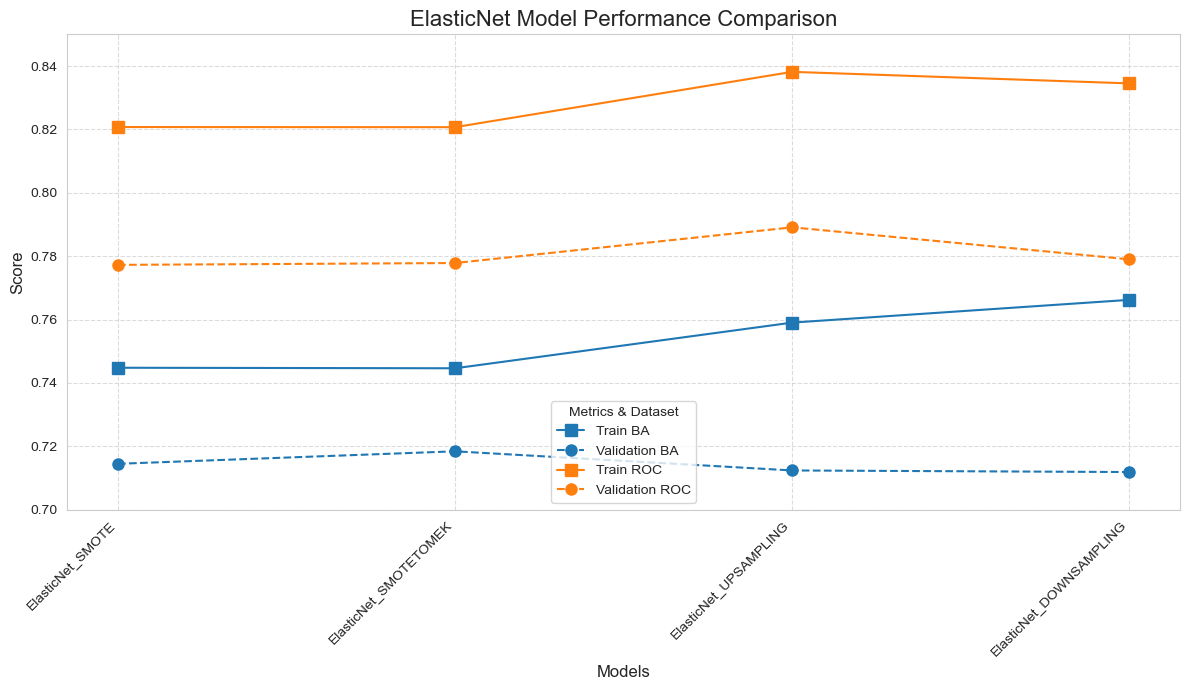

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

metrics = []
for model_name, model in best_elastic_models.items():
    train_pred = model.predict(insurance_train_X)
    train_scores = model.decision_function(insurance_train_X)
    train_ba = balanced_accuracy_score(insurance_train_y, train_pred)
    train_roc = roc_auc_score(insurance_train_y, train_scores)
    
    val_pred = model.predict(insurance_validation_X)
    val_scores = model.decision_function(insurance_validation_X)
    val_ba = balanced_accuracy_score(insurance_validation_y, val_pred)
    val_roc = roc_auc_score(insurance_validation_y, val_scores)
    
    metrics.append({
        'Model': model_name,
        'Train_BA': train_ba,
        'Train_ROC': train_roc,
        'Val_BA': val_ba,
        'Val_ROC': val_roc,
    })

metrics_df = pd.DataFrame(metrics)

plot_data = []
for _, row in metrics_df.iterrows():
    model = row['Model']
    plot_data.append({'Model': model, 'Set': 'Train', 'Metric': 'BA', 'Score': row['Train_BA']})
    plot_data.append({'Model': model, 'Set': 'Train', 'Metric': 'ROC', 'Score': row['Train_ROC']})
    plot_data.append({'Model': model, 'Set': 'Validation', 'Metric': 'BA', 'Score': row['Val_BA']})
    plot_data.append({'Model': model, 'Set': 'Validation', 'Metric': 'ROC', 'Score': row['Val_ROC']})
    
plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

palette = {
    'BA': '#1f77b4',      # Blue
    'ROC': '#ff7f0e',     # Orange
}

for metric in palette.keys():
    metric_df = plot_df[plot_df['Metric'] == metric]
    
    train_df = metric_df[metric_df['Set'] == 'Train']
    plt.plot(train_df['Model'], train_df['Score'], 
             linestyle='-', marker='s', markersize=8,
             color=palette[metric], label=f'Train {metric}')
    
    val_df = metric_df[metric_df['Set'] == 'Validation']
    plt.plot(val_df['Model'], val_df['Score'], 
             linestyle='--', marker='o', markersize=8,
             color=palette[metric], label=f'Validation {metric}')

plt.title('ElasticNet Model Performance Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0.7, 0.85)  
plt.legend(title='Metrics & Dataset', loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

model_names = ['ElasticNet_SMOTE', 'ElasticNet_SMOTETOMEK', 
               'ElasticNet_UPSAMPLING', 'ElasticNet_DOWNSAMPLING']
plt.xticks(ticks=range(len(model_names)), labels=model_names)

plt.tight_layout()
plt.show()

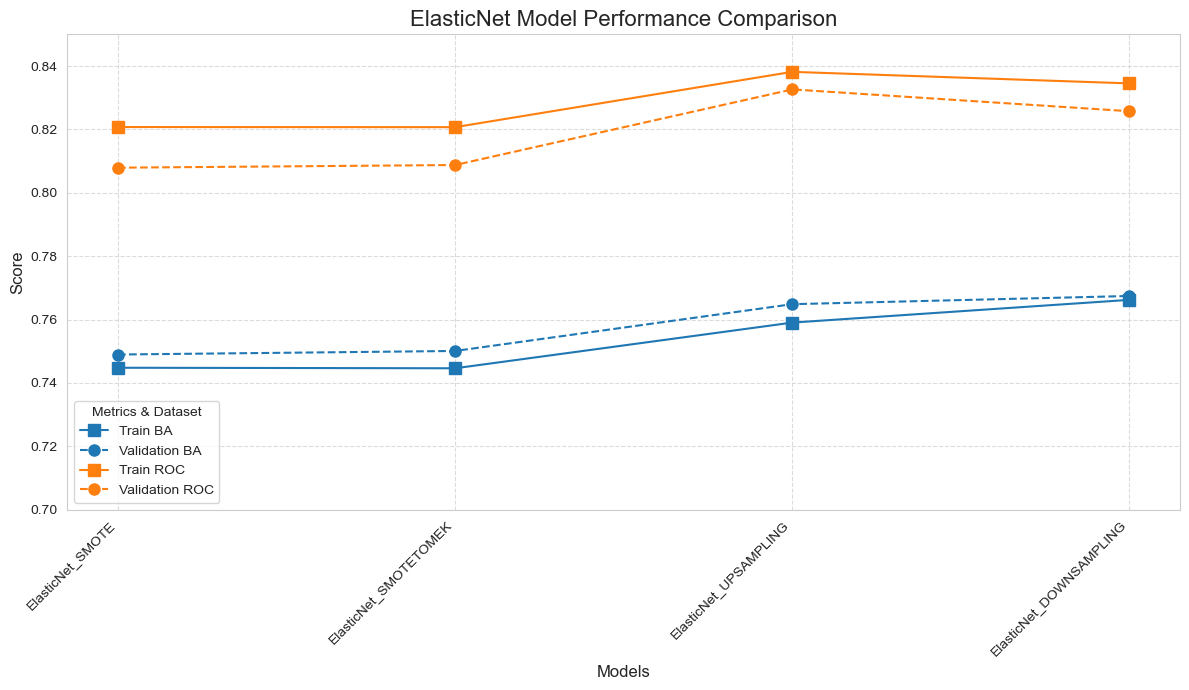

In [ ]:
metrics = []
for model_name, model in best_elastic_models.items():
    train_pred = model.predict(insurance_train_X)
    train_scores = model.decision_function(insurance_train_X)
    train_ba = balanced_accuracy_score(insurance_train_y, train_pred)
    train_roc = roc_auc_score(insurance_train_y, train_scores)
    
    val_pred = model.predict(insurance_test_X)
    val_scores = model.decision_function(insurance_test_X)
    val_ba = balanced_accuracy_score(insurance_test_y, val_pred)
    val_roc = roc_auc_score(insurance_test_y, val_scores)
    
    metrics.append({
        'Model': model_name,
        'Train_BA': train_ba,
        'Train_ROC': train_roc,
        'Val_BA': val_ba,
        'Val_ROC': val_roc,
    })

metrics_df = pd.DataFrame(metrics)

plot_data = []
for _, row in metrics_df.iterrows():
    model = row['Model']
    plot_data.append({'Model': model, 'Set': 'Train', 'Metric': 'BA', 'Score': row['Train_BA']})
    plot_data.append({'Model': model, 'Set': 'Train', 'Metric': 'ROC', 'Score': row['Train_ROC']})
    plot_data.append({'Model': model, 'Set': 'Validation', 'Metric': 'BA', 'Score': row['Val_BA']})
    plot_data.append({'Model': model, 'Set': 'Validation', 'Metric': 'ROC', 'Score': row['Val_ROC']})
    
plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

palette = {
    'BA': '#1f77b4',      # Blue
    'ROC': '#ff7f0e',     # Orange
}

for metric in palette.keys():
    metric_df = plot_df[plot_df['Metric'] == metric]
    
    train_df = metric_df[metric_df['Set'] == 'Train']
    plt.plot(train_df['Model'], train_df['Score'], 
             linestyle='-', marker='s', markersize=8,
             color=palette[metric], label=f'Train {metric}')
    
    val_df = metric_df[metric_df['Set'] == 'Validation']
    plt.plot(val_df['Model'], val_df['Score'], 
             linestyle='--', marker='o', markersize=8,
             color=palette[metric], label=f'Validation {metric}')

plt.title('ElasticNet Model Performance Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0.7, 0.85) 
plt.legend(title='Metrics & Dataset', loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

model_names = ['ElasticNet_SMOTE', 'ElasticNet_SMOTETOMEK', 
               'ElasticNet_UPSAMPLING', 'ElasticNet_DOWNSAMPLING']
plt.xticks(ticks=range(len(model_names)), labels=model_names)

plt.tight_layout()
plt.show()

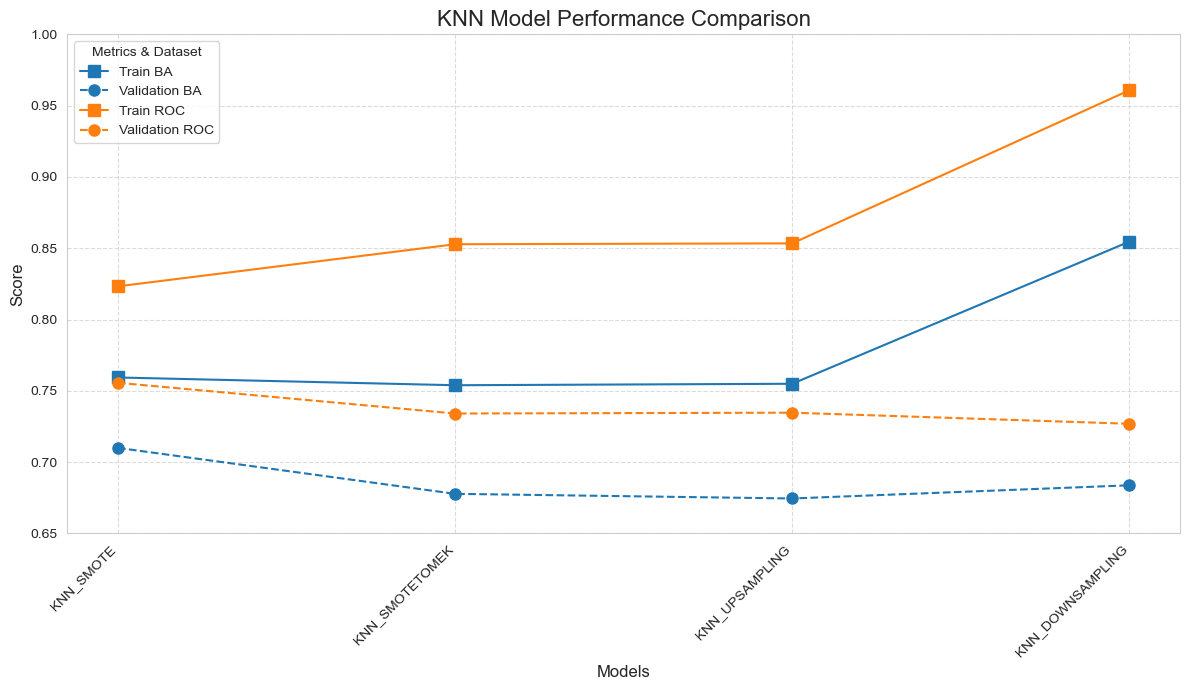

In [ ]:
metrics = []
for model_name, model in best_knn_models.items():
    train_pred = model.predict(insurance_train_X)
    train_scores = model.predict_proba(insurance_train_X)[:,1]
    train_ba = balanced_accuracy_score(insurance_train_y, train_pred)
    train_roc = roc_auc_score(insurance_train_y, train_scores)
    
    val_pred = model.predict(insurance_validation_X)
    val_scores = model.predict_proba(insurance_validation_X)[:,1]
    val_ba = balanced_accuracy_score(insurance_validation_y, val_pred)
    val_roc = roc_auc_score(insurance_validation_y, val_scores)
    
    metrics.append({
        'Model': model_name,
        'Train_BA': train_ba,
        'Train_ROC': train_roc,
        'Val_BA': val_ba,
        'Val_ROC': val_roc,
    })

metrics_df = pd.DataFrame(metrics)

plot_data = []
for _, row in metrics_df.iterrows():
    model = row['Model']
    plot_data.append({'Model': model, 'Set': 'Train', 'Metric': 'BA', 'Score': row['Train_BA']})
    plot_data.append({'Model': model, 'Set': 'Train', 'Metric': 'ROC', 'Score': row['Train_ROC']})
    plot_data.append({'Model': model, 'Set': 'Validation', 'Metric': 'BA', 'Score': row['Val_BA']})
    plot_data.append({'Model': model, 'Set': 'Validation', 'Metric': 'ROC', 'Score': row['Val_ROC']})
    
plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

palette = {
    'BA': '#1f77b4',      # Blue
    'ROC': '#ff7f0e',     # Orange
}

for metric in palette.keys():
    metric_df = plot_df[plot_df['Metric'] == metric]
    
    train_df = metric_df[metric_df['Set'] == 'Train']
    plt.plot(train_df['Model'], train_df['Score'], 
             linestyle='-', marker='s', markersize=8,
             color=palette[metric], label=f'Train {metric}')
    
    val_df = metric_df[metric_df['Set'] == 'Validation']
    plt.plot(val_df['Model'], val_df['Score'], 
             linestyle='--', marker='o', markersize=8,
             color=palette[metric], label=f'Validation {metric}')

plt.title('KNN Model Performance Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0.65, 1) 
plt.legend(title='Metrics & Dataset', loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

model_names = ['KNN_SMOTE', 'KNN_SMOTETOMEK', 
               'KNN_UPSAMPLING', 'KNN_DOWNSAMPLING']
plt.xticks(ticks=range(len(model_names)), labels=model_names)

plt.tight_layout()
plt.show()

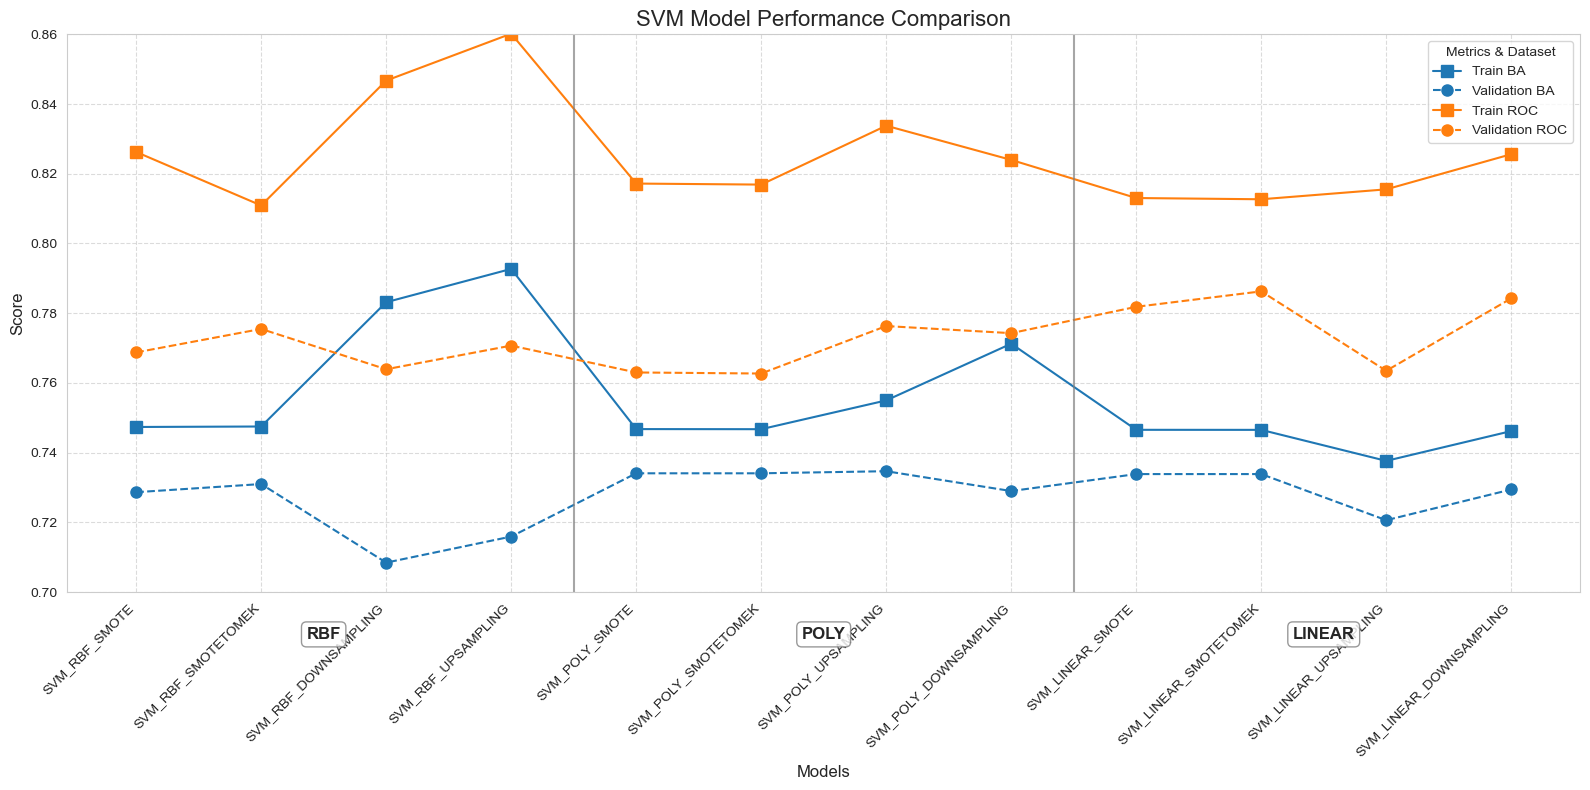

In [ ]:
metrics = []
for model_name, model in best_svm_models.items():
    train_pred = model.predict(insurance_train_X)
    train_scores = model.decision_function(insurance_train_X)
    train_ba = balanced_accuracy_score(insurance_train_y, train_pred)
    train_roc = roc_auc_score(insurance_train_y, train_scores)
    
    val_pred = model.predict(insurance_validation_X)
    val_scores = model.decision_function(insurance_validation_X)
    val_ba = balanced_accuracy_score(insurance_validation_y, val_pred)
    val_roc = roc_auc_score(insurance_validation_y, val_scores)
    
    metrics.append({
        'Model': model_name,
        'Train_BA': train_ba,
        'Train_ROC': train_roc,
        'Val_BA': val_ba,
        'Val_ROC': val_roc,
        'Kernel': model_name.split('_')[1] 
    })

metrics_df = pd.DataFrame(metrics)

plot_data = []
for _, row in metrics_df.iterrows():
    model = row['Model']
    plot_data.append({'Model': model, 'Set': 'Train', 'Metric': 'BA', 'Score': row['Train_BA']})
    plot_data.append({'Model': model, 'Set': 'Train', 'Metric': 'ROC', 'Score': row['Train_ROC']})
    plot_data.append({'Model': model, 'Set': 'Validation', 'Metric': 'BA', 'Score': row['Val_BA']})
    plot_data.append({'Model': model, 'Set': 'Validation', 'Metric': 'ROC', 'Score': row['Val_ROC']})
    
plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

palette = {
    'BA': '#1f77b4',      # Blue
    'ROC': '#ff7f0e',     # Orange
}

for metric in palette.keys():
    metric_df = plot_df[plot_df['Metric'] == metric]
    
    train_df = metric_df[metric_df['Set'] == 'Train']
    plt.plot(train_df['Model'], train_df['Score'], 
             linestyle='-', marker='s', markersize=8,
             color=palette[metric], label=f'Train {metric}')
    
    val_df = metric_df[metric_df['Set'] == 'Validation']
    plt.plot(val_df['Model'], val_df['Score'], 
             linestyle='--', marker='o', markersize=8,
             color=palette[metric], label=f'Validation {metric}')

plt.title('SVM Model Performance Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0.7, 0.86) 
plt.legend(title='Metrics & Dataset', loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

kernel_groups = {
    'RBF': range(0, 4),       
    'POLY': range(4, 8),      
    'LINEAR': range(8, 12)    
}

for i, (kernel, indices) in enumerate(kernel_groups.items()):
    start = min(indices)
    end = max(indices)
    
    if i < len(kernel_groups) - 1:
        plt.axvline(x=end + 0.5, color='gray', linestyle='-', alpha=0.7, linewidth=1.5)
    
    center_pos = start + (end - start)/2
    plt.text(center_pos, 0.69, kernel, 
             ha='center', va='top', fontsize=12, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round'))

plt.tight_layout()
plt.show()

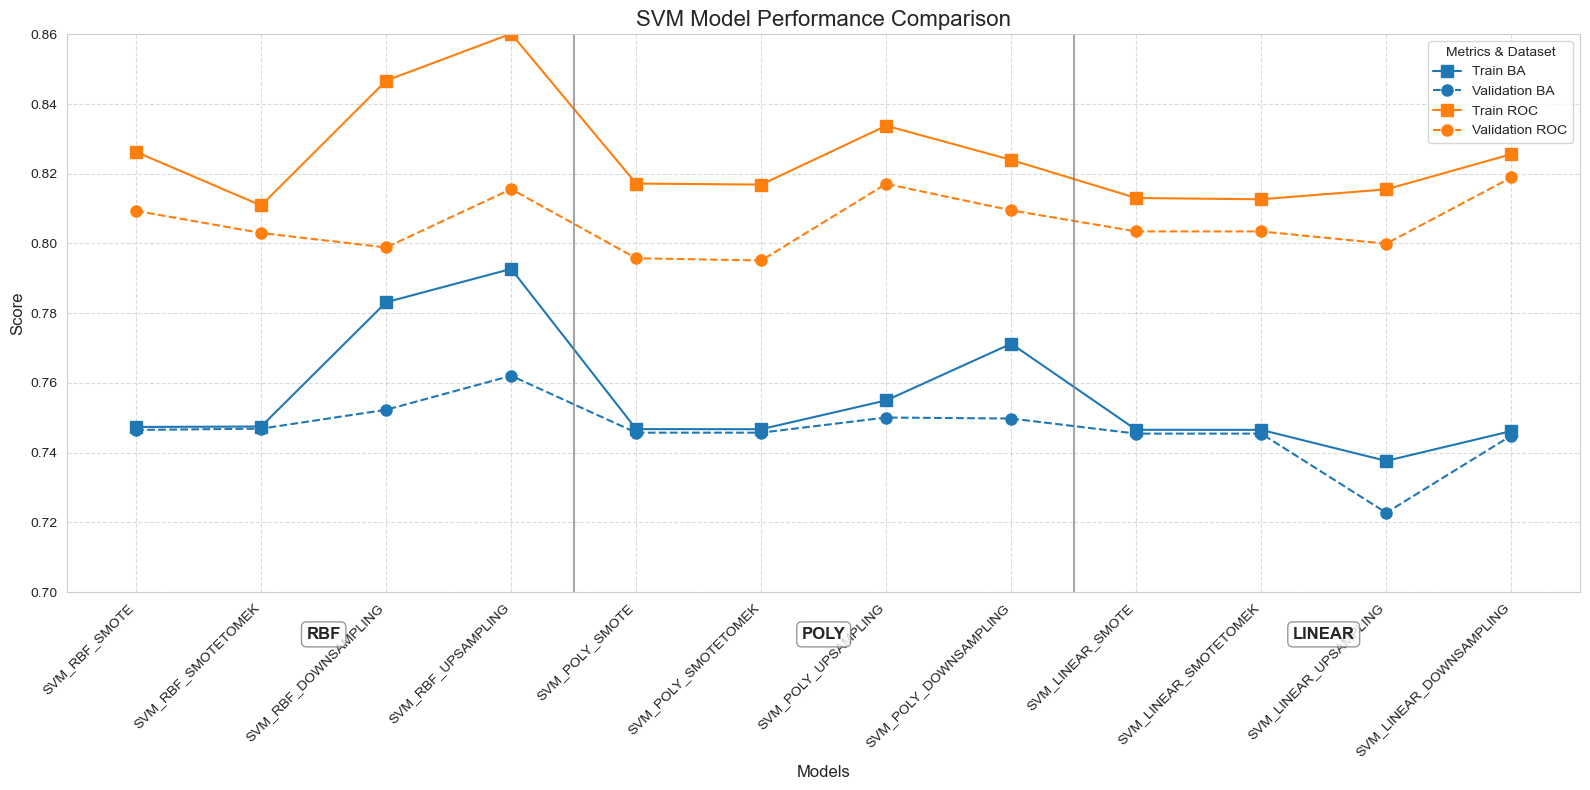

In [ ]:
metrics = []
for model_name, model in best_svm_models.items():
    train_pred = model.predict(insurance_train_X)
    train_scores = model.decision_function(insurance_train_X)
    train_ba = balanced_accuracy_score(insurance_train_y, train_pred)
    train_roc = roc_auc_score(insurance_train_y, train_scores)
    
    val_pred = model.predict(insurance_test_X)
    val_scores = model.decision_function(insurance_test_X)
    val_ba = balanced_accuracy_score(insurance_test_y, val_pred)
    val_roc = roc_auc_score(insurance_test_y, val_scores)
    
    metrics.append({
        'Model': model_name,
        'Train_BA': train_ba,
        'Train_ROC': train_roc,
        'Val_BA': val_ba,
        'Val_ROC': val_roc,
        'Kernel': model_name.split('_')[1]  
    })

metrics_df = pd.DataFrame(metrics)

plot_data = []
for _, row in metrics_df.iterrows():
    model = row['Model']
    plot_data.append({'Model': model, 'Set': 'Train', 'Metric': 'BA', 'Score': row['Train_BA']})
    plot_data.append({'Model': model, 'Set': 'Train', 'Metric': 'ROC', 'Score': row['Train_ROC']})
    plot_data.append({'Model': model, 'Set': 'Validation', 'Metric': 'BA', 'Score': row['Val_BA']})
    plot_data.append({'Model': model, 'Set': 'Validation', 'Metric': 'ROC', 'Score': row['Val_ROC']})
    
plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

palette = {
    'BA': '#1f77b4',      # Blue
    'ROC': '#ff7f0e',     # Orange
}

for metric in palette.keys():
    metric_df = plot_df[plot_df['Metric'] == metric]
    
    train_df = metric_df[metric_df['Set'] == 'Train']
    plt.plot(train_df['Model'], train_df['Score'], 
             linestyle='-', marker='s', markersize=8,
             color=palette[metric], label=f'Train {metric}')
    
    val_df = metric_df[metric_df['Set'] == 'Validation']
    plt.plot(val_df['Model'], val_df['Score'], 
             linestyle='--', marker='o', markersize=8,
             color=palette[metric], label=f'Validation {metric}')

plt.title('SVM Model Performance Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0.7, 0.86) 
plt.legend(title='Metrics & Dataset', loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

kernel_groups = {
    'RBF': range(0, 4),       
    'POLY': range(4, 8),       
    'LINEAR': range(8, 12)    
}

for i, (kernel, indices) in enumerate(kernel_groups.items()):
    start = min(indices)
    end = max(indices)
    
    if i < len(kernel_groups) - 1:
        plt.axvline(x=end + 0.5, color='gray', linestyle='-', alpha=0.7, linewidth=1.5)
    
    center_pos = start + (end - start)/2
    plt.text(center_pos, 0.69, kernel, 
             ha='center', va='top', fontsize=12, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round'))

plt.tight_layout()
plt.show()